In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
import colorsys
import pingouin as pg

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

stimrespdecodingfilename = 'D:\\stimdecoding_resp.csv'
stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stimbufferdecodingfilename = 'D:\\stimdecoding_25s_buffer.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

In [2]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

In [3]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 101/101 [00:00<00:00, 130.10it/s]

[]


In [14]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = 8
firstExpert.pre['AE_236'] = 9
firstExpert.pre['TH_237'] = 7

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [6]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames])#,opsinanimalnames,tuninganimalnames,unuseddualanimals])
#animalnames = np.concatenate([tuninganimalnames])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
# animals['BS_73'].reversal = np.nan
# animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
#animals['DS_15'].reversal = 12
#animals['DS_19'].reversal = 12

# #Opsin Animals
# animals['BS_86'].reversal = 14
# animals['BS_92'].reversal = 9
# animals['BS_100'].reversal = 11
# animals['BS_103'].reversal = 8
# animals['BS_111'].reversal = 8
# animals['BS_119'].reversal = 10
# animals['BS_123'].reversal = 9
# animals['BS_128'].reversal = 6
# animals['BS_131'].reversal = 14
# animals['BS_139'].reversal = 10
# animals['BS_163'].reversal = 13
# animals['BS_165'].reversal = np.Inf
# animals['BS_174'].reversal = 14
# animals['BS_179'].reversal = 16
# animals['BS_191'].reversal = 10
# animals['BS_192'].reversal = 7

# #Tuning Animals
# animals['BS_173'].reversal = 15
# animals['BS_175'].reversal = 11
# animals['BS_187'].reversal = 8
# animals['BS_188'].reversal = 8
# animals['BS_213'].reversal = 8
# animals['BS_214'].reversal = np.Inf
# animals['TH_217'].reversal = 20
# animals['AE_235'].reversal = np.Inf ### Pending
# animals['AE_236'].reversal = np.Inf ### Pending
# animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108']


In [7]:
[print(a) for a in animalBehaviors]

BS_51
BS_52
BS_56
BS_59
BS_61
BS_86
BS_92
BS_100
BS_103
BS_111
BS_119
BS_123
BS_128
BS_131
BS_139
BS_163
BS_165
BS_174
BS_179
BS_191
BS_192
BS_33
BS_67
BS_73
BS_78
BS_108
BS_40
BS_41
BS_42
BS_49
BS_50
BS_70
BS_72
BS_83
BS_85
BS_87
BS_95
BS_113
DS_15
DS_16
DS_19
DS_24
BS_173
BS_175
BS_187
BS_188
BS_213
BS_214
TH_217
AE_235
AE_236
TH_237


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [8]:
np.mean([67.7,68.8,71.7])

69.39999999999999

In [9]:
def getExpertDays(animalBehaviors,animal):
    days = np.sort([k for k in animalBehaviors[animal].sessions])
    num_days = len(days)
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    #############################################################
    #                   Find prereversal expert                 #
    #############################################################
    
    pre_expert_days = []
    
    if np.isfinite(reversal):
        days_to_check = np.sort(list(range(1,reversal)))[::-1]
    else:
        days_to_check = np.sort(list(range(1,num_days+1)))[::-1]
        reversal = np.max(days_to_check)+1
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        
        exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
        if exceptionTrials is None:
            valid_trials_mask = ilep.getActiveTrials(outcomes)
        else:
            valid_trials_mask = exceptionTrials
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            if np.isfinite(reversal):
                [pre_expert_days.append(d) for d in list(range(day,reversal+1))]
            else:
                [pre_expert_days.append(d) for d in list(range(day,np.max(days_to_check)+1))]
        elif day != days_to_check[0]:
            pass#break
    #if len(pre_expert_days)>0:
    #    pre_expert_days = np.concatenate((pre_expert_days))
    pre_expert_days = np.sort(np.unique(pre_expert_days))[::-1]
           
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_40':
        pre_expert_days = np.array([17,16])
    if animal == 'BS_42':
        pre_expert_days = np.array([6,5])
    if animal == 'BS_50':
        pre_expert_days = np.array([11,10])
        
    #############################################################
    #                  Find postreversal expert                 #
    #############################################################
    
    if not np.isfinite(reversal):
        return pre_expert_days,[]
    
    post_expert_days = []
    days_to_check = np.sort(list(range(reversal+1,num_days+1)))[::-1]
    for day in days_to_check:
        outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
        valid_trials_mask = ilep.getActiveTrials(outcomes)
        trimmed_outcomes = outcomes[valid_trials_mask]
        
        PCt,dpt = ilep.pcdpFromOutcomes(trimmed_outcomes)
        
        if PCt >= 0.7 and dpt >= 1.5:
            #post_expert_days.append(day)
            #if day == days_to_check[1]:
            [post_expert_days.append(d) for d in list(range(day,num_days+1))]
                #post_expert_days.append(day+1)
        elif day != days_to_check[0]:
            pass#break
    #if len(post_expert_days)>0:
    #    post_expert_days = np.concatenate((post_expert_days))
    post_expert_days = np.sort(np.unique(post_expert_days))[::-1]
        
    ############### Exceptions for specific animals ##################
    
    if animal == 'BS_49':
        post_expert_days = np.array([20,19,18])
        
    return pre_expert_days,post_expert_days

In [10]:
def getPCDPfromBehavior(animalBehaviors,animal,days,expert):
    cond = np.full_like(days,np.nan,dtype='float')
    cond_pc = np.full_like(days,np.nan,dtype='float')
    if not animal in animalBehaviors:
        return cond,cond_pc
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    for idx,day in enumerate(days):
        if not day in animalBehaviors[animal].sessions:
            continue
            
        #We still want to put the post-reversal days in the right place, so we have to account
        #for the double reversal day
        if hasattr(animalBehaviors[animal],'reversal') and day > animalBehaviors[animal].reversal:
            idx+=1
            
        ########## Pre/Postreversal ##########
        if day != reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            #We will trim for active trials only on expert days
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                pass#print(f"Trimming via exception trials")
                valid_trials_mask = exceptionTrials
                outcomes = outcomes[valid_trials_mask]
            elif day in expert:
                valid_trials_mask = ilep.getActiveTrials(outcomes)
                outcomes = outcomes[valid_trials_mask]

            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))

            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            #print(dp)
            if not exceptionTrials is None:
                pass#print(f"PC is {pc} dp is {dp}")

            cond[idx] = dp
            cond_pc[idx] = pc
            
        ########## Switch ##########
        if day == reversal:
            trials_per_session = animalBehaviors[animal].sessions[day].trials_per_session
            pre_reversal_trials = range(int(trials_per_session[0]))
            post_reversal_trials = range(int(trials_per_session[0]),int(np.sum(trials_per_session)))
            
            #Prereversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[pre_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx] = dp
            cond_pc[idx] = pc

            #Postreversal
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            outcomes = outcomes[post_reversal_trials]
            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))
            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            cond[idx+1] = dp
            cond_pc[idx+1] = pc
            
    return cond,cond_pc

BS_40
BS_41
BS_42
BS_49
BS_50


C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_51
BS_56
BS_59
BS_67


C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_70
BS_72
BS_87


C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_108


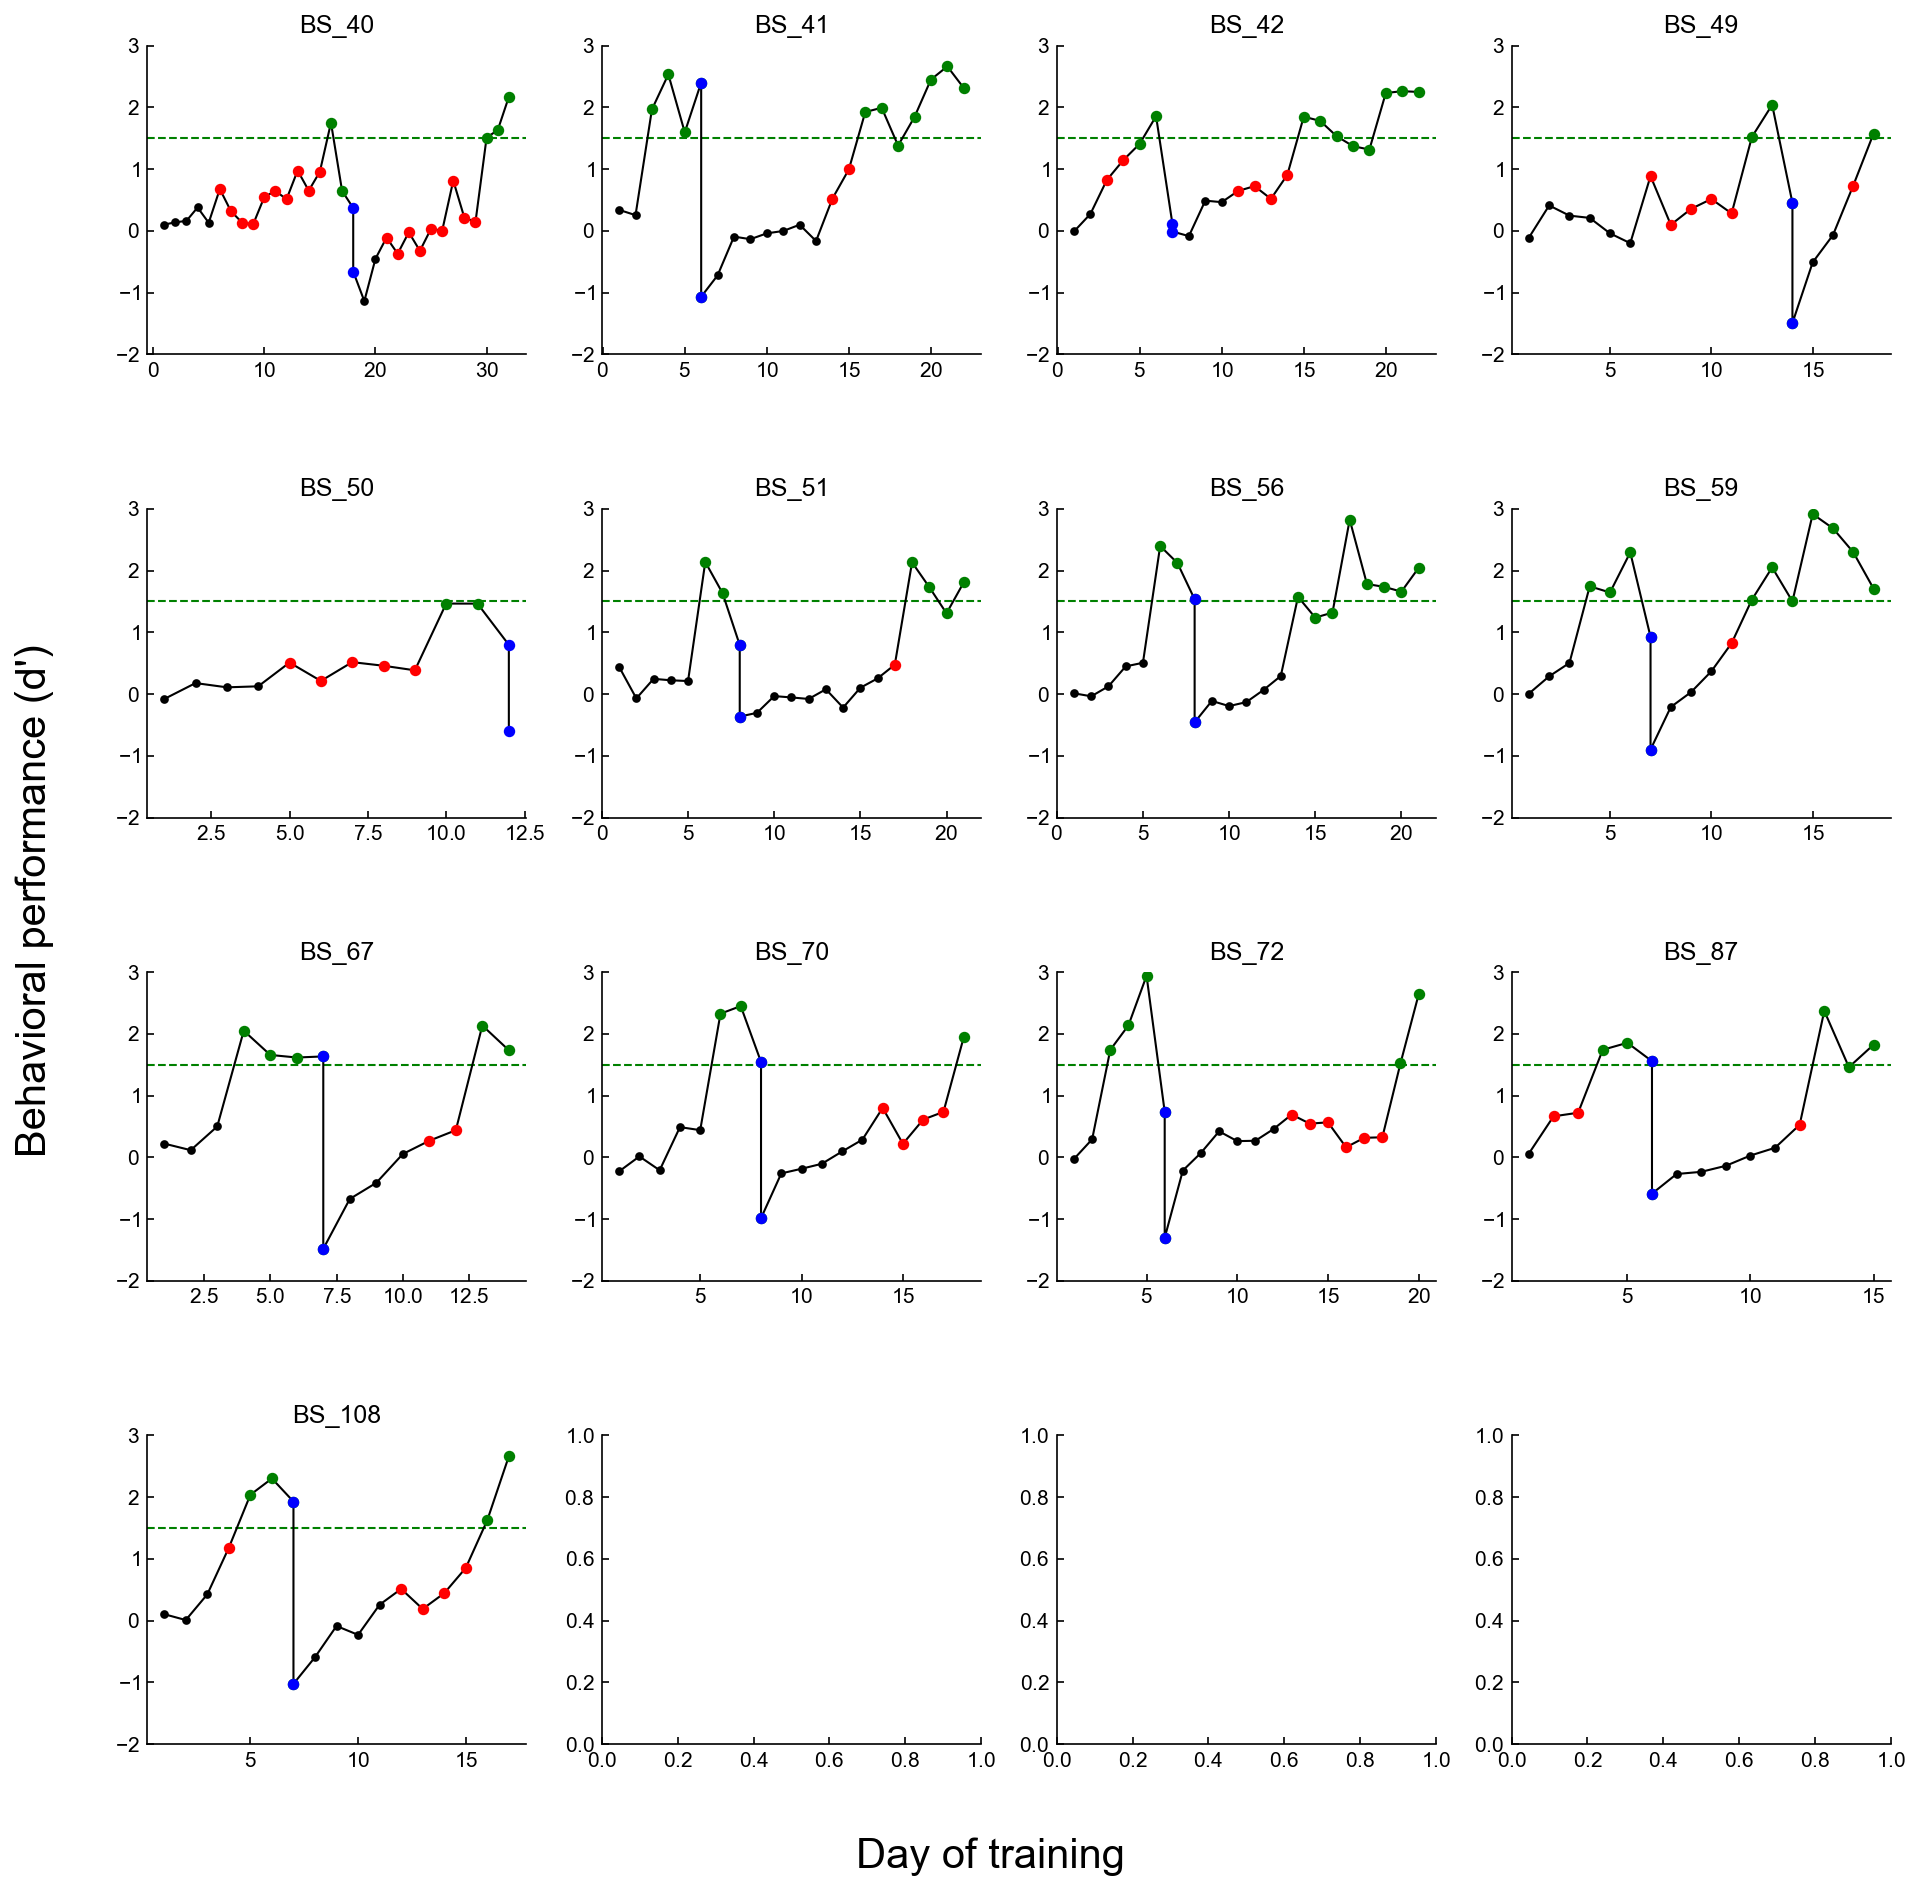

In [43]:
animalPhases = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

for animalidx,animal in enumerate(animals):
    print(animal)
    
    animalPhases[animal] = SimpleNamespace()
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if np.isfinite(reversal):
        days.append(reversal)
    days = np.sort(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
            
    ############### Calculation of learning phases ###################
    
    pre_reversal_days_mask = np.less(days,reversal)
    post_reversal_days_mask = np.greater(days,reversal)
    
    pre_reversal_dp_list = dp_list[pre_reversal_days_mask]
    post_reversal_dp_list = dp_list[post_reversal_days_mask]
    if np.isfinite(reversal):
        pre_switch_dp = dp_list[reversal-1]
        post_switch_dp = dp_list[reversal]
    else:
        pre_switch_dp = dp_list[len(dp_list)-1]
        post_switch_dp = []
        
#     print(f"reversal at {reversal}")
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
    
    pre_rev_dp_concat = pre_reversal_dp_list#np.concatenate((pre_reversal_dp_list,pre_switch_dp))
    pre_rev_min = min(np.min(pre_reversal_dp_list),0)
    pre_rev_max = max(np.max(pre_reversal_dp_list),1.5)
    pre_reversal_dp_thresh = pre_rev_min + 0.3 * (pre_rev_max - pre_rev_min)
    post_rev_dp_concat = pre_reversal_dp_list#np.concatenate((post_reversal_dp_list,post_switch_dp))
#     print(f"post_rev dp list is {post_reversal_dp_list}")
    try:
        post_rev_min = min(np.min(post_reversal_dp_list),0)
        post_rev_max = max(np.max(post_reversal_dp_list),1.5)
        post_reversal_dp_thresh = post_rev_min + 0.3 * (post_rev_max - post_rev_min)
    except:
        post_rev_min = np.nan
        post_rev_max = np.nan
        post_reversal_dp_thresh = np.Inf

    pre_late_days_mask = np.greater_equal(pre_reversal_dp_list,pre_reversal_dp_thresh)
    post_late_days_mask = np.greater_equal(post_reversal_dp_list,post_reversal_dp_thresh)
    
    ############ Export final results to a list of days ############
    
    pre_reversal_days = np.where(pre_reversal_days_mask)[0] + 1
    post_reversal_days = np.where(post_reversal_days_mask)[0] # No +1 because double reversal day
    
    pre_expert_days = np.sort(pre_exp)
    post_expert_days = np.sort(post_exp)
    
    pre_late_days = np.where(pre_late_days_mask)[0] + 1
    post_late_days = np.where(post_late_days_mask)[0] + 1 + reversal # No +1 because adding reversal. +1 because double reversal
    
#     print(f"pre_reversal list is {pre_reversal_dp_list}")
#     print(f"post_reversal list is {post_reversal_dp_list}")
#     print(f"pre_late days are {pre_late_days}")
#     print(f"post_late days are {post_late_days}")
    
    if len(pre_late_days)>0:
        last_day_late = reversal
        if not np.isfinite(reversal):
            last_day_late = np.max(days)
#             print(f"last day = {last_day_late}")
        pre_late_days = np.arange(np.min(pre_late_days),last_day_late)
    if len(post_late_days)>0:
        post_late_days = np.arange(np.min(post_late_days),max(days))
    pre_late_days = pre_late_days[np.logical_not(np.isin(pre_late_days,pre_expert_days))]
    post_late_days = post_late_days[np.logical_not(np.isin(post_late_days,post_expert_days))]
    
    pre_early_days = pre_reversal_days[np.logical_not(np.isin(pre_reversal_days,pre_late_days))]
    post_early_days = post_reversal_days[np.logical_not(np.isin(post_reversal_days,post_late_days))]
    pre_early_days = pre_early_days[np.logical_not(np.isin(pre_early_days,pre_expert_days))]
    post_early_days = post_early_days[np.logical_not(np.isin(post_early_days,post_expert_days))]
    
    if False:#animal in ['BS_72']:
        print(animal)
        print(f"reversal is {reversal}")
        print(f"dps are {dp_list}")

        print(f"Pre-reversal days mask: {pre_reversal_days_mask}")
        print(f"Post-reversal days mask: {post_reversal_days_mask}")

        print(f"Pre-reversal dps: {pre_reversal_dp_list}")
        print(f"Post-reversal dps: {post_reversal_dp_list}")

        print(f"Pre-reversal threshold: {pre_reversal_dp_thresh}")
        print(f"Post-reversal threshold: {post_reversal_dp_thresh}")

        print(f"Pre-reversal days: {pre_reversal_days}")
        print(f"Post-reversal days: {post_reversal_days}")

        print(f"Pre-early days: {pre_early_days}")
        print(f"Post-early days: {post_early_days}")

        print(f"Pre-late days: {pre_late_days}")
        print(f"Post-late days: {post_late_days}")

        print(f"Pre-expert days: {pre_expert_days}")
        print(f"Post-expert days: {post_expert_days}")
        
    animalPhases[animal].pre_early_days = pre_early_days
    animalPhases[animal].pre_late_days = pre_late_days
    animalPhases[animal].pre_expert_days = pre_expert_days
    if np.isfinite(reversal):
        animalPhases[animal].switch_days = [reversal]
    else:
        animalPhases[animal].switch_days = []
    animalPhases[animal].post_early_days = post_early_days
    animalPhases[animal].post_late_days = post_late_days
    animalPhases[animal].post_expert_days = post_expert_days
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,dp_list,color='k',lw=1)
        ax.scatter(days,dp_list,color='k',s=10,zorder=9)
        
        #Pre Late
        pre_late = np.isin(days,pre_late_days)
        ax.scatter(days[pre_late],dp_list[pre_late],color='r',s=20,zorder=10)
        #Post Late
        post_late = np.isin(days,post_late_days)
        ax.scatter(days[post_late],dp_list[post_late],color='r',s=20,zorder=10)
        
        #Pre Expert
        pre_expert = np.isin(days,pre_expert_days)
        ax.scatter(days[pre_expert],dp_list[pre_expert],color='g',s=20,zorder=10)
        #Post Expert
        post_expert = np.isin(days,post_expert_days)
        ax.scatter(days[post_expert],dp_list[post_expert],color='g',s=20,zorder=10)
        
        #Switch
        switch = np.equal(days,reversal)
        ax.scatter(days[switch],dp_list[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        #days_recorded = training_days_recorded[animal]
        #ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)
        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases Tuning.pdf'),transparent=False,facecolor="white")
    pass

In [9]:
def getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days):    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
        
    #We will remove the duplicate reversal day because we will calculate both
    #pre and post reversal when we get there at once
    days = np.unique(days)
    
    trials_list_per_day = dict()
    
    for day in days:
        if not day in animalBehaviors[animal].sessions:
            continue
            
        outcomes = np.array(animalBehaviors[animal].sessions[day].outcomes)
        valid_trials = np.array(range(len(outcomes)))
        ########## Pre/Postreversal ##########
        if day != reversal:
            
            exceptionTrials = ilep.exceptionsForSpecificBehaviorDays(animal,day)
            if not exceptionTrials is None:
                valid_trials = exceptionTrials
            elif day in expert_days:
                valid_trials = ilep.getActiveTrials(outcomes)
        
        trials_list_per_day[day] = valid_trials
        
    return trials_list_per_day




trialsPerDay = dict()
for animal in animalBehaviors:
    try:
        days = [k for k in animalBehaviors[animal].sessions]

        pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
        expert_days = np.concatenate((pre_exp,post_exp))

        trials_list = getTrialsPerDayPerAnimal(animalBehaviors,animal,days,expert_days)

        trialsPerDay[animal] = trials_list
        
    except Exception as e:
        print(f"{animal} has exception {e}")
        if animal == 'BS_73':
            raise e
        trialsPerDay[animal] = None
pass

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:85: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


BS_92 has exception 10
BS_100 has exception 29
BS_111 has exception 22
BS_163 has exception negative dimensions are not allowed
BS_33 has exception negative dimensions are not allowed
DS_19 has exception 16
DS_24 has exception 1


In [83]:
trialsPerDay
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'wb') as f:
        pickle.dump(trialsPerDay, f, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
with open('C:\\Users\\insan\\Desktop\\trialsToUsePerDay', 'rb') as f:
        trialsPerDayLoaded = pickle.load(f)

In [85]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in np.concatenate((dualanimalnames,['DS_15','DS_19'])):
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 533/533 [00:02<00:00, 194.48it/s]


In [86]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in animalPhases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in animalPhases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in animalPhases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and animal in ['DS_15','DS_19']:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1440/1440 [00:08<00:00, 165.74it/s]

errors for: ['DS_15' 'DS_19']


In [87]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

ramping_preearly = []
ramping_prelate = []
ramping_preexpert = []
ramping_postearly = []
ramping_postlate = []
ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

animalstouse = np.concatenate((dualanimalnames,unuseddualanimals,tuninganimalnames))
print(animalstouse)

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    #if not sessionfile.meta.animal in animalstouse:
    #    continue
    #if sessionfile.meta.animal in tuninganimalnames:
    #    continue
        
    if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
        continue
        
    if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
        
    #if not sessionfile.meta.animal in ['BS_213','BS_214']:
    #    continue
    
    #else:
    #    print(ilep.generateDateString(sessionfile))
    #    print(len(sessionfile.clusters.good))
        
    #if np.isnan(accuracies[idx]):
    #    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

ramping_preearly = np.array(ramping_preearly)
ramping_prelate = np.array(ramping_prelate)
ramping_preexpert = np.array(ramping_preexpert)
ramping_postearly = np.array(ramping_postearly)
ramping_postlate = np.array(ramping_postlate)
ramping_postexpert = np.array(ramping_postexpert)
ramping_preearly = ramping_preearly[np.isfinite(ramping_preearly)]
ramping_prelate = ramping_prelate[np.isfinite(ramping_prelate)]
ramping_preexpert = ramping_preexpert[np.isfinite(ramping_preexpert)]
ramping_postearly = ramping_postearly[np.isfinite(ramping_postearly)]
ramping_postlate = ramping_postlate[np.isfinite(ramping_postlate)]
ramping_postexpert = ramping_postexpert[np.isfinite(ramping_postexpert)]

# FRt_preearly = np.array(FRt_preearly)
# FRt_prelate = np.array(FRt_prelate)
# FRt_preexpert = np.array(FRt_preexpert)
# FRt_postearly = np.array(FRt_postearly)
# FRt_postlate = np.array(FRt_postlate)
# FRt_postexpert = np.array(FRt_postexpert)

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

18it [00:00, 163.60it/s]

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'BS_78' 'BS_173' 'BS_175' 'BS_187'
 'BS_188' 'BS_213' 'BS_214' 'TH_217' 'AE_235' 'AE_236' 'TH_237']


1440it [00:08, 168.97it/s]


In [88]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

In [56]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
# fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.150,f"n={len(FRmod_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.150,f"n={len(FRmod_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.150,f"n={len(FRmod_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.150,f"n={len(FRmod_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.150,f"n={len(FRmod_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.150,f"n={len(FRmod_postexpert)}",fontsize=6,horizontalalignment='center')

#NORMAL
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.05, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.05, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#WIDE
# ax.annotate('', xy=(0.0325, -0.105), xycoords='axes fraction', xytext=(0.485, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.5325, -0.105), xycoords='axes fraction', xytext=(0.985, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, 0.035, 'Pre-rev', ha='center', va='top', fontsize=12)
# ax.text(xtick_pos_post, 0.035, 'Post-rev', ha='center', va='top',  fontsize=12)

ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
#ax.legend(frameon=False,loc=(1,0.9))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC stimulus modulation automated phases all cells NARROW.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC stimulus modulation automated phases all cells NARROW.png'),transparent=False,facecolor="white")

NameError: name 'FRmod_preearly' is not defined

In [92]:
data = SimpleNamespace(preearly=FRmod_preearly,
                      prelate=FRmod_prelate,
                      preexpert=FRmod_preexpert,
                      postearly=FRmod_postearly,
                      postlate=FRmod_postlate,
                      postexpert=FRmod_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToPreearly(data)

            Source             SS      DF          MS         F     p-unc  \
0            phase    1496.430647     4.0  374.107662  4.395603  0.001538   
1          context     708.738501     1.0  708.738501  8.327371  0.003950   
2  phase * context     898.408774     4.0  224.602194  2.638979  0.032359   
3         Residual  159920.771017  1879.0   85.109511       NaN       NaN   

        np2  
0  0.009271  
1  0.004412  
2  0.005586  
3       NaN  

          phase         A             B         p-unc        p-corr    hedges
11   post-early  baseline  experimental  6.293454e-01  6.293454e-01 -0.065174
12  post-expert  baseline  experimental  3.368109e-04  8.420272e-04  0.342517
13    post-late  baseline  experimental  4.847035e-08  2.423517e-07  0.352847
14   pre-expert  baseline  experimental  5.850244e-01  6.293454e-01  0.086854
15     pre-late  baseline  experimental  8.636127e-03  1.439355e-02  0.257238


In [93]:
data = SimpleNamespace(preearly=FRmod_preearly,
                      prelate=FRmod_prelate,
                      preexpert=FRmod_preexpert,
                      postearly=FRmod_postearly,
                      postlate=FRmod_postlate,
                      postexpert=FRmod_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source             SS      DF           MS          F  \
0            phase      24.799126     3.0     8.266375   0.079702   
1          context    2647.307187     1.0  2647.307187  25.524598   
2  phase * context     423.224218     3.0   141.074739   1.360203   
3         Residual  185132.918560  1785.0   103.715921        NaN   

          p-unc       np2  
0  9.710334e-01  0.000134  
1  4.814518e-07  0.014098  
2  2.532588e-01  0.002281  
3           NaN       NaN  

          phase         A             B         p-unc        p-corr    hedges
7   post-expert  baseline  experimental  4.588560e-04  9.177119e-04  0.301416
8     post-late  baseline  experimental  5.657080e-09  2.262832e-08  0.317768
9    pre-expert  baseline  experimental  5.850244e-01  5.850244e-01  0.086854
10     pre-late  baseline  experimental  8.636127e-03  1.151484e-02  0.257238


In [14]:
def removeNan(data):
    return data[np.isfinite(data)]

#Stimulus

FRmod_baseline_median = np.nanmedian(FRmod_preearly)
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.mean(np.greater(removeNan(FRmod_preearly),FRmod_baseline_median))
FRmod_prelate_pc = np.mean(np.greater(removeNan(FRmod_prelate),FRmod_baseline_median))
FRmod_preexpert_pc = np.mean(np.greater(removeNan(FRmod_preexpert),FRmod_baseline_median))
FRmod_postearly_pc = np.mean(np.greater(removeNan(FRmod_postearly),FRmod_baseline_median))
FRmod_postlate_pc = np.mean(np.greater(removeNan(FRmod_postlate),FRmod_baseline_median))
FRmod_postexpert_pc = np.mean(np.greater(removeNan(FRmod_postexpert),FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)

# #Choice 

# ramping_baseline_median = np.nanmedian(np.abs(ramping_preearly))
# print('baseline: '+str(ramping_baseline_median))

# #These numbers are essentially %CR
# ramping_preearly_pc = np.nanmean(np.greater(np.abs(ramping_preearly),ramping_baseline_median))
# ramping_prelate_pc = np.nanmean(np.greater(np.abs(ramping_prelate),ramping_baseline_median))
# ramping_preexpert_pc = np.nanmean(np.greater(np.abs(ramping_preexpert),ramping_baseline_median))
# ramping_postearly_pc = np.nanmean(np.greater(np.abs(ramping_postearly),ramping_baseline_median))
# ramping_postlate_pc = np.nanmean(np.greater(np.abs(ramping_postlate),ramping_baseline_median))
# ramping_postexpert_pc = np.nanmean(np.greater(np.abs(ramping_postexpert),ramping_baseline_median))
# print(ramping_preearly_pc)
# print(ramping_prelate_pc)
# print(ramping_preexpert_pc)
# print(ramping_postearly_pc)
# print(ramping_postlate_pc)
# print(ramping_postexpert_pc)

baseline: 3.462532299741601
0.49714285714285716
0.38509316770186336
0.4895833333333333
0.49184149184149184
0.2831050228310502
0.34782608695652173


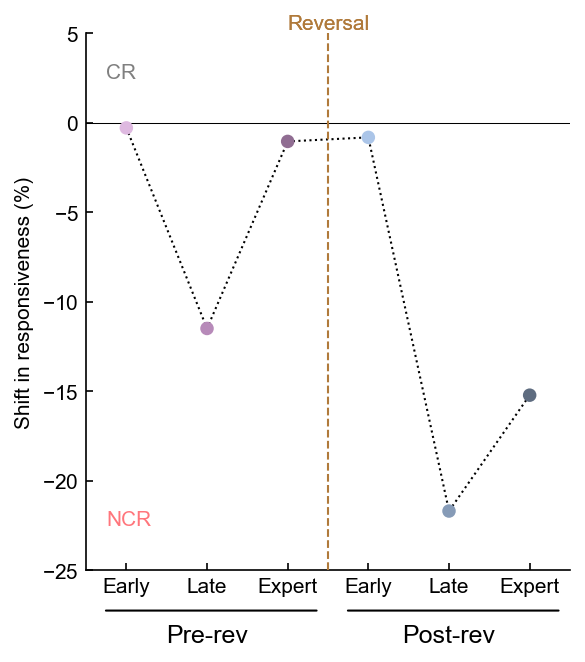

In [44]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCRstim = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCRstim-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCRstim-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCRstim-50),c=PHASE_COLORS,s=30,zorder=10,marker='o',lw=1)



# percentCRchoice = np.array([ramping_preearly_pc,ramping_prelate_pc,ramping_preexpert_pc,ramping_postearly_pc,ramping_postlate_pc,ramping_postexpert_pc])*100
# numCon = len(labels)
# ax.plot([0,1,2,3,4,5],(percentCRchoice-50),color='k',linestyle=':',lw=1,alpha=1)

# color=NCR_CR_cmap((percentCRchoice-40)/20)
# ax.scatter([0,1,2,3,4,5],(percentCRchoice-50),fc='white',ec=PHASE_COLORS,s=50,zorder=10,marker='o',lw=1)





#xlims = [-0.75,numCon-0.25]
xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
# ax.set_ylabel('Shift in responsiveness (%)')
# ax.set_ylim([-20,20])
# ax.set_yticks([-20,-10,0,10,20])
# ax.text(-0.5,17.5,'CR',color=CR_COLOR)
# ax.text(-0.5,-17.5,'NCR',color=NCR_COLOR)
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-25,5])
ax.set_yticks([-25,-20,-15,-10,-5,0,5])
ax.text(-0.25,2.5,'CR',color=CR_COLOR)
ax.text(-0.25,-22.5,'NCR',color=NCR_COLOR)


# ax.annotate('', xy=(0.07, -0.08), xycoords='axes fraction', xytext=(0.48, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.08), xycoords='axes fraction', xytext=(0.94, -0.08),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

# ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='stimulus')
# ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='choice')
#ax.legend(frameon=False,loc=(1,0.85))

ax.annotate('', xy=(0.0325, -0.075), xycoords='axes fraction', xytext=(0.485, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.5325, -0.075), xycoords='axes fraction', xytext=(0.985, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -28, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -28, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Shift in both responsiveness all cells NARROW.png'),transparent=False,facecolor="white")
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Shift in both responsiveness all cells NARROW.pdf'),transparent=False,facecolor="white")

# Behavior vs Passive comparison

Step 1: Ensure that FRmod_preearly and such are calculated and in memory (using the cells earlier in this notebook)

The following code comes from TH's Passive no behavior notebook. It is unchanged from that notebook as of 2/24/2023

In [37]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 533/533 [00:04<00:00, 114.73it/s]


In [38]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
switch = 9
post_early = 13
post_late = 15
post_expert = 16

#
FRmod_passive_preearly = []
FRmod_passive_prelate = []
FRmod_passive_preexpert = []
FRmod_passive_postearly = []
FRmod_passive_postlate = []
FRmod_passive_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [39]:
preearly_passive_animal = []
prelate_passive_animal = []
preexpert_passive_animal = []
postearly_passive_animal = []
postlate_passive_animal = []
postexpert_passive_animal = []


for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        FRmod_passive_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_passive_animal.append(ACsessionfile.meta.animal)
        
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        FRmod_passive_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_passive_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        FRmod_passive_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_passive_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training > switch:
        FRmod_passive_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_passive_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        FRmod_passive_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_passive_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        FRmod_passive_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_passive_animal.append(ACsessionfile.meta.animal)
    

1442it [00:09, 151.87it/s]


In [40]:
#number of animals in each learning phase

preearly_passive_animal = np.unique(preearly_passive_animal)
prelate_passive_animal = np.unique(prelate_passive_animal)
preexpert_passive_animal = np.unique(preexpert_passive_animal)
postearly_passive_animal = np.unique(postearly_passive_animal)
postlate_passive_animal = np.unique(postlate_passive_animal)
postexpert_passive_animal = np.unique(postexpert_passive_animal)

preearly_passive_animal_num = len(preearly_passive_animal)
prelate_passive_animal_num = len(prelate_passive_animal)
preexpert_passive_animal_num = len(preexpert_passive_animal)
postearly_passive_animal_num = len(postearly_passive_animal)
postlate_passive_animal_num = len(postlate_passive_animal)
postexpert_passive_animal_num = len(postexpert_passive_animal)

In [41]:
FRmod_passive_preearly = np.array(FRmod_passive_preearly)
FRmod_passive_prelate = np.array(FRmod_passive_prelate)
FRmod_passive_preexpert = np.array(FRmod_passive_preexpert)
FRmod_passive_postearly = np.array(FRmod_passive_postearly)
FRmod_passive_postlate = np.array(FRmod_passive_postlate)
FRmod_passive_postexpert = np.array(FRmod_passive_postexpert)

The following is to be considered from this notebook. It will integrate the data from the behaving animals and the passive animals to compare them

baseline = 3.462532299741601


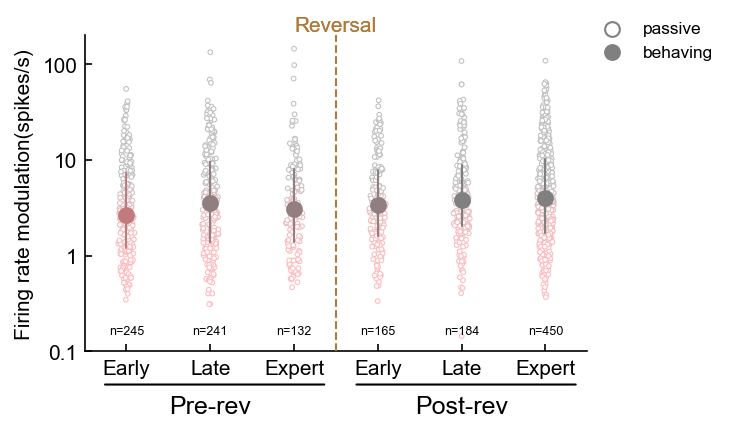

In [296]:
#Firing rate modulation graphs

size=5

FRmod_passive_baseline_median = np.nanmedian(np.abs(FRmod_passive_preearly))
print('baseline = '+str(FRmod_baseline_median))

#fig, ax = plt.subplots(figsize=(4,4.5))
fig, ax = plt.subplots(figsize=(5,3))
data = [FRmod_passive_preearly,FRmod_passive_prelate,FRmod_passive_preexpert,FRmod_passive_postearly,FRmod_passive_postlate,FRmod_passive_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_passive_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,0.150,f"n={len(FRmod_passive_preearly)}",fontsize=6,horizontalalignment='center')
ax.text(1,0.150,f"n={len(FRmod_passive_prelate)}",fontsize=6,horizontalalignment='center')
ax.text(2,0.150,f"n={len(FRmod_passive_preexpert)}",fontsize=6,horizontalalignment='center')
ax.text(3,0.150,f"n={len(FRmod_passive_postearly)}",fontsize=6,horizontalalignment='center')
ax.text(4,0.150,f"n={len(FRmod_passive_postlate)}",fontsize=6,horizontalalignment='center')
ax.text(5,0.150,f"n={len(FRmod_passive_postexpert)}",fontsize=6,horizontalalignment='center')

# NORMAL
# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, 0.05, 'Pre-rev', ha='center', va='top', fontsize=12)
# ax.text(xtick_pos_post, 0.05, 'Post-rev', ha='center', va='top',  fontsize=12)
# ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

# WIDE
ax.annotate('', xy=(0.0325, -0.105), xycoords='axes fraction', xytext=(0.485, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.5325, -0.105), xycoords='axes fraction', xytext=(0.985, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.035, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.035, 'Post-rev', ha='center', va='top',  fontsize=12)

ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
ax.legend(frameon=False,loc=(1,0.9))

plt.tight_layout()
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC passive stimulus modulation automated phases all cells WIDE.pdf'),transparent=False,facecolor="white")
fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC passive stimulus modulation automated phases all cells WIDE.png'),transparent=False,facecolor="white")

<ipython-input-54-200a1cfbe13a>:16: RuntimeWarning: divide by zero encountered in log10
  data = [np.log10(d) for d in data]
<ipython-input-54-200a1cfbe13a>:23: RuntimeWarning: divide by zero encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
<ipython-input-54-200a1cfbe13a>:23: RuntimeWarning: invalid value encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
<ipython-input-54-200a1cfbe13a>:68: RuntimeWarning: invalid value encountered in log10
  X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(passive_data)),width=0.25)


#DEB9E0
#B78AB9
#906D92
#ABC5E8
#869BB7
#5E6C80
0.05597945103477291
0.01951817057421925
0.42548733873789746
0.9855203968000248
9.122841692735281e-11
3.6944563722239696e-05


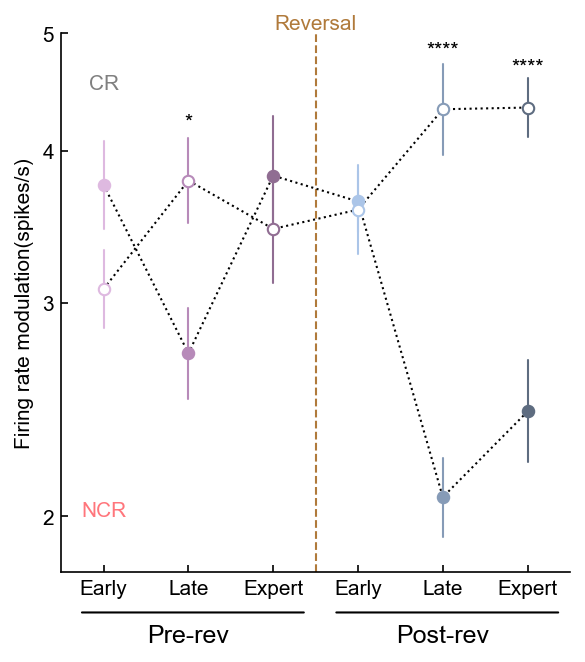

In [54]:
#Firing rate modulation graphs
def removeNan(data):
    return data[np.isfinite(data)]

size=5

FRmod_baseline_median = 3.4986225895316823#np.median(FRmod_preearly)
labels = ['Early','Late','Expert','Early','Late','Expert']
offset_distance = 0#0.05

fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))

data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [removeNan(d) for d in data]
data = [np.log10(d) for d in data]
data = [removeNan(d) for d in data]
num_animals = [preearly_animals_num,prelate_animals_num,preexpert_animals_num,postearly_animals_num,postlate_animals_num,postexpert_animals_num]
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X-0.125, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    #eye_color=NCR_CR_cmap((percentCR-40)/20)
    eye_color = PHASE_COLORS[idx]
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=eye_color#colorsys.hls_to_rgb(h,l*0.5,s)
    
    #eye_color='k'
    #border_color='k'

    summary_size=30#50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx-offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-offset_distance, idx-offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q1, Q1], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx-offset_distance-0.05, idx-offset_distance+0.05], [Q3, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in data]
plt.plot(np.linspace(0,5,6)-offset_distance,medians,color='k',linestyle=':',lw=1)
    
######################################################################################################################################################
passive_data = [FRmod_passive_preearly,FRmod_passive_prelate,FRmod_passive_preexpert,FRmod_passive_postearly,FRmod_passive_postlate,FRmod_passive_postexpert]
passive_data = [removeNan(d) for d in passive_data]
passive_data = [np.log10(d) for d in passive_data]
passive_data = [removeNan(d) for d in passive_data]
num_passive_animal = [preearly_passive_animal_num,prelate_passive_animal_num,preexpert_passive_animal_num,postearly_passive_animal_num,postlate_passive_animal_num,postexpert_passive_animal_num]
X = [np.ones(len(l))*idx for idx,l in enumerate(passive_data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(passive_data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(passive_data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

#ax.scatter(X+0.125, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10,marker='s')
#ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(passive_data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    #eye_color=NCR_CR_cmap((percentCR-40)/20)
    eye_color=PHASE_COLORS[idx]
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=eye_color#colorsys.hls_to_rgb(h,l*0.5,s)
    print(border_color)
    
    eye_color='white'
    #border_color='k'

    summary_size=30#50
    summary_width=1
    
    #Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    median = np.mean(column)
    Q1 = median - sem(column)
    Q3 = median + sem(column)
    
    ax.scatter([idx+offset_distance], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10,marker='o')
    ax.plot([idx+offset_distance, idx+offset_distance], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx+offset_distance-0.05, idx+offset_distance+0.05], [Q1, Q1], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    #ax.plot([idx+offset_distance-0.05, idx+offset_distance+0.05], [Q3, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
medians = [np.mean(col) for col in passive_data]
plt.plot(np.linspace(0,5,6)+offset_distance,medians,color='k',linestyle=':',lw=1)
    


ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
#
#ax.set_ylim([0.1,100])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')
#ax.set_ylim([2,10])
#ax.set_yticks([2,4,6,8,10])
#ax.set_yticks([0.1,1,10,100])
#ax.set_yticklabels(['0.1','1','10','100'])

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

#numbers
#cells
#for idx,(column1,column2) in enumerate(zip(data,passive_data)):
#    #ax.text(idx,120,str(len(column1))+'/'+str(len(column2)),fontsize=8)
#    ax.text(idx,12,str(len(column1))+'/'+str(len(column2)),fontsize=6)
##animals
#for idx,(column1,column2) in enumerate(zip(num_animals,num_passive_animal)):
#    #ax.text(idx,95,str(column1)+'/'+str(column2),fontsize=8)
#    ax.text(idx,11.75,str(column1)+'/'+str(column2),fontsize=6)
    
#ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(FRmod_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)

ax.scatter([],[],ec='grey',fc='white',s=summary_size,lw=summary_width,zorder=10,marker='o',label='passive')
ax.scatter([],[],ec='grey',fc='grey',s=summary_size,lw=summary_width,zorder=10,marker='o',label='behaving')
#ax.legend(frameon=False,loc=(1,0.9))

for idx,(column1,column2) in enumerate(zip(data,passive_data)):
    pval = mannwhitneyu(column1,column2).pvalue
    print(pval)
    
#statistics
#ax.text(0,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
ax.text(1,np.log10(4.15),str('*'),verticalalignment='bottom',horizontalalignment='center')
#ax.text(2,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
#ax.text(3,0.75,str('n.s.'),verticalalignment='bottom',horizontalalignment='center')
ax.text(4,np.log10(4.75),str('****'),verticalalignment='bottom',horizontalalignment='center')
ax.text(5,np.log10(4.6),str('****'),verticalalignment='bottom',horizontalalignment='center')

#ax.text(-0.4,9.5,'CR',color=CR_COLOR,horizontalalignment='left',verticalalignment='top')
#ax.text(-0.4,0.5,'NCR',color=NCR_COLOR,horizontalalignment='left',verticalalignment='bottom')

#ax.set_yscale('log',subs=[])
#ax.set_ylim([2,10])
ax.set_yticks(np.log10([2,3,4,5]))
ax.set_yticklabels(['2','3','4','5'])
ax.set_ylim([np.log10(1.8),np.log10(5)])

ax.text(0,np.log10(4.5),'CR',color=CR_COLOR,horizontalalignment='center')
ax.text(0,np.log10(2),'NCR',color=NCR_COLOR,horizontalalignment='center')

# ax.annotate('', xy=(0.03, -0.105), xycoords='axes fraction', xytext=(0.48, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.105), xycoords='axes fraction', xytext=(0.98, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
# xtick_pos_pre = ax.get_xticks()[1]
# xtick_pos_post = ax.get_xticks()[4]
# ax.text(xtick_pos_pre, 0.1962400778232111, 'Pre-rev', ha='center', va='top', fontsize=12)
# ax.text(xtick_pos_post, 0.1962400778232111, 'Post-rev', ha='center', va='top',  fontsize=12)

ax.annotate('', xy=(0.0325, -0.075), xycoords='axes fraction', xytext=(0.485, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.5325, -0.075), xycoords='axes fraction', xytext=(0.985, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.2125, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.2125, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join('D:\\Figures','Automated Behavior Figures','Behavior vs Passive FRmodulation over learning.pdf'),transparent=False,facecolor="white")

In [55]:
def rmnan(data):
    return data[np.isfinite(data)]

FRmod_baseline_median = np.median(rmnan(FRmod_preearly))
print('baseline: '+str(FRmod_baseline_median))

#These numbers are essentially %CR
FRmod_preearly_pc = np.nanmean(np.greater(rmnan(FRmod_preearly),FRmod_baseline_median))
FRmod_prelate_pc = np.nanmean(np.greater(rmnan(FRmod_prelate),FRmod_baseline_median))
FRmod_preexpert_pc = np.nanmean(np.greater(rmnan(FRmod_preexpert),FRmod_baseline_median))
FRmod_postearly_pc = np.nanmean(np.greater(rmnan(FRmod_postearly),FRmod_baseline_median))
FRmod_postlate_pc = np.nanmean(np.greater(rmnan(FRmod_postlate),FRmod_baseline_median))
FRmod_postexpert_pc = np.nanmean(np.greater(rmnan(FRmod_postexpert),FRmod_baseline_median))
print(FRmod_preearly_pc)
print(FRmod_prelate_pc)
print(FRmod_preexpert_pc)
print(FRmod_postearly_pc)
print(FRmod_postlate_pc)
print(FRmod_postexpert_pc)

print()
FRmod_passive_baseline_median = np.median(rmnan(FRmod_passive_preearly))
print('baseline_passive: '+str(FRmod_passive_baseline_median))

#These numbers are essentially %CR
FRmod_passive_preearly_pc = np.nanmean(np.greater(rmnan(FRmod_passive_preearly),FRmod_passive_baseline_median))
FRmod_passive_prelate_pc = np.nanmean(np.greater(rmnan(FRmod_passive_prelate),FRmod_passive_baseline_median))
FRmod_passive_preexpert_pc = np.nanmean(np.greater(rmnan(FRmod_passive_preexpert),FRmod_passive_baseline_median))
FRmod_passive_postearly_pc = np.nanmean(np.greater(rmnan(FRmod_passive_postearly),FRmod_passive_baseline_median))
FRmod_passive_postlate_pc = np.nanmean(np.greater(rmnan(FRmod_passive_postlate),FRmod_passive_baseline_median))
FRmod_passive_postexpert_pc = np.nanmean(np.greater(rmnan(FRmod_passive_postexpert),FRmod_passive_baseline_median))
print(FRmod_passive_preearly_pc)
print(FRmod_passive_prelate_pc)
print(FRmod_passive_preexpert_pc)
print(FRmod_passive_postearly_pc)
print(FRmod_passive_postlate_pc)
print(FRmod_passive_postexpert_pc)

baseline: 3.462532299741601
0.49714285714285716
0.38509316770186336
0.4895833333333333
0.49184149184149184
0.2831050228310502
0.34782608695652173

baseline_passive: 2.6315789473684212
0.49795918367346936
0.5726141078838174
0.5681818181818182
0.5757575757575758
0.5978260869565217
0.6333333333333333


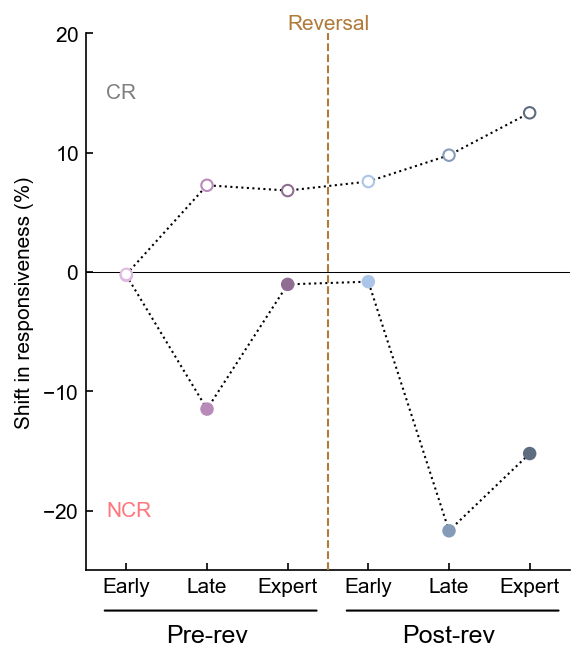

In [75]:
fig, ax = plt.subplots(figsize=(4,4.5))
#fig, ax = plt.subplots(figsize=(5,3))
labels = ['Early','Late','Expert','Early','Late','Expert']
#colors = phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']

percentCR = np.array([FRmod_preearly_pc,FRmod_prelate_pc,FRmod_preexpert_pc,FRmod_postearly_pc,FRmod_postlate_pc,FRmod_postexpert_pc])*100
numCon = len(labels)
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter([0,1,2,3,4,5],(percentCR-50),c=PHASE_COLORS,s=30,zorder=10,marker='o',lw=1)


percentCR = np.array([FRmod_passive_preearly_pc,FRmod_passive_prelate_pc,FRmod_passive_preexpert_pc,FRmod_passive_postearly_pc,FRmod_passive_postlate_pc,FRmod_passive_postexpert_pc])*100
ax.plot([0,1,2,3,4,5],(percentCR-50),color='k',linestyle=':',lw=1,alpha=1)

color=NCR_CR_cmap((percentCR-40)/20)
ax.scatter(range(numCon),(percentCR-50),fc='white',ec=PHASE_COLORS,s=30,zorder=10,marker='o',lw=1)















xlims = [-0.5,numCon-0.5]
ax.set_xlim(xlims)
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)

#All cells with All Cells baseline
ax.set_ylabel('Shift in responsiveness (%)')
ax.set_ylim([-25,20])
ax.set_yticks([-20,-10,0,10,20])
ax.text(-0.25,15,'CR',color=CR_COLOR,verticalalignment='center')
ax.text(-0.25,-20,'NCR',color=NCR_COLOR,verticalalignment='center')

#ax.plot([2.5,2.5],ax.get_ylim(),color='blue',lw=1,zorder=-15)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)
ax.axhline(0,c='k',linestyle='-',lw=0.5,zorder=-10)

ax.scatter([],[],fc='white',ec='grey',s=50,marker='o',lw=1,label='passive')
ax.scatter([],[],fc='grey',ec='grey',s=50,marker='o',lw=1,label='behaving')
#ax.legend(frameon=False,loc=(1,0.85))

# ax.annotate('', xy=(0.07, -0.105), xycoords='axes fraction', xytext=(0.48, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.annotate('', xy=(0.53, -0.105), xycoords='axes fraction', xytext=(0.94, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
# ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

ax.annotate('', xy=(0.03, -0.075), xycoords='axes fraction', xytext=(0.485, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.075), xycoords='axes fraction', xytext=(0.985, -0.075),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -29.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -29.5, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
fig.savefig(os.path.join('D:\\Figures','Automated Behavior Figures','Behavior vs Passive Shift in responsiveness.pdf'),transparent=False,facecolor="white")

# Spontaneous/Evoked Firing Rate

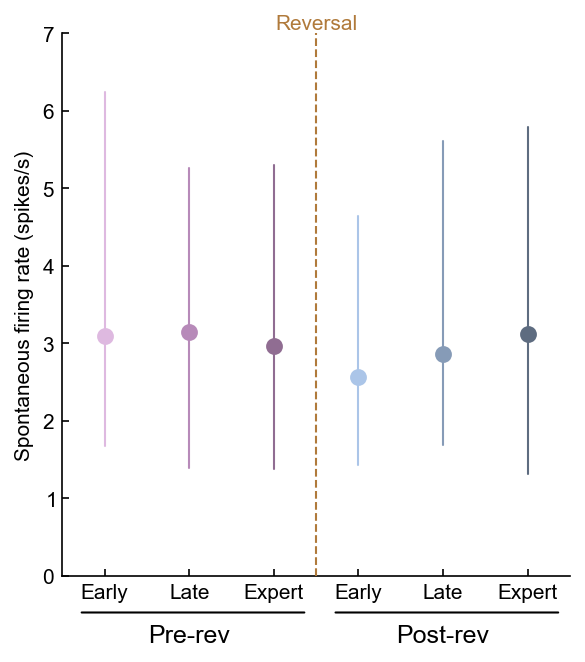

In [38]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRb_preearly,FRb_prelate,FRb_preexpert,FRb_postearly,FRb_postlate,FRb_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])

#ax.scatter(X[unitsperphase[0]:unitsperphase[1]], Y[unitsperphase[0]:unitsperphase[1]], s=size, ec=phase_colors[0], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[1]:unitsperphase[2]], Y[unitsperphase[1]:unitsperphase[2]], s=size, ec=phase_colors[1], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[2]:unitsperphase[3]], Y[unitsperphase[2]:unitsperphase[3]], s=size, ec=phase_colors[2], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[3]:unitsperphase[4]], Y[unitsperphase[3]:unitsperphase[4]], s=size, ec=phase_colors[3], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[4]:unitsperphase[5]], Y[unitsperphase[4]:unitsperphase[5]], s=size, ec=phase_colors[4], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[5]:unitsperphase[6]], Y[unitsperphase[5]:unitsperphase[6]], s=size, ec=phase_colors[5], fc='white', lw=0.5,zorder=-10)


#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    #Q1 = median - np.nanstd(column)
    #Q3 = median + np.nanstd(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,7])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Spontaneous firing rate (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.annotate('', xy=(0.03, -0.0675), xycoords='axes fraction', xytext=(0.485, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.0675), xycoords='axes fraction', xytext=(0.985, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -0.9313259409288069/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -0.9313259409288069/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC active presentation spontaneous.pdf'),transparent=False,facecolor="white")

In [280]:
data = SimpleNamespace(preearly=FRb_preearly,
                      prelate=FRb_prelate,
                      preexpert=FRb_preexpert,
                      postearly=FRb_postearly,
                      postlate=FRb_postlate,
                      postexpert=FRb_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source            SS      DF         MS         F     p-unc  \
0            phase    110.805908     3.0  36.935303  1.963672  0.117449   
1          context     96.447759     1.0  96.447759  5.127663  0.023668   
2  phase * context    222.916328     3.0  74.305443  3.950462  0.008044   
3         Residual  33254.846662  1768.0  18.809302       NaN       NaN   

        np2  
0  0.003321  
1  0.002892  
2  0.006659  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.302866  0.371909 -0.347654
8     post-late  baseline  experimental  0.035718  0.142870 -0.215268
9    pre-expert  baseline  experimental  0.371909  0.371909  0.052690
10     pre-late  baseline  experimental  0.226201  0.371909  0.106026


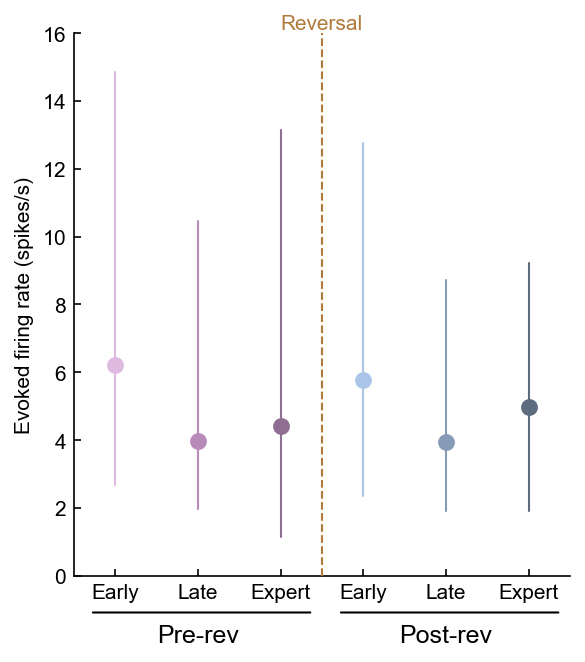

In [37]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRe_preearly,FRe_prelate,FRe_preexpert,FRe_postearly,FRe_postlate,FRe_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])

#ax.scatter(X[unitsperphase[0]:unitsperphase[1]], Y[unitsperphase[0]:unitsperphase[1]], s=size, ec=phase_colors[0], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[1]:unitsperphase[2]], Y[unitsperphase[1]:unitsperphase[2]], s=size, ec=phase_colors[1], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[2]:unitsperphase[3]], Y[unitsperphase[2]:unitsperphase[3]], s=size, ec=phase_colors[2], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[3]:unitsperphase[4]], Y[unitsperphase[3]:unitsperphase[4]], s=size, ec=phase_colors[3], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[4]:unitsperphase[5]], Y[unitsperphase[4]:unitsperphase[5]], s=size, ec=phase_colors[4], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[5]:unitsperphase[6]], Y[unitsperphase[5]:unitsperphase[6]], s=size, ec=phase_colors[5], fc='white', lw=0.5,zorder=-10)


#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    #Q1 = median - np.nanstd(column)
    #Q3 = median + np.nanstd(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,16])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Evoked firing rate (spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.annotate('', xy=(0.03, -0.0675), xycoords='axes fraction', xytext=(0.485, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.0675), xycoords='axes fraction', xytext=(0.985, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 2*-1.0643725039186365/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 2*-1.0643725039186365/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC active presentation evoked.pdf'),transparent=False,facecolor="white")

In [282]:
data = SimpleNamespace(preearly=FRe_preearly,
                      prelate=FRe_prelate,
                      preexpert=FRe_preexpert,
                      postearly=FRe_postearly,
                      postlate=FRe_postlate,
                      postexpert=FRe_postexpert
                     )

#res = ilep.nonparametricIndependentStatsCompareToPreearly(data)
res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source             SS      DF           MS          F     p-unc  \
0            phase      90.902890     3.0    30.300963   0.203421  0.894064   
1          context    1929.221835     1.0  1929.221835  12.951535  0.000328   
2  phase * context     227.078230     3.0    75.692743   0.508152  0.676690   
3         Residual  263355.986961  1768.0   148.957006        NaN       NaN   

        np2  
0  0.000345  
1  0.007272  
2  0.000862  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.105752  0.105752  0.190289
8     post-late  baseline  experimental  0.007954  0.031818  0.227930
9    pre-expert  baseline  experimental  0.074501  0.099334  0.050724
10     pre-late  baseline  experimental  0.045993  0.091985  0.235440


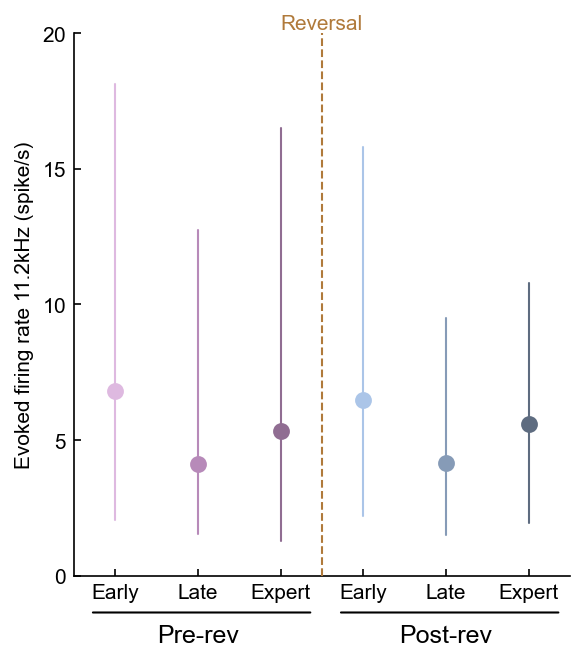

In [36]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FReT_preearly,FReT_prelate,FReT_preexpert,FReNT_postearly,FReNT_postlate,FReNT_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])

#ax.scatter(X[unitsperphase[0]:unitsperphase[1]], Y[unitsperphase[0]:unitsperphase[1]], s=size, ec=phase_colors[0], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[1]:unitsperphase[2]], Y[unitsperphase[1]:unitsperphase[2]], s=size, ec=phase_colors[1], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[2]:unitsperphase[3]], Y[unitsperphase[2]:unitsperphase[3]], s=size, ec=phase_colors[2], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[3]:unitsperphase[4]], Y[unitsperphase[3]:unitsperphase[4]], s=size, ec=phase_colors[3], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[4]:unitsperphase[5]], Y[unitsperphase[4]:unitsperphase[5]], s=size, ec=phase_colors[4], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[5]:unitsperphase[6]], Y[unitsperphase[5]:unitsperphase[6]], s=size, ec=phase_colors[5], fc='white', lw=0.5,zorder=-10)


#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    #Q1 = median - np.nanstd(column)
    #Q3 = median + np.nanstd(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,20])
ax.set_yticks([0,5,10,15,20])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Evoked firing rate 11.2kHz (spike/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.annotate('', xy=(0.03, -0.0675), xycoords='axes fraction', xytext=(0.485, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.0675), xycoords='axes fraction', xytext=(0.985, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -2.660931259796591/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -2.660931259796591/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC active presentation evoked 11khz.pdf'),transparent=False,facecolor="white")

In [278]:
data = SimpleNamespace(preearly=FReT_preearly,
                      prelate=FReT_prelate,
                      preexpert=FReT_preexpert,
                      postearly=FReNT_postearly,
                      postlate=FReNT_postlate,
                      postexpert=FReNT_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source             SS      DF           MS          F     p-unc  \
0            phase     788.601924     3.0   262.867308   1.182691  0.314906   
1          context    3832.086083     1.0  3832.086083  17.241293  0.000034   
2  phase * context     673.509055     3.0   224.503018   1.010082  0.387251   
3         Residual  392959.394105  1768.0   222.262101        NaN       NaN   

        np2  
0  0.002003  
1  0.009658  
2  0.001711  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.153879  0.205172  0.204320
8     post-late  baseline  experimental  0.003251  0.013002  0.278763
9    pre-expert  baseline  experimental  0.234690  0.234690  0.019926
10     pre-late  baseline  experimental  0.015349  0.030698  0.296972


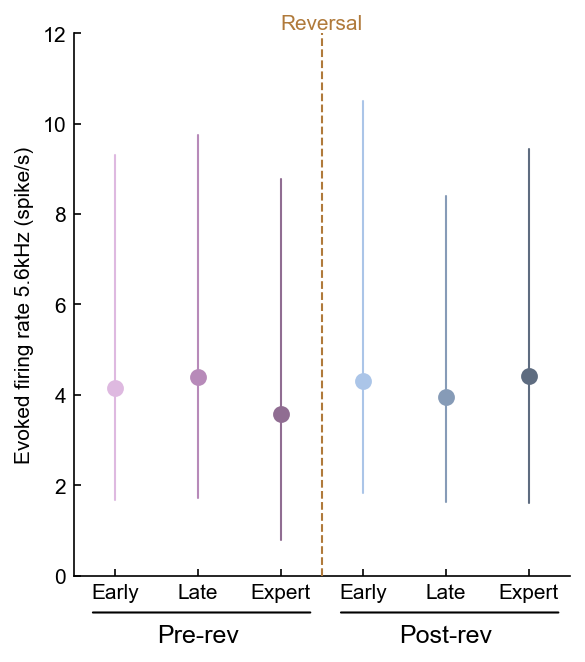

In [35]:
size=5

#FRb_baseline_median = np.nanmedian(FRb_preint)

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FReNT_preearly,FReNT_prelate,FReNT_preexpert,FReT_postearly,FReT_postlate,FReT_postexpert]
labels = ['Early','Late','Expert','Early','Late','Expert']
phase_colors = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

X,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
#colors = NCR_CR_cmap((Y-1)/5)

numunits = [len(d) for d in data]
cumsumunits = np.cumsum(numunits)
unitsperphase= np.concatenate([[0],cumsumunits])

#ax.scatter(X[unitsperphase[0]:unitsperphase[1]], Y[unitsperphase[0]:unitsperphase[1]], s=size, ec=phase_colors[0], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[1]:unitsperphase[2]], Y[unitsperphase[1]:unitsperphase[2]], s=size, ec=phase_colors[1], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[2]:unitsperphase[3]], Y[unitsperphase[2]:unitsperphase[3]], s=size, ec=phase_colors[2], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[3]:unitsperphase[4]], Y[unitsperphase[3]:unitsperphase[4]], s=size, ec=phase_colors[3], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[4]:unitsperphase[5]], Y[unitsperphase[4]:unitsperphase[5]], s=size, ec=phase_colors[4], fc='white', lw=0.5,zorder=-10)
#ax.scatter(X[unitsperphase[5]:unitsperphase[6]], Y[unitsperphase[5]:unitsperphase[6]], s=size, ec=phase_colors[5], fc='white', lw=0.5,zorder=-10)


#Plot summary
for idx,column in enumerate(data):
    
    eye_color=phase_colors[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color = eye_color

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.nanpercentile(column, q) for q in [25, 50, 75])
    #Q1 = median - np.nanstd(column)
    #Q3 = median + np.nanstd(column)
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')
    
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

#ax.set_yscale('log',subsy=[])
ax.set_ylim([0,12])
#ax.set_yticks([-1,-0.5,0,0.5,1])
#ax.set_yticklabels(['0.1','1','10','100'])
#ax.set_yticks([-1,0,1])
#ax.set_yticklabels(['100%\nTone B','0','100%\nTone A'])
ax.set_ylabel('Evoked firing rate 5.6kHz (spike/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

ax.annotate('', xy=(0.03, -0.0675), xycoords='axes fraction', xytext=(0.485, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.0675), xycoords='axes fraction', xytext=(0.985, -0.0675),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -1.5965587558779548/1.5, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -1.5965587558779548/1.5, 'Post-rev', ha='center', va='top',  fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC active presentation evoked 5khz.pdf'),transparent=False,facecolor="white")

In [277]:
data = SimpleNamespace(preearly=FReNT_preearly,
                      prelate=FReNT_prelate,
                      preexpert=FReNT_preexpert,
                      postearly=FReT_postearly,
                      postlate=FReT_postlate,
                      postexpert=FReT_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source             SS      DF          MS         F     p-unc  \
0            phase     251.783338     3.0   83.927779  0.611033  0.607852   
1          context     575.819404     1.0  575.819404  4.192230  0.040757   
2  phase * context     162.461723     3.0   54.153908  0.394265  0.757148   
3         Residual  242841.817934  1768.0  137.353969       NaN       NaN   

        np2  
0  0.001036  
1  0.002366  
2  0.000669  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.693437  0.924583  0.116465
8     post-late  baseline  experimental  0.421226  0.842451  0.154747
9    pre-expert  baseline  experimental  0.187890  0.751562  0.019792
10     pre-late  baseline  experimental  0.936378  0.936378  0.074643


baseline = 0.9498626865671642
0
1
2
3
4
5


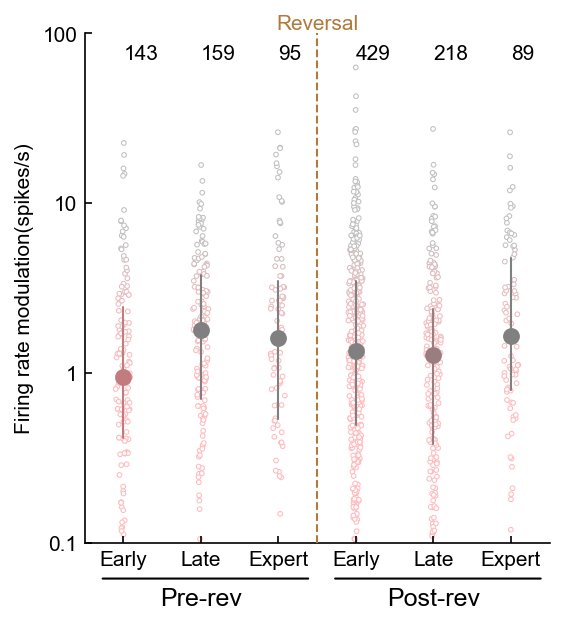

In [274]:
#Firing rate modulation graphs

size=5

ramping_baseline_median = np.nanmedian(np.abs(ramping_preearly))
print('baseline = '+str(ramping_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [ramping_preearly,ramping_prelate,ramping_preexpert,ramping_postearly,ramping_postlate,ramping_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,ramping_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    print(idx)
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,100])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,70,str(len(ramping_preearly)))
ax.text(1,70,str(len(ramping_prelate)))
ax.text(2,70,str(len(ramping_preexpert)))
ax.text(3,70,str(len(ramping_postearly)))
ax.text(4,70,str(len(ramping_postlate)))
ax.text(5,70,str(len(ramping_postexpert)))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.055, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.055, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC choice modulation all cells over learning ALL_GO.pdf'),transparent=False,facecolor="white")

In [275]:
data = SimpleNamespace(preearly=ramping_preearly,
                      prelate=ramping_prelate,
                      preexpert=ramping_preexpert,
                      postearly=ramping_postearly,
                      postlate=ramping_postlate,
                      postexpert=ramping_postexpert
                     )

res = ilep.nonparametricIndependentStatsCompareToPreearly(data)

            Source            SS      DF          MS         F     p-unc  \
0            phase    294.366479     4.0   73.591620  3.199406  0.012526   
1          context    144.440832     1.0  144.440832  6.279586  0.012307   
2  phase * context    209.165152     4.0   52.291288  2.273371  0.059263   
3         Residual  38987.795415  1695.0   23.001649       NaN       NaN   

        np2  
0  0.007494  
1  0.003691  
2  0.005336  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
11   post-early  baseline  experimental  0.588482  0.588482  0.042931
12  post-expert  baseline  experimental  0.002928  0.007320 -0.427277
13    post-late  baseline  experimental  0.001224  0.006118 -0.242236
14   pre-expert  baseline  experimental  0.006598  0.010997 -0.020591
15     pre-late  baseline  experimental  0.028944  0.036181 -0.209229


In [276]:
res = ilep.nonparametricIndependentStatsCompareToOwnEarly(data)

            Source            SS      DF          MS          F     p-unc  \
0            phase     21.990852     3.0    7.330284   0.261426  0.853212   
1          context    470.343773     1.0  470.343773  16.774242  0.000044   
2  phase * context    154.744576     3.0   51.581525   1.839593  0.137956   
3         Residual  47583.276252  1697.0   28.039644        NaN       NaN   

        np2  
0  0.000462  
1  0.009788  
2  0.003242  
3       NaN  

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.003090  0.006180 -0.374516
8     post-late  baseline  experimental  0.001889  0.006180 -0.223126
9    pre-expert  baseline  experimental  0.006598  0.008798 -0.020591
10     pre-late  baseline  experimental  0.028944  0.028944 -0.209229


In [23]:
animals_in_cache = []
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    animals_in_cache.append(sessionfile.meta.animal)
animals_in_cache = np.unique(animals_in_cache)

training_days_recorded = dict()
for animal in animals_in_cache:
    training_days_recorded[animal] = []
    
for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
for session in tqdm(os.listdir(ops_directory)):
    sessionfile = ilep.loadSessionCached(ops_directory,session)
    if sessionfile.meta.region != 'AC':
        continue
    training_days_recorded[sessionfile.meta.animal].append(sessionfile.meta.day_of_training)
    
print(training_days_recorded['BS_59'])

100%|██████████| 101/101 [00:00<00:00, 103.04it/s]

[]


In [24]:
firstExpert = SimpleNamespace()
firstExpert.pre = dict()
firstExpert.post = dict()

#Tuning Animals
firstExpert.pre['BS_173'] = 14
firstExpert.pre['BS_175'] = 10
firstExpert.pre['BS_187'] = 6
firstExpert.pre['BS_188'] = 5
firstExpert.pre['BS_213'] = 6
firstExpert.pre['BS_214'] = np.Inf
firstExpert.pre['TH_217'] = 18
firstExpert.pre['AE_235'] = 8
firstExpert.pre['AE_236'] = 9
firstExpert.pre['TH_237'] = 7

firstExpert.post['BS_173'] = 28
firstExpert.post['BS_175'] = 27
firstExpert.post['BS_187'] = 15
firstExpert.post['BS_188'] = 18
firstExpert.post['BS_213'] = np.Inf
firstExpert.post['BS_214'] = np.Inf
firstExpert.post['TH_217'] = np.Inf ### Pending
firstExpert.post['AE_235'] = np.Inf ### Pending
firstExpert.post['AE_236'] = np.Inf ### Pending
firstExpert.post['TH_237'] = np.Inf ### Pending

#Dual recording animals
firstExpert.pre['BS_40'] = 16 # Maybe 17
firstExpert.pre['BS_41'] = 4
firstExpert.pre['BS_42'] = 5
firstExpert.pre['BS_49'] = 12
firstExpert.pre['BS_50'] = 10
firstExpert.pre['BS_51'] = 6
firstExpert.pre['BS_56'] = 6
firstExpert.pre['BS_59'] = 4
firstExpert.pre['BS_67'] = 4 #Maybe 5. 68% and 1.6
firstExpert.pre['BS_70'] = 6
firstExpert.pre['BS_72'] = 4
firstExpert.pre['BS_87'] = 4
firstExpert.pre['BS_108'] = 5
firstExpert.pre['DS_15'] = 9
firstExpert.pre['DS_19'] = 10

firstExpert.post['BS_40'] = 30
firstExpert.post['BS_41'] = 16
firstExpert.post['BS_42'] = 15
firstExpert.post['BS_49'] = 18
firstExpert.post['BS_50'] = np.Inf
firstExpert.post['BS_51'] = 17
firstExpert.post['BS_56'] = 14
firstExpert.post['BS_59'] = 13
firstExpert.post['BS_67'] = 13
firstExpert.post['BS_70'] = 18
firstExpert.post['BS_72'] = 19
firstExpert.post['BS_87'] = 13
firstExpert.post['BS_108'] = 15
firstExpert.post['DS_15'] = 25 #Double-check this
firstExpert.post['DS_19'] = 23

In [25]:
#dualnames = ['BS_108','BS_113','BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_70','BS_72','BS_83','BS_85','BS_87','BS_95']
#animalnames = dualnames

#Animals missing:
#113,50,83,95
#Animals added:
#61,67,15,16,17,19,22

#animalnames = ['BS_40','BS_41','BS_42','BS_49','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']

animalnames = np.concatenate([dualanimalnames,opsinanimalnames,tuninganimalnames,unuseddualanimals])

animals = dict()
for animal in animalnames:
    animals[animal] = SimpleNamespace()
    animals[animal].name = animal
    
#Dual Recording Animals
#animals['BS_33'].reversal = 20
animals['BS_67'].reversal = 7
#animals['BS_73'].reversal = np.nan
animals['BS_78'].reversal = np.nan
animals['BS_108'].reversal = 7
#animals['BS_113'].reversal = 13
animals['BS_40'].reversal = 18
animals['BS_41'].reversal = 6
animals['BS_42'].reversal = 7
animals['BS_49'].reversal = 13
animals['BS_50'].reversal = 12
animals['BS_51'].reversal = 8
#animals['BS_52'].reversal = 15
animals['BS_56'].reversal = 8
animals['BS_59'].reversal = 7
#animals['BS_61'].reversal = 9    ###
animals['BS_70'].reversal = 8
animals['BS_72'].reversal = 6
#animals['BS_83'].reversal = 20
#animals['BS_85'].reversal = 10
animals['BS_87'].reversal = 6
#animals['DS_16'].reversal = 11
#animals['BS_95'].reversal = 8
animals['DS_15'].reversal = 12
animals['DS_19'].reversal = 12

#Opsin Animals
animals['BS_86'].reversal = 14
animals['BS_92'].reversal = 9
animals['BS_100'].reversal = 11
animals['BS_103'].reversal = 8
animals['BS_111'].reversal = 8
animals['BS_119'].reversal = 10
animals['BS_123'].reversal = 9
animals['BS_128'].reversal = 6
animals['BS_131'].reversal = 14
animals['BS_139'].reversal = 10
animals['BS_163'].reversal = 13
animals['BS_165'].reversal = np.Inf
animals['BS_174'].reversal = 14
animals['BS_179'].reversal = 16
animals['BS_191'].reversal = 10
animals['BS_192'].reversal = 7

#Tuning Animals
animals['BS_173'].reversal = 15
animals['BS_175'].reversal = 11
animals['BS_187'].reversal = 8
animals['BS_188'].reversal = 8
animals['BS_213'].reversal = 8
animals['BS_214'].reversal = np.Inf
animals['TH_217'].reversal = 20
animals['AE_235'].reversal = np.Inf ### Pending
animals['AE_236'].reversal = np.Inf ### Pending
animals['TH_237'].reversal = np.Inf ### Pending

print([a for a in animals])

['BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51', 'BS_56', 'BS_59', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'BS_108', 'DS_15', 'DS_19', 'BS_86', 'BS_92', 'BS_100', 'BS_103', 'BS_111', 'BS_119', 'BS_123', 'BS_128', 'BS_131', 'BS_139', 'BS_163', 'BS_165', 'BS_174', 'BS_179', 'BS_191', 'BS_192', 'BS_173', 'BS_175', 'BS_187', 'BS_188', 'BS_213', 'BS_214', 'TH_217', 'AE_235', 'AE_236', 'TH_237', 'BS_78']


BS_40
6
BS_41
3
BS_42
3
BS_49
2
BS_50
7
BS_51
6
BS_56
4
BS_59
3
BS_67
4
BS_70
5
BS_72
3
BS_87
4
BS_108
3
DS_15
7
DS_19
4
BS_86
7
BS_92
4
BS_100
3
BS_103
4
BS_111
4
BS_119
5
BS_123
3
BS_128
3
BS_131
5
BS_139
6
BS_163
3
BS_165
BS_165 has no post-reversal
3
BS_174
2
BS_179
8
BS_191
BS_191 has no post-reversal
3
BS_192
6
BS_173
2
BS_175
1
BS_187
4
BS_188
5
BS_213
6
BS_214
BS_214 has no post-reversal
inf
TH_217
TH_217 has no post-reversal
10
AE_235
AE_235 has no post-reversal
4
AE_236
AE_236 has no post-reversal
5
TH_237
TH_237 has no post-reversal
7
BS_78
BS_78 has no post-reversal
inf


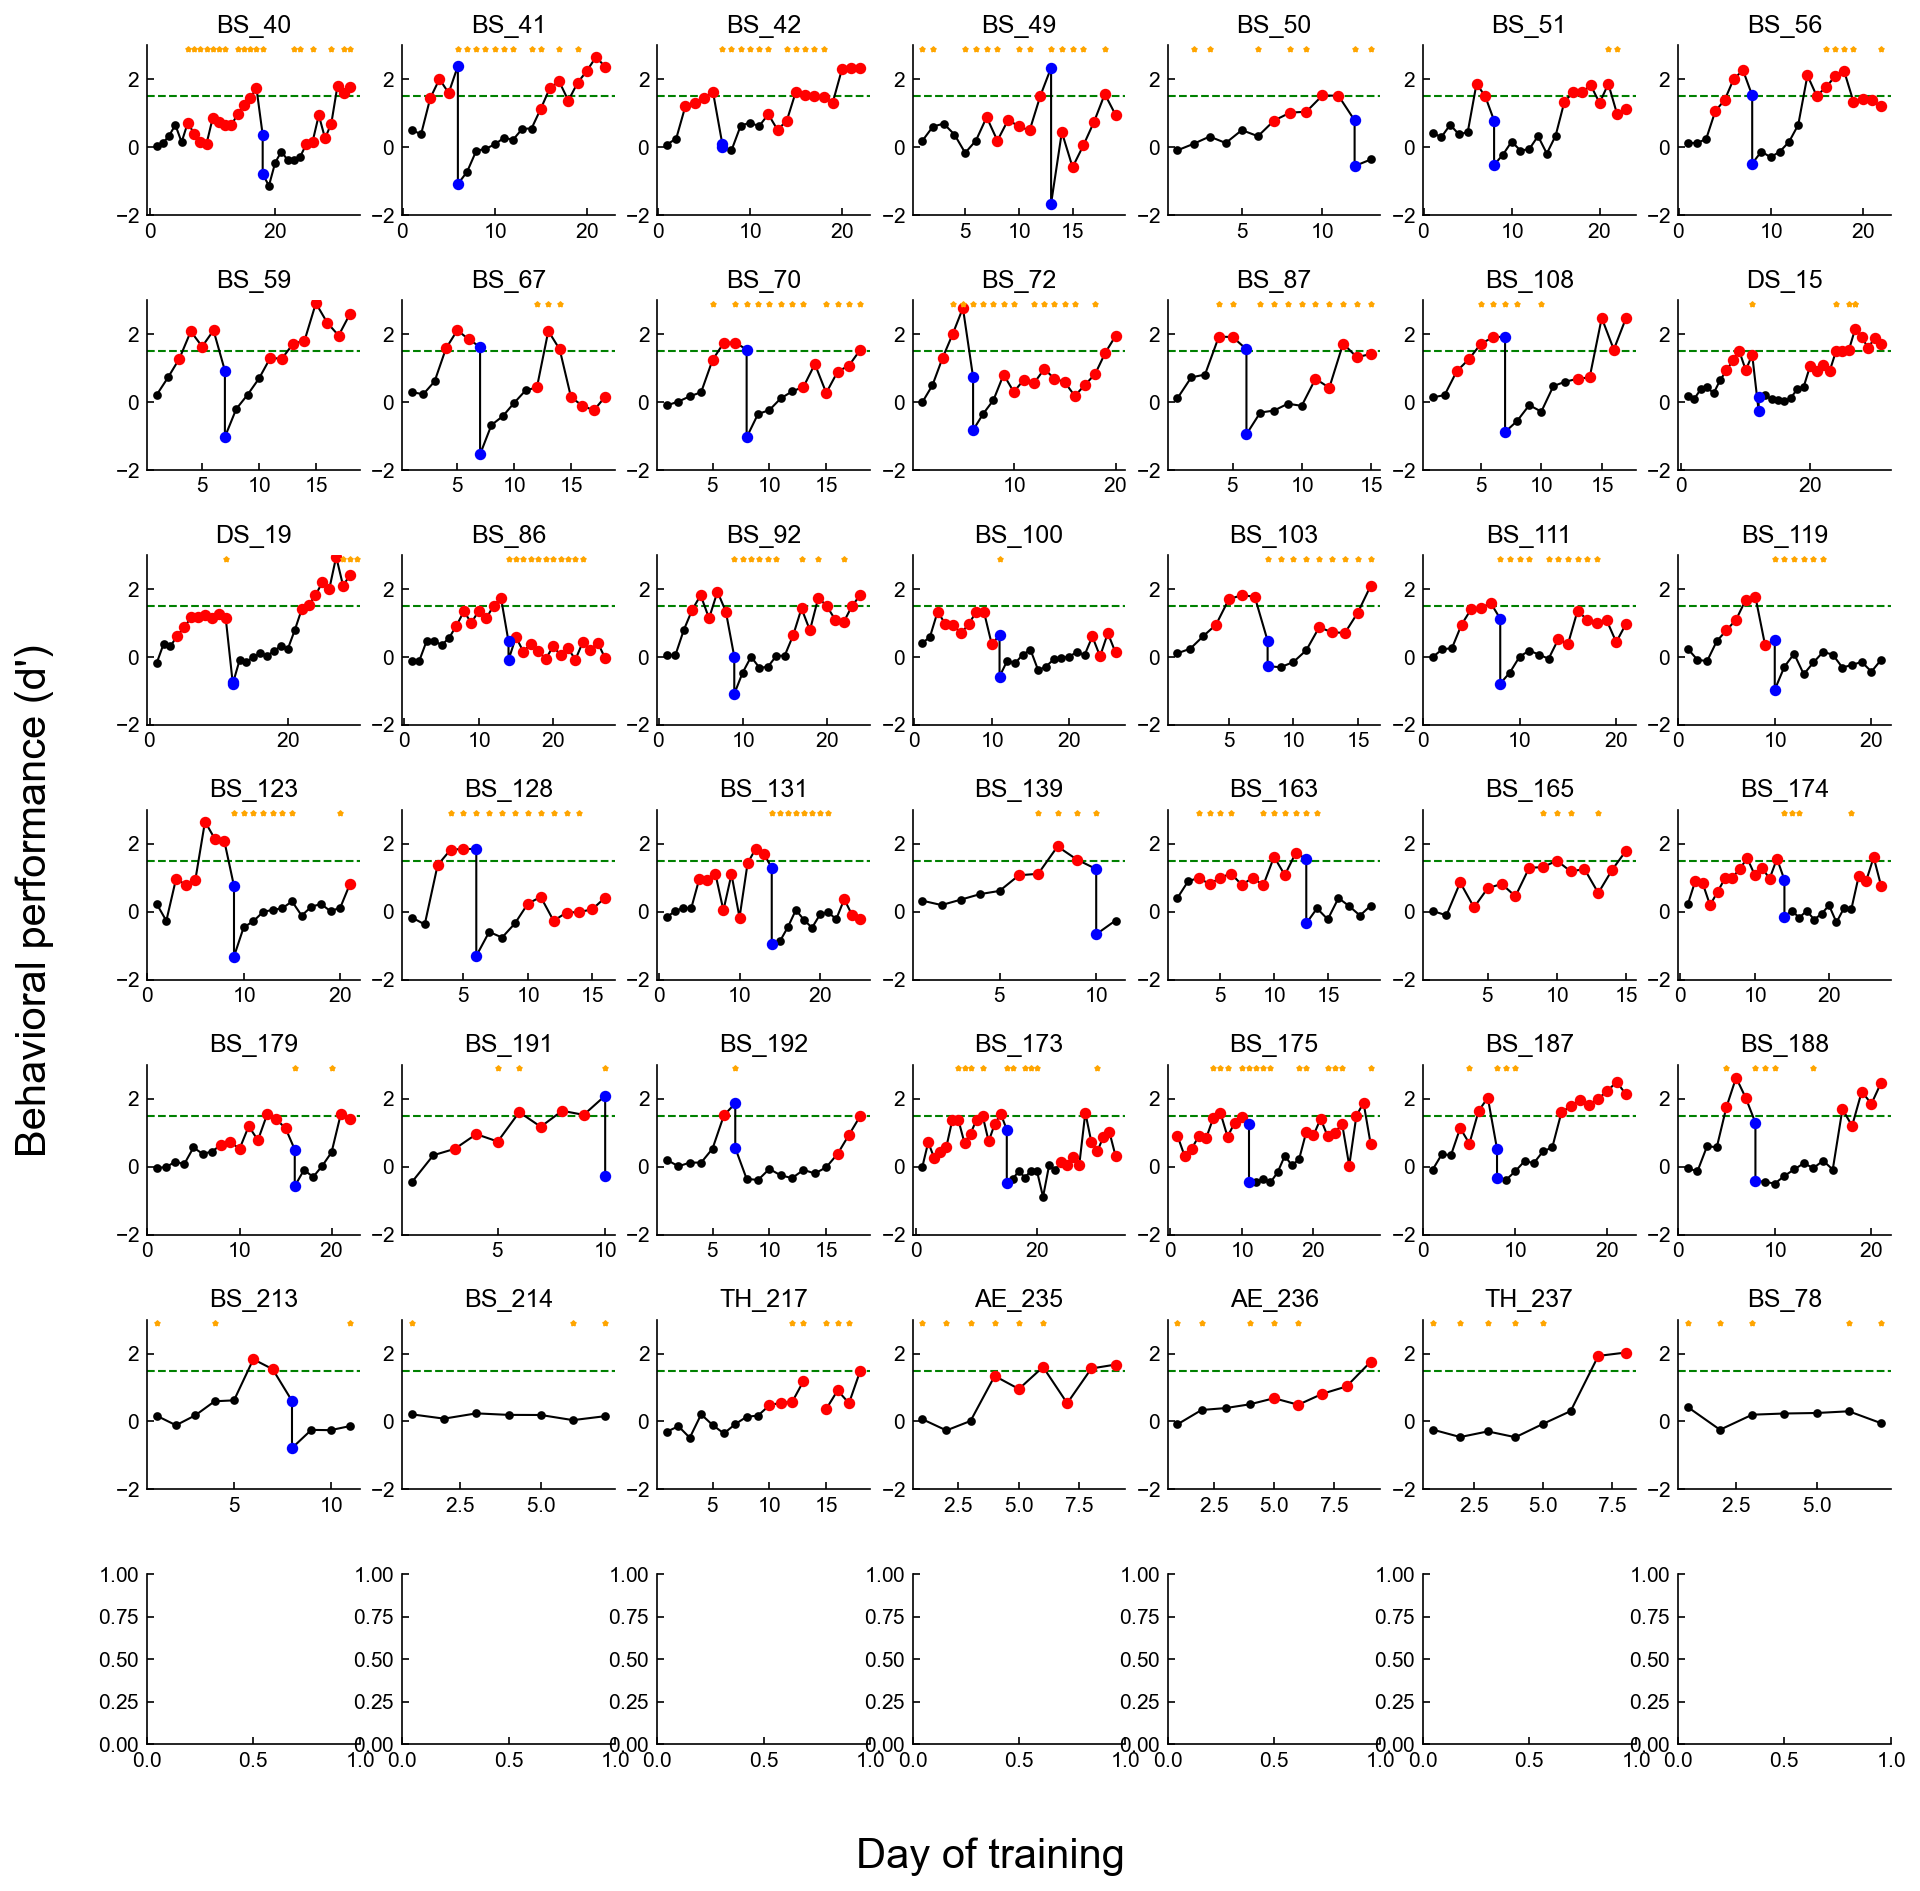

In [26]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
#filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(7,7,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(7),range(7))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    cond = csv[condname]
    cond_pc = csv[pc_condname]
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    #plt.savefig(os.path.join('D:\\\\TempFigures','EIL Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [14]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task == 'passive no behavior':
        continue
        
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
        
    if sessionfile.meta.region != 'AC':
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 533/533 [00:02<00:00, 185.22it/s]


In [15]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.region != 'AC':
        continue
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 3028/3028 [00:18<00:00, 160.69it/s]

errors for: ['BS_108' 'BS_113' 'BS_33' 'BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51'
 'BS_56' 'BS_67' 'BS_70' 'BS_72' 'BS_73' 'BS_78' 'BS_83' 'BS_85' 'BS_87'
 'BS_95' 'DS_15' 'DS_16' 'DS_17' 'DS_19' 'DS_22' 'DS_27' 'DS_28']


In [29]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

ramping_preearly = []
ramping_prelate = []
ramping_preexpert = []
ramping_postearly = []
ramping_postlate = []
ramping_postexpert = []

category_preearly = []
category_prelate = []
category_preexpert = []
category_postearly = []
category_postlate = []
category_postexpert = []

animalstouse = np.concatenate((dualanimalnames,unuseddualanimals,tuninganimalnames))
print(animalstouse)

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

EnumCategory = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #if not regions[idx] == 'AC':
    #    continue
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    if not sessionfile.meta.animal in animalstouse:
        continue
    if sessionfile.meta.animal in tuninganimalnames:
        continue
    #if sessionfile.meta.animal == 'TH_217':
    #    continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    if not hasattr(sessionfile.responsiveness[clust]['all_trials'],'rampingMod'):
        continue
    
    #p_ev,p_sup,p_ncr = calculate_NCR_CR_pval(sessionfile,clust)
    #category = 'Inconclusive'
    #if p_ev > 0.95 or p_sup > 0.95:
    #    if np.abs(sessionfile.responsiveness[clust]['slow_go_response'].rampingModNorm > 0.5):
    #        category = 'Both'
    #    else:
    #        category = 'Stimulus'
    #elif p_ncr > 0.95:
    #    if np.abs(sessionfile.responsiveness[clust]['go_response'].rampingModNorm > 0.5):
    #        category = 'Ramping'
    #    else:
    #        category = 'NCR'
    #EnumCategory.append(category)
    #    
    ##if not sessionfile.meta.animal in ['BS_213','BS_214']:
    ##    continue
    #
    ##else:
    ##    print(ilep.generateDateString(sessionfile))
    ##    print(len(sessionfile.clusters.good))
    #    
    ##if np.isnan(accuracies[idx]):
    ##    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_preearly.append(category)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_prelate.append(category)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_preexpert.append(category)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_preexpert.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_postearly.append(category)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_postlate.append(category)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget'].FR)
        ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        #category_postexpert.append(category)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #FRt_postexpert.append( (sessionfile.responsiveness[clust]['target'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

FRt_preearly = np.array(FRt_preearly)
FRt_prelate = np.array(FRt_prelate)
FRt_preexpert = np.array(FRt_preexpert)
FRt_postearly = np.array(FRt_postearly)
FRt_postlate = np.array(FRt_postlate)
FRt_postexpert = np.array(FRt_postexpert)

ramping_preearly = np.array(ramping_preearly)
ramping_prelate = np.array(ramping_prelate)
ramping_preexpert = np.array(ramping_preexpert)
ramping_postearly = np.array(ramping_postearly)
ramping_postlate = np.array(ramping_postlate)
ramping_postexpert = np.array(ramping_postexpert)

FRmodInd_preearly = np.sqrt(np.power(FRmod_preearly,2)+np.power(ramping_preearly,2))
FRmodInd_prelate = np.sqrt(np.power(FRmod_prelate,2)+np.power(ramping_prelate,2))
FRmodInd_preexpert = np.sqrt(np.power(FRmod_preexpert,2)+np.power(ramping_preexpert,2))
FRmodInd_postearly = np.sqrt(np.power(FRmod_postearly,2)+np.power(ramping_postearly,2))
FRmodInd_postlate = np.sqrt(np.power(FRmod_postlate,2)+np.power(ramping_postlate,2))
FRmodInd_postexpert = np.sqrt(np.power(FRmod_postexpert,2)+np.power(ramping_postexpert,2))

ramping_preearly = ramping_preearly[np.isfinite(ramping_preearly)]
ramping_prelate = ramping_prelate[np.isfinite(ramping_prelate)]
ramping_preexpert = ramping_preexpert[np.isfinite(ramping_preexpert)]
ramping_postearly = ramping_postearly[np.isfinite(ramping_postearly)]
ramping_postlate = ramping_postlate[np.isfinite(ramping_postlate)]
ramping_postexpert = ramping_postexpert[np.isfinite(ramping_postexpert)]

FRmodInd_preearly = FRmodInd_preearly[np.isfinite(FRmodInd_preearly)]
FRmodInd_prelate = FRmodInd_prelate[np.isfinite(FRmodInd_prelate)]
FRmodInd_preexpert = FRmodInd_preexpert[np.isfinite(FRmodInd_preexpert)]
FRmodInd_postearly = FRmodInd_postearly[np.isfinite(FRmodInd_postearly)]
FRmodInd_postlate = FRmodInd_postlate[np.isfinite(FRmodInd_postlate)]
FRmodInd_postexpert = FRmodInd_postexpert[np.isfinite(FRmodInd_postexpert)]

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

18it [00:00, 166.63it/s]

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19' 'BS_78' 'BS_173'
 'BS_175' 'BS_187' 'BS_188' 'BS_213' 'BS_214' 'TH_217' 'AE_235' 'AE_236'
 'TH_237']


3028it [00:19, 154.96it/s]


# Decoding Results

In [50]:
stim_resp_df = pd.read_csv(stimrespdecodingfilename)
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
stim_buffer_df = pd.read_csv(stimbufferdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_buffer_df,choice_df])
#dec_df.set_index(['session'])#,'clust','categories'])

In [51]:
def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
getDataPoint(dec_df,'BS_108_1_AC.pickle',9,'stimulus','accuracy')

0.5287435897435896

(array([  1.,   0.,   3.,  17.,  47.,  71., 105., 156., 220., 308., 395.,
        510., 682., 851., 885., 834., 713., 561., 419., 334., 275., 225.,
        202., 166., 160., 123., 120.,  94., 110.,  92.,  79.,  56.,  43.,
         44.,  28.,  27.,  23.,  17.,  14.,  21.,   8.,  13.,   8.,   8.,
          4.,   4.,   9.,   6.,   6.,   6.,  10.,   5.,   4.,   4.,   3.,
          1.,   5.,   2.,   3.,   3.,   2.,   7.,   0.,   0.,   1.,   0.,
          0.,   1.,   0.,   1.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.0002963 , 0.00047752, 0.00065874, 0.00083996, 0.00102118,
        0.0012024 , 0.00138362, 0.00156483, 0.00174605, 0.00192727,
        0.00210849, 0.00228971, 0.00247093, 0.00265215, 0.00283336,
        0.00301458, 0.0031958 , 0.00337702, 0.00355824, 0.00373946,
        0.00392067, 0.00410189, 0.00428311, 0.

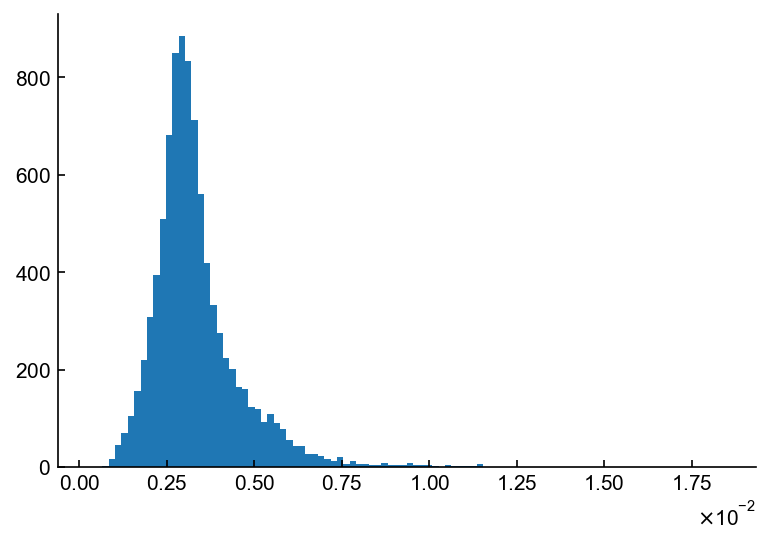

In [54]:
plt.hist(dec_df['accuracy_sem'],bins=100)

In [91]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','accuracy')
    
    stim_accuracy_c = getDataPoint(dec_df,session,clust,'stimulus','shuffled_control_accuracy')
    choice_accuracy_c = getDataPoint(dec_df,session,clust,'response','shuffled_control_accuracy')
    
    stim_accuracy_s = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_accuracy')
    choice_accuracy_s = getDataPoint(dec_df,session,clust,'response','synthetic_control_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    stim_acc_c.append(stim_accuracy_c)
    choice_acc_c.append(choice_accuracy_c)
    
    stim_acc_s.append(stim_accuracy_s)
    choice_acc_s.append(choice_accuracy_s)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    #sessionfile = ilep.loadSessionCached(act_directory,session)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
stim_acc_c = np.array(stim_acc_c)
choice_acc_c = np.array(choice_acc_c)
stim_acc_s = np.array(stim_acc_s)
choice_acc_s = np.array(choice_acc_s)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1440it [00:16, 89.96it/s]


In [75]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getOldDataPoint(old_dec_df,session,clust,'accuracies')
    #choice_accuracy = getOldDataPoint(dec_df,session,clust,'response','accuracy')
    
    stim_accuracy_c = getOldDataPoint(old_dec_df,session,clust,'caccuracies')
    #choice_accuracy_c = getOldDataPoint(dec_df,session,clust,'response','shuffled_control_accuracy')
    
    #stim_accuracy_s = getOldDataPoint(old_dec_df,session,clust,'saccuracies')
    #choice_accuracy_s = getOldDataPoint(dec_df,session,clust,'response','synthetic_control_accuracy')
    
    pvalue_stim_s = getOldDataPoint(old_dec_df,session,clust,'pvals')
    #pvalue_choice_s = getOldDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    #pvalue_stim_c = getOldDataPoint(old_dec_df,session,clust,'pval_c')
    #pvalue_choice_c = getOldDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    #choice_acc.append(choice_accuracy)
    
    stim_acc_c.append(stim_accuracy_c)
    #choice_acc_c.append(choice_accuracy_c)
    
    stim_acc_s.append(stim_accuracy_s)
    #choice_acc_s.append(choice_accuracy_s)
    
    pval_stim_s.append(pvalue_stim_s)
    #pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    #pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
stim_acc_c = np.array(stim_acc_c)
choice_acc_c = np.array(choice_acc_c)
stim_acc_s = np.array(stim_acc_s)
choice_acc_s = np.array(choice_acc_s)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1440it [00:02, 493.55it/s]


# Calculate Task Encoder Cutoff

In [92]:
low_decoders = np.less(stim_acc,0.5)
low_accuracies = stim_acc[low_decoders]
low_magnitudes = np.absolute(low_accuracies-0.5)

low_magnitudes = np.sort(low_magnitudes)
task_encoder_threshold_s = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
print('Stimulus task encoder threshold: '+str(task_encoder_threshold_s))

is_finite_s = np.isfinite(stim_acc)
is_valid_pval_s = np.less(pval_stim_s,0.05)#np.logical_and(np.less(pval_stim_s,0.05) , np.less(pval_stim_c,0.05))
is_TE_s = np.greater_equal(stim_acc,task_encoder_threshold_s)
is_TE_s = np.logical_and(is_TE_s,is_finite_s)
is_TE_s = np.logical_and(is_TE_s,is_valid_pval_s)

Stimulus task encoder threshold: 0.5738461538461538


In [93]:
low_decoders = np.less(choice_acc,0.5)
low_accuracies = choice_acc[low_decoders]
low_magnitudes = np.absolute(low_accuracies-0.5)

low_magnitudes = np.sort(low_magnitudes)
task_encoder_threshold_c = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
print('Choice task encoder threshold: '+str(task_encoder_threshold_c))

is_finite_c = np.isfinite(choice_acc)
is_valid_pval_c = np.less(pval_choice_s,0.05)#np.logical_and(np.less(pval_stim_s,0.05) , np.less(pval_stim_c,0.05))
is_TE_c = np.greater_equal(choice_acc,task_encoder_threshold_c)
is_TE_c = np.logical_and(is_TE_c,is_finite_c)
is_TE_c = np.logical_and(is_TE_c,is_valid_pval_c)

Choice task encoder threshold: 0.9212432432432434


Median  of TEs is 0.6153929411764706
Percent of TEs is 0.21805555555555556
Number  of TEs is 314


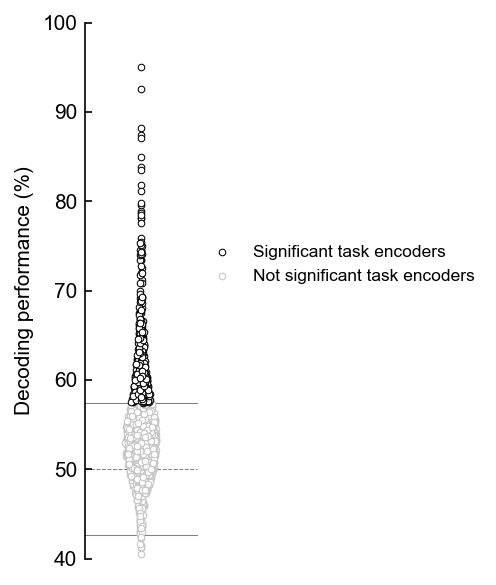

In [94]:
fig, ax = plt.subplots(figsize=(3,4))

X = np.ones_like(stim_acc)
_,Y = ilep.violin(X,stim_acc)
X,_ = ilep.violin(X,np.log10(stim_acc),width=0.35)

is_TE = is_TE_s
size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=-1,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0.4,1])
ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
ax.set_yticklabels(['40','50','60','70','80','90','100'])

ax.axhline(task_encoder_threshold_s,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5-(task_encoder_threshold_s-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
#ax.axhline(np.median(stim_acc[is_TE_s]),xmax=0.5,color='green')

print(f"Median  of TEs is {np.median(stim_acc[is_TE_s])}")
print(f"Percent of TEs is {np.mean(is_TE_s)}")
print(f"Number  of TEs is {np.sum(is_TE_s)}")

ax.legend(frameon=False,loc=(0.5,0.5))

ax.set_ylabel('Decoding performance (%)')
ax.spines['bottom'].set_visible(False)


plt.tight_layout()
#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Stimulus task encoders schematic.pdf'),transparent=False,facecolor="white")

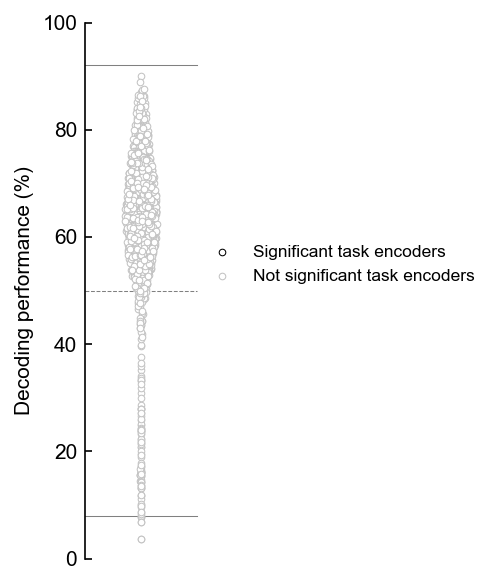

In [37]:
fig, ax = plt.subplots(figsize=(3,4))

X = np.ones_like(choice_acc)
_,Y = ilep.violin(X,choice_acc)
X,_ = ilep.violin(X,np.log10(choice_acc),width=0.35)

is_TE = is_TE_c
size=10
ax.scatter(X[is_TE], Y[is_TE], s=size, ec='black', fc='white', lw=0.5,zorder=0,label='Significant task encoders')
ax.scatter(X[np.logical_not(is_TE)], Y[np.logical_not(is_TE)], s=size, ec='#C3C3C3', fc='white', lw=0.5,zorder=-1,label='Not significant task encoders')

ax.set_xlim([0.5,2.5])
ax.set_xticks([])

ax.set_ylim([0,1])
ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax.set_yticklabels(['0','20','40','60','80','100'])
#ax.set_yticks([0.4,0.5,0.6,0.7,0.8,0.9,1])
#ax.set_yticklabels(['40','50','60','70','80','90','100'])

ax.axhline(task_encoder_threshold_c,linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5,linestyle='--',color='grey',zorder=-10,lw=0.5,xmax=0.5)
ax.axhline(0.5-(task_encoder_threshold_c-0.5),linestyle='-',color='grey',zorder=-10,lw=0.5,xmax=0.5)

ax.legend(frameon=False,loc=(0.5,0.5))

ax.set_ylabel('Decoding performance (%)')
ax.spines['bottom'].set_visible(False)

plt.tight_layout()
plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Choice task encoders schematic.pdf'),transparent=False,facecolor="white")

In [39]:
EILphases

array(['pre expert', 'pre expert', 'pre expert', ..., 'nan', 'nan', 'nan'],
      dtype='<U18')

# Task Encoder Figures

In [95]:
pc_task_encoders = np.array([np.nan]*6)
total_phases = ['pre early','pre late','pre expert','post early','post late','post expert']
labels = ['Early','Late','Expert','Early','Late','Expert']
for phase_idx,phase in enumerate(total_phases):
    
    te_in_phase = 0
    cells_in_phase = 0
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        sessionfile = ilep.loadSessionCached(act_directory,session)

        if sessionfile.meta.animal == 'BS_49' and sessionfile.meta.day_of_training >= 19: # Drops below expert + other complications with data
            continue
        if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13: # Pre-reversal only
            continue
        if sessionfile.meta.animal == 'BS_51' and sessionfile.meta.day_of_training >= 22: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_56' and sessionfile.meta.day_of_training >= 22:  # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15: # Drops below expert
            continue
        if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue
        if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3: # Pre early only
            continue

        if EILphases[idx] != phase:
            continue
            
        cells_in_phase += 1
        if is_TE[idx]:
            te_in_phase += 1
            
    print(f"n={te_in_phase}/{cells_in_phase}")
    
    pc_task_encoders[phase_idx] = np.sum(te_in_phase) / np.sum(cells_in_phase)

1440it [00:08, 160.75it/s]
17it [00:00, 161.87it/s]

n=35/175


1440it [00:08, 164.32it/s]
19it [00:00, 179.21it/s]

n=28/161


1440it [00:08, 164.13it/s]
18it [00:00, 179.96it/s]

n=35/117


1440it [00:08, 164.53it/s]
19it [00:00, 174.27it/s]

n=128/429


1440it [00:08, 161.69it/s]
14it [00:00, 112.02it/s]

n=47/219


1440it [00:09, 159.99it/s]

n=26/103


Text(4, -7.982793779389773, 'Post-rev')

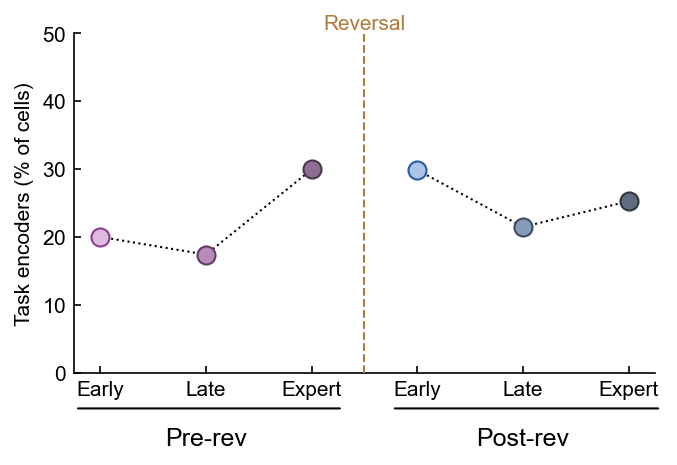

In [96]:
fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
#ax.scatter([0,1,2,3,4,5],pc_task_encoders*100,fc='white',ec=PHASE_COLORS,s=75)
for idx,pct in enumerate(pc_task_encoders):
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    ax.scatter(idx,pct*100,fc=eye_color,ec=border_color,s=75)
#ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.annotate('', xy=(0.0, -0.105), xycoords='axes fraction', xytext=(0.465, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.545, -0.105), xycoords='axes fraction', xytext=(1.0125, -0.105),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, -7.982793779389773, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, -7.982793779389773, 'Post-rev', ha='center', va='top',  fontsize=12)

#plt.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Task encoders over learning experimentalist learning phases.pdf'),transparent=False,facecolor="white")

Text(2.5, 50.0, 'Reversal')

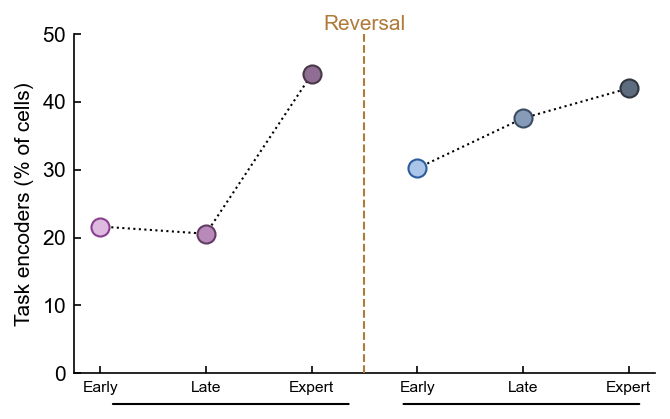

In [142]:
fig, ax = plt.subplots(figsize=(5,3))
chosen_color='k'
ax.plot([0,1,2],pc_task_encoders[0:3]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
ax.plot([3,4,5],pc_task_encoders[3:6]*100,color='k',linestyle=':',lw=1,alpha=1,zorder=-10)
#ax.scatter([0,1,2,3,4,5],pc_task_encoders*100,fc='white',ec=PHASE_COLORS,s=75)
for idx,pct in enumerate(pc_task_encoders):
    eye_color=PHASE_COLORS[idx]
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    border_color=colorsys.hls_to_rgb(h,l*0.5,s)

    summary_size=50
    summary_width=1
    
    ax.scatter(idx,pct*100,fc=eye_color,ec=border_color,s=75)
#ax.scatter([3,4,5],pc_task_encoders[3:6]*100,fc='white',ec=chosen_color,s=75)

ax.set_ylim([0,50])
ax.set_ylabel('Task encoders (% of cells)')

ax.set_xticks(range(6))
ax.set_xticklabels(labels,fontsize=7.5)

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.annotate('', xy=(0.06, -0.09), xycoords='axes fraction', xytext=(0.48, -0.09),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.56, -0.09), xycoords='axes fraction', xytext=(0.98, -0.09),arrowprops=dict(arrowstyle='-', color='black'))
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

#plt.savefig(os.path.join('D:\\\\Figures','Decoding Figures','Summaries','Task encoders over learning V2.pdf'),transparent=False,facecolor="white")

In [12]:
old_dec_df

Unnamed: 0            sessions  clusters  accuracies  accuracies_std  \
0              0  BS_108_1_AC.pickle         2    0.506237        0.073939   
1              1  BS_108_1_AC.pickle         8    0.669714        0.063877   
2              2  BS_108_1_AC.pickle         9    0.580048        0.068600   
3              3  BS_108_1_AC.pickle        14    0.553056        0.101431   
4              4  BS_108_1_AC.pickle        34    0.613846        0.067230   
...          ...                 ...       ...         ...             ...   
5796        5796  DS_22_21_AC.pickle        68    0.750420        0.075071   
5797        5797  DS_22_21_AC.pickle        70    0.487818        0.136287   
5798        5798  DS_22_21_AC.pickle        77    0.619077        0.080350   
5799        5799  DS_22_21_AC.pickle        79    0.574294        0.112926   
5800        5800  DS_22_21_AC.pickle        81    0.616290        0.107595   

      accuracies_sem  waccuracies  waccuracies_std  waccuracies_sem  \
0           0.000739     0.509235         0.074365         0.000744   
1           0.000639     0.697917         0.062533         0.000625   
2           0.000686     0.588562         0.068966         0.000690   
3           0.001014     0.565456         0.101573         0.001016   
4           0.000672     0.626492         0.066654         0.000667   
...              ...          ...              ...              ...   
5796        0.000751     0.774026         0.071707         0.000717   
5797        0.001363     0.489439         0.136922         0.001369   
5798        0.000804     0.634275         0.081150         0.000812   
5799        0.001129     0.594197         0.111676         0.001117   
5800        0.001076     0.634391         0.106047         0.001061   

      caccuracies  caccuracies_std  caccuracies_sem          pvals  \
0        0.500241         0.076425         0.000764   9.257512e-09   
1        0.501633         0.071393         0.000714   0.000000e+00   
2        0.498089         0.071717         0.000717   0.000000e+00   
3        0.496436         0.105494         0.001055  8.177478e-300   
4        0.499553         0.072406         0.000724   0.000000e+00   
...           ...              ...              ...            ...   
5796     0.500307         0.091842         0.000918   0.000000e+00   
5797     0.501866         0.144813         0.001448   2.938535e-11   
5798     0.503900         0.086853         0.000869   0.000000e+00   
5799     0.499012         0.118913         0.001189   0.000000e+00   
5800     0.499784         0.115736         0.001157   0.000000e+00   

      repetitions  
0            1000  
1            1000  
2            1000  
3            1000  
4            1000  
...           ...  
5796         1000  
5797         1000  
5798         1000  
5799         1000  
5800         1000  

[5801 rows x 14 columns]

In [49]:
def getOldDataPoint(df,session,clust,column):
    df = df[df['sessions']==session]
    df = df[df['clusters']==clust]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')
    
getOldDataPoint(old_dec_df,'BS_108_1_AC.pickle',9,'accuracies')

0.5800478723404254

In [48]:
old_dec_filename = 'D:\\MouseDatastimulusDecodingCached5801units2022-10-18FromCache.csv'
old_dec_df = pd.read_csv(old_dec_filename)

In [11]:
old_dec_filename_2 = 'D:\\MouseDatastimulusDecodingCached5632units2022-10-05.csv'
old_dec_df_2 = pd.read_csv(old_dec_filename_2)

In [14]:
dec = []
old_dec = []
old_dec_2 = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    dec.append(getDataPoint(dec_df,session,clust,'stimulus','accuracy'))
    old_dec.append(getOldDataPoint(old_dec_df,session,clust,'accuracies'))
    old_dec_2.append(getOldDataPoint(old_dec_df_2,session,clust,'accuracies'))
    
old_dec = np.array(old_dec)
old_dec_2 = np.array(old_dec_2)
dec = np.array(dec)

3028it [00:07, 420.88it/s]


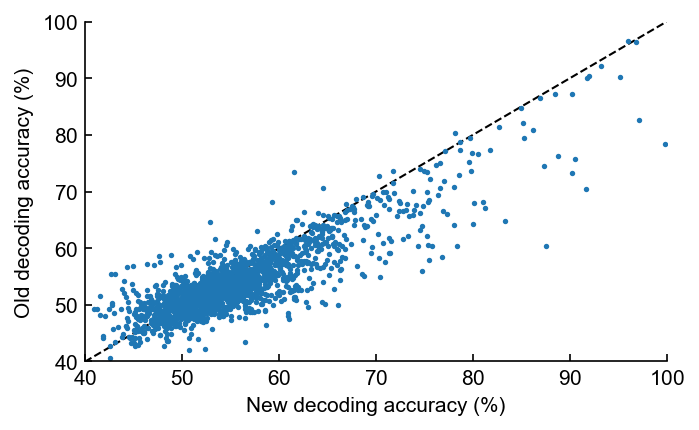

In [17]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(100*dec,100*old_dec,s=2.5)
ax.plot([0,100],[0,100],c='k',linestyle='--',lw=1,zorder=-1)
ax.set_xlim([40,100])
ax.set_ylim([40,100])
ax.set_xlabel('New decoding accuracy (%)')
ax.set_ylabel('Old decoding accuracy (%)')
plt.savefig(os.path.join('D:\\\\TempFigures','Trimmed whole-trial decoding vs old decoding.pdf'),transparent=False,facecolor="white")

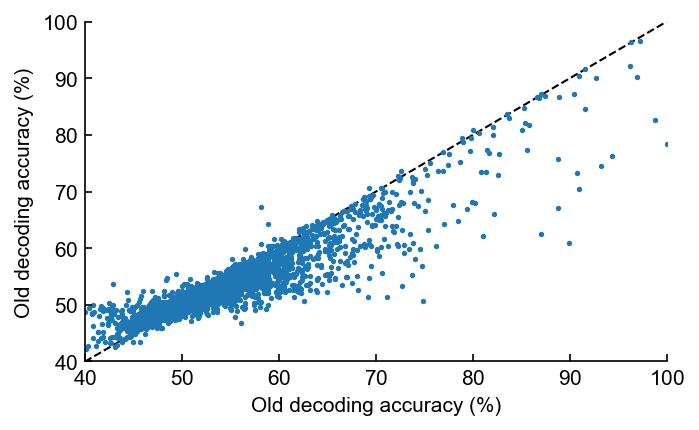

In [16]:
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(100*old_dec_2,100*old_dec,s=2.5)
ax.plot([0,100],[0,100],c='k',linestyle='--',lw=1,zorder=-1)
ax.set_xlim([40,100])
ax.set_ylim([40,100])
ax.set_xlabel('Old decoding accuracy (%)')
ax.set_ylabel('Old decoding accuracy (%)')
plt.savefig(os.path.join('D:\\\\TempFigures','Old decoding vs old decoding.pdf'),transparent=False,facecolor="white")

1440it [00:00, 4773.34it/s]
1440it [00:00, 5141.68it/s]
1440it [00:00, 7091.74it/s] 
1440it [00:00, 1932.43it/s]
1440it [00:00, 3808.64it/s]
1440it [00:00, 7867.02it/s]


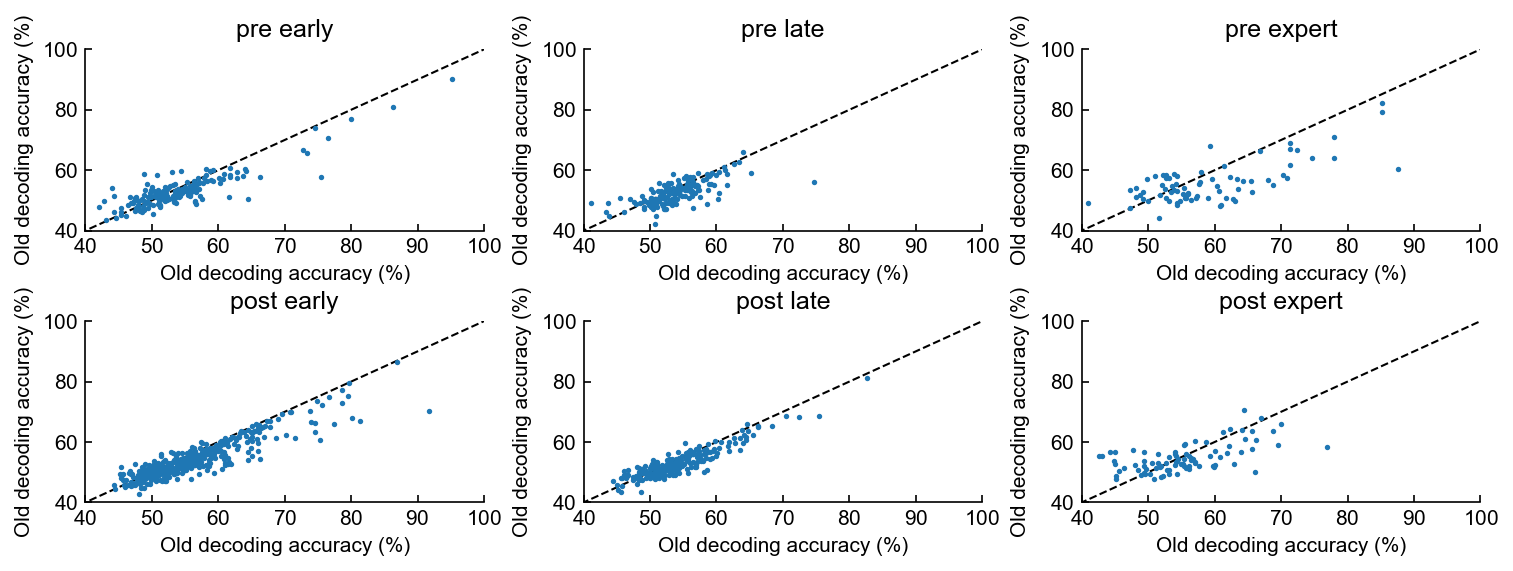

In [64]:
fig = plt.figure(figsize=(12,4))
gs = fig.add_gridspec(2,3,wspace=0.25,hspace=0.5)
axs = [plt.subplot(gs[i,j]) for i,j in product(range(2),range(3))]
    
for phase_idx,phase in enumerate(['pre early','pre late','pre expert','post early','post late','post expert']):

    dec = []
    old_dec = []
    for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
        if EILphases[idx] == phase:
            dec.append(getDataPoint(dec_df,session,clust,'stimulus','accuracy'))
            old_dec.append(getOldDataPoint(old_dec_df,session,clust,'accuracies'))
    dec = np.array(dec)
    old_dec = np.array(old_dec)
    
    ax = axs[phase_idx]
    ax.set_title(phase)
    
    ax.scatter(100*dec,100*old_dec,s=2.5)
    ax.plot([0,100],[0,100],c='k',linestyle='--',lw=1,zorder=-1)
    ax.set_xlim([40,100])
    ax.set_ylim([40,100])
    ax.set_xlabel('Old decoding accuracy (%)')
    ax.set_ylabel('Old decoding accuracy (%)')

In [76]:
ymax = np.log10(3)
ymin = np.log10(1.4)
yrange = ymax-ymin
print(yrange)
oldval = np.log10(1.265)
print(oldval)
olddisp = oldval - ymin
print(olddisp)
olddispfrac = olddisp / yrange
print(olddispfrac)

ymin2 = 0#np.log10(0.1)
ymax2 = 1#np.log10(200)
yrange2 = ymax2-ymin2
print(yrange2)
newval = olddispfrac * yrange2 + ymin2
print(newval)
#ax.text(xtick_pos_pre, np.log10(1.265), 'Pre-rev', ha='center', va='top', fontsize=12)

0.3309932190414244
0.10209052551183669
-0.044037510166401325
-0.13304656298982956
1
-0.13304656298982956


In [15]:
def getCondandPCCond(animalBehaviors,animal,days):
    cond = np.full_like(days,np.nan,dtype='float')
    cond_pc = np.full_like(days,np.nan,dtype='float')
    if not animal in animalBehaviors:
        return cond,cond_pc
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    for idx,day in enumerate(days):
        if hasattr(animalBehaviors[animal],'reversal') and day > animalBehaviors[animal].reversal:
            day-=1
            
        if not day in animalBehaviors[animal].sessions:
            continue
            
        ########## Pre/Postreversal ##########
        if day < reversal or day > reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            valid_trials_mask = ilep.getActiveTrials(outcomes)
            outcomes = outcomes[valid_trials_mask]

            hit = np.sum(np.equal(outcomes,1))
            miss = np.sum(np.equal(outcomes,2))
            falarm = np.sum(np.equal(outcomes,3))
            creject = np.sum(np.equal(outcomes,4))

            pc = (hit+creject)/(hit+miss+falarm+creject)
            dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
            #print(dp)

            cond[idx] = dp
            cond_pc[idx] = pc
            
        ########## Switch ##########
        if day == reversal:
            outcomes = np.array(list(animalBehaviors[animal].sessions[day].outcomes))
            valid_trials_mask = ilep.getActiveTrials(outcomes)
            outcomes = outcomes[valid_trials_mask]
            
    return cond,cond_pc

BS_40
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]
6


<ipython-input-15-291c246ad6b1>:29: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


NameError: name 'training_days_recorded' is not defined

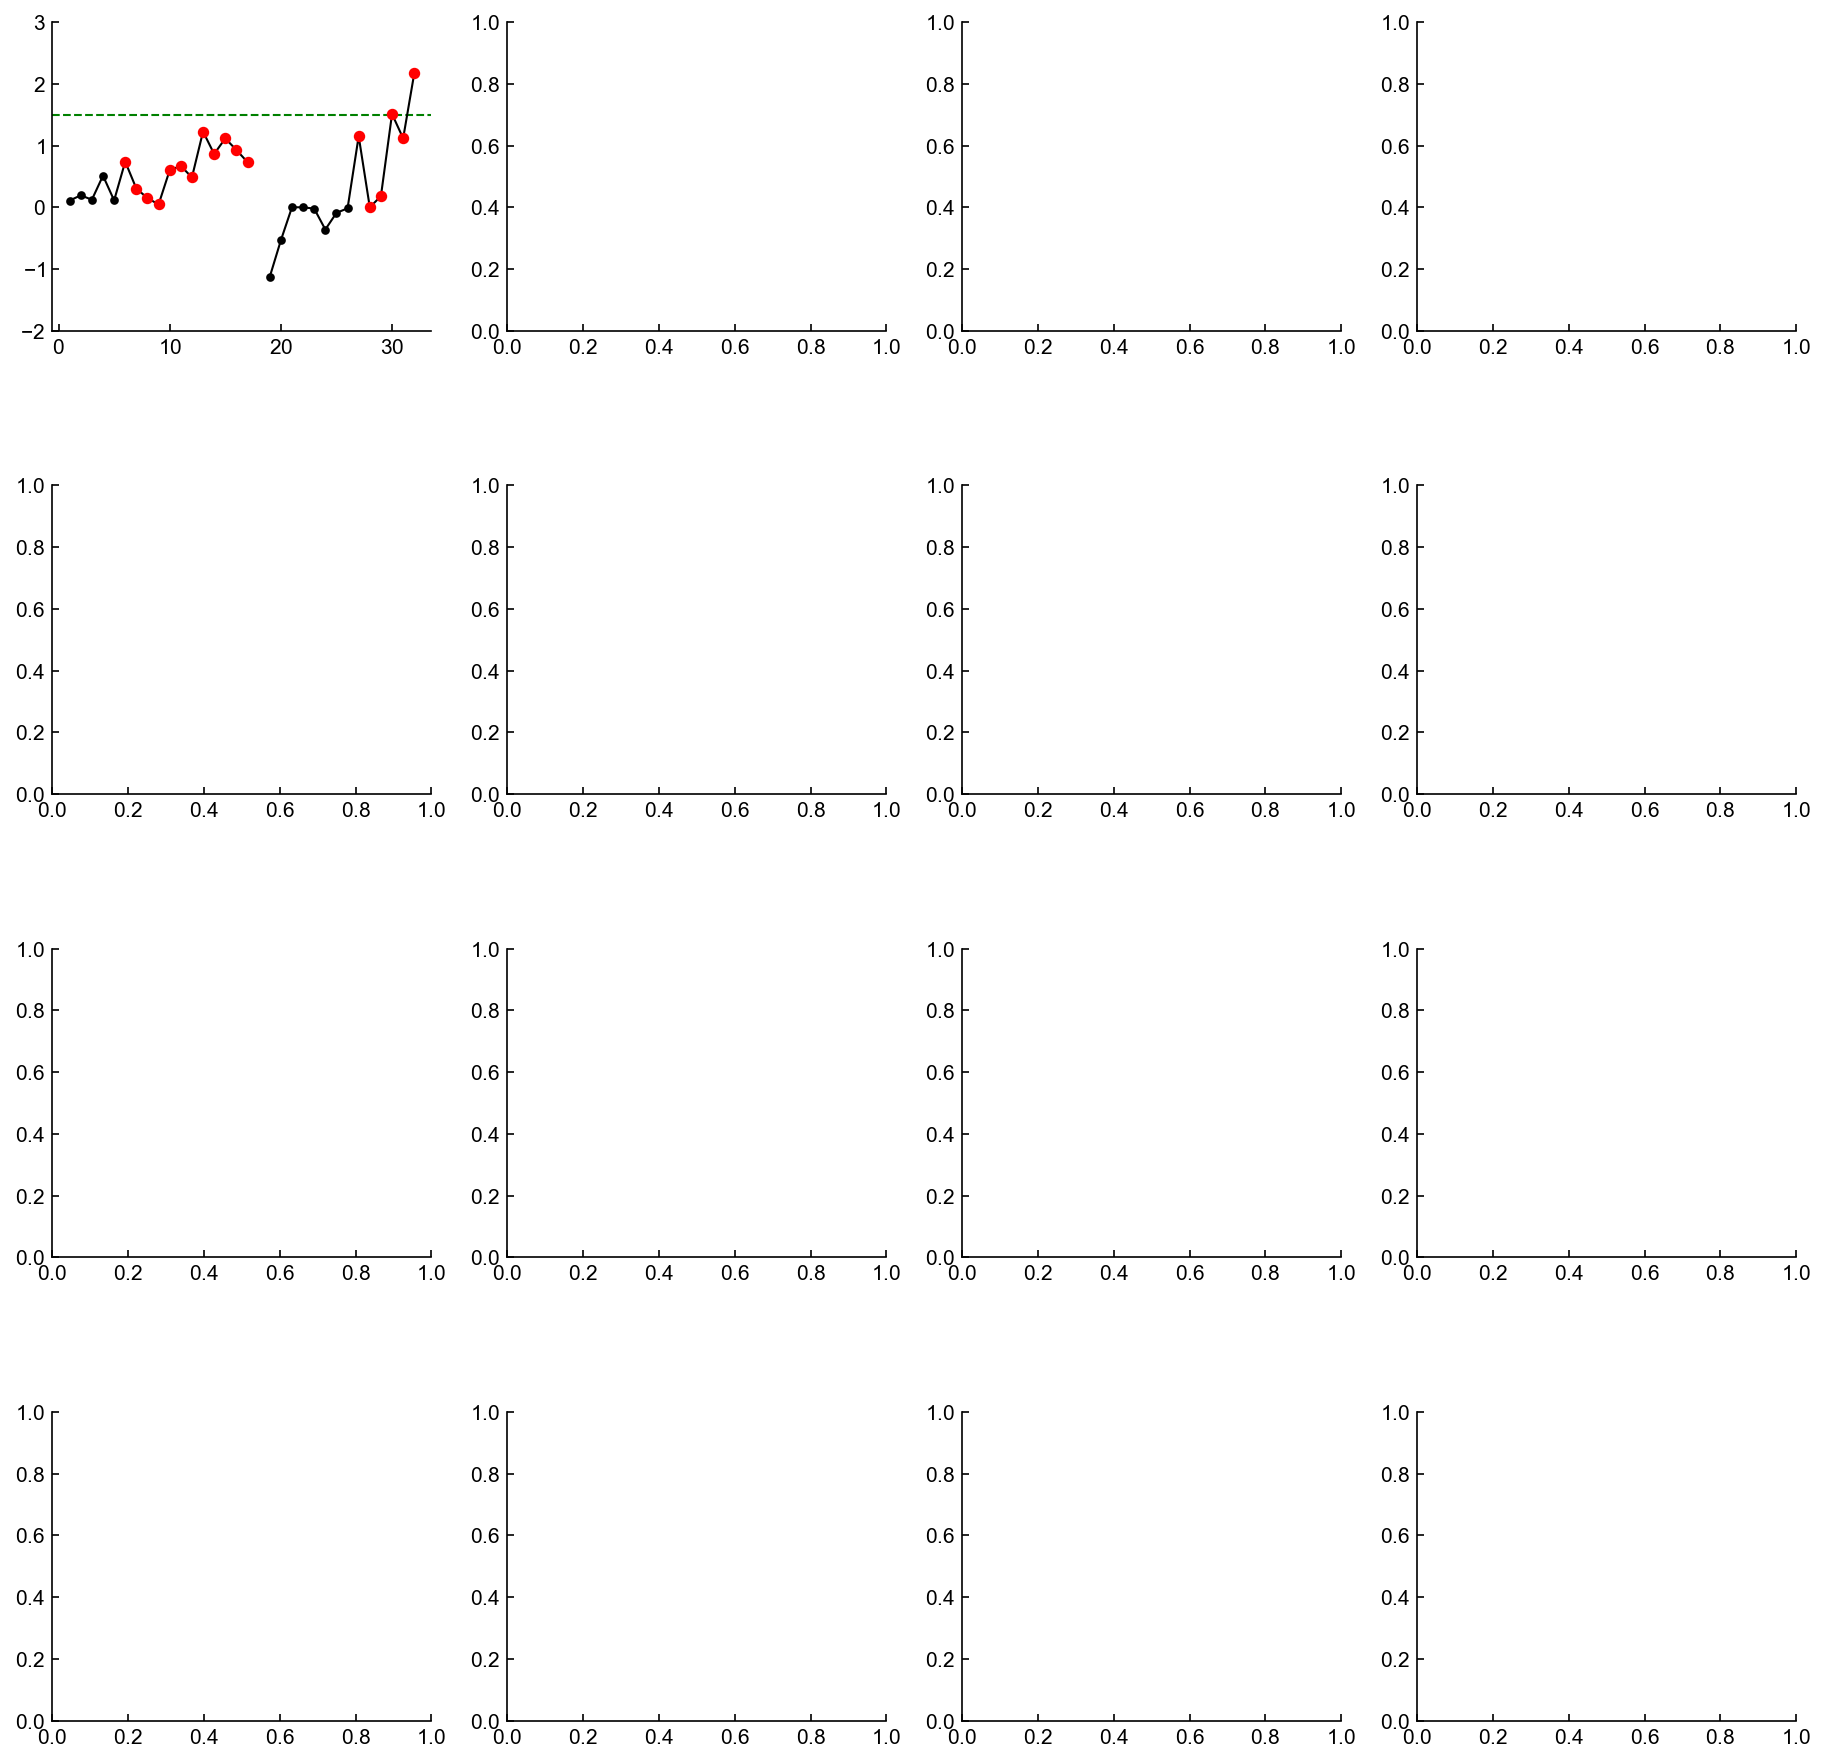

In [16]:
filename = os.path.join('C:\\\\Users','insan','Desktop','DataForJMTTotal.csv')
#filename = os.path.join('D:\\\\DataForJMTTotal.csv')
csv = pd.read_csv(filename)

prethresholds = dict()
postthresholds = dict()

plot=True
if plot:
    fig = plt.figure(figsize=(15,15))
    gs = fig.add_gridspec(4,4,hspace=0.5)
    axs = [plt.subplot(gs[i,j]) for i,j in product(range(4),range(4))]
    #plt.delaxes(axs[14])
    #plt.delaxes(axs[15])

premiddlecutoffs = dict()
postmiddlecutoffs = dict()
PERphases = dict()

for animalidx,animal in enumerate(animals):
    print(animal)
    PERphases[animal] = dict()
    
    condname = 'd\' ' + animal
    pc_condname = 'Percent correct ' + animal
    days = np.array(list(csv['Day']))
    print(days) # This is 1 indexed and does not yet subtract one for reversal
    #cond = csv[condname]
    #cond_pc = csv[pc_condname]
    cond,cond_pc = getCondandPCCond(animalBehaviors,animal,days)
    
    #Correct for double reversal days
    for idx,day in enumerate(days):
        if day > animals[animal].reversal:
            days[idx] = day-1
            
        if day > animals[animal].reversal+1: #  +1 because the csv stores the switch day as two entries
            #Calculate PERphase
            PC = cond_pc[idx]
            if PC <= 47.5:
                PERphases[animal][day-1] = 'perseveration'
            elif PC >= 52.5:
                PERphases[animal][day-1] = 'refinement'
            else:
                PERphases[animal][day-1] = 'exploration'
            
    #days = days - animals[animal].reversal
    
    prereversaldays = []
    prereversaldps = []
    maxreversaldp = -np.Inf
    minreversaldp = np.Inf
    postreversaldays = []
    postreversaldps = []
    for idx,day in enumerate(days):
        if day < animals[animal].reversal or np.isnan(animals[animal].reversal):
            prereversaldays.append(day)
            prereversaldps.append(cond[idx])
        if day == animals[animal].reversal:
            maxreversaldp = max(cond[idx],maxreversaldp)
            minreversaldp = min(cond[idx],minreversaldp)
        if day > animals[animal].reversal and not np.isnan(cond[idx]):
            postreversaldays.append(day)
            postreversaldps.append(cond[idx])
            
    #Prereversal threshold
    maxperf = np.nanmax(np.concatenate((prereversaldps,[1.5])))
    minperf = np.nanmin(prereversaldps)
    prethreshold = minperf + 0.4*(maxperf-minperf)
    #Postreversal threshold
    try:
        maxperf = np.nanmax(np.concatenate((postreversaldps,[1.5])))
        minperf = np.nanmin(postreversaldps)
    except:
        print(animal+' has no post-reversal')
        maxperf = np.nan
        minperf = np.nan
    postthreshold = minperf + 0.4*(maxperf-minperf)
    
    prethresholds[animal] = prethreshold
    postthresholds[animal] = postthreshold
    
    prereversaldays = np.array(prereversaldays)
    prereversaldps = np.array(prereversaldps)
    postreversaldays = np.array(postreversaldays)
    postreversaldps = np.array(postreversaldps)
    
    premiddlebool = np.greater_equal(prereversaldps,prethreshold)
    for idx,day in enumerate(prereversaldays):
        if premiddlebool[idx]:
            premiddlebool[idx:(len(premiddlebool)-1)].fill(True)
        #if not premiddlebool[idx]:
        #    premiddlebool[0:idx].fill(False)
    if np.any(premiddlebool):
        premiddlefirstday = np.min(prereversaldays[premiddlebool])
    else:
        premiddlefirstday = np.Inf
        
    print(premiddlefirstday)
                     
    postmiddlebool = np.greater_equal(postreversaldps,postthreshold)
    for idx,day in enumerate(postreversaldays):
        if postmiddlebool[idx]:
            postmiddlebool[idx:(len(postmiddlebool)-1)].fill(True)
        #if not postmiddlebool[idx]:
        #    postmiddlebool[0:idx].fill(False)
    if np.any(postmiddlebool):
        postmiddlefirstday = np.min(postreversaldays[postmiddlebool])
    else:
        postmiddlefirstday = np.Inf
    
    if animal == 'BS_95':
        premiddlefirstday = 4
    if animal == 'BS_49':
        premiddlefirstday = 7
    if animal in ['BS_83','BS_50']:
        postmiddlefirstday = np.Inf
    
    premiddlecutoffs[animal] = premiddlefirstday
    postmiddlecutoffs[animal] = postmiddlefirstday
    
    if plot:
        ax = axs[animalidx]    
        #All Days no color
        ax.plot(days,cond,color='k',lw=1)
        ax.scatter(days,cond,color='k',s=10,zorder=9)
        #Pre Middle
        premiddle = np.logical_and( np.greater_equal(days,premiddlefirstday), np.less(days,animals[animal].reversal) )
        ax.scatter(days[premiddle],cond[premiddle],color='r',s=20,zorder=10)
        #Post Middle
        postmiddle = np.greater_equal(days,postmiddlefirstday)
        ax.scatter(days[postmiddle],cond[postmiddle],color='r',s=20,zorder=10)
        #Switch
        switch = np.equal(days,animals[animal].reversal)
        ax.scatter(days[switch],cond[switch],color='b',s=20,zorder=10)

        xlims = ax.get_xlim()
        ax.plot(xlims,[1.5,1.5],c='g',linestyle='--',lw=1,zorder=-10)
        ax.set_xlim(xlims)
        ax.set_ylim([-2,3])
        
        days_recorded = training_days_recorded[animal]
        ax.scatter(days_recorded,np.ones_like(days_recorded)*2.9,s=5,marker='*',color='orange',zorder=11)

        ax.set_title(animal)
        
fig.text(0.075, 0.5, 'Behavioral performance (d\')', ha='center', va='center', rotation='vertical',fontsize=20)
fig.text(0.5,0.075, 'Day of training', ha='center', va='center', rotation='horizontal',fontsize=20)

if plot:
    plt.savefig(os.path.join('D:\\\\TempFigures','Automated Learning Phases.pdf'),transparent=False,facecolor="white")
    pass

In [118]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in dualanimalnames:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 517/517 [00:04<00:00, 103.83it/s]


Old EILphases (excluded data)

In [119]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training < firstExpert.pre[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= premiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training < firstExpert.post[sessionfile.meta.animal] and sessionfile.meta.day_of_training >= postmiddlecutoffs[sessionfile.meta.animal]:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1288/1288 [00:07<00:00, 163.60it/s]

errors for: []


New EILphases (all data)

In [26]:
def getBehaviorFromRecording(sessionfile):
    hit = np.sum(np.logical_and(sessionfile.trials.target,sessionfile.trials.go))
    miss = np.sum(np.logical_and(sessionfile.trials.target,np.logical_not(sessionfile.trials.go)))
    falarm = np.sum(np.logical_and(np.logical_not(sessionfile.trials.target),sessionfile.trials.go))
    creject = np.sum(np.logical_and(np.logical_not(sessionfile.trials.target),np.logical_not(sessionfile.trials.go)))
    
    pc = (hit+creject)/(hit+miss+falarm+creject)
    dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
    
    return pc,dp

In [49]:
nEILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        pc,dp = getBehaviorFromRecording(sessionfile)
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            nEILphases[idx] = 'switch'
            
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and sessionfile.meta.day_of_training >= firstExpert.pre[sessionfile.meta.animal]:#pc>=0.7 and dp >= 1.5:
            nEILphases[idx] = 'pre expert'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and dp < prethresholds[sessionfile.meta.animal]:
            nEILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and dp >= prethresholds[sessionfile.meta.animal]:
            nEILphases[idx] = 'pre late'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and sessionfile.meta.day_of_training >= firstExpert.post[sessionfile.meta.animal]:#pc>=0.7 and dp >= 1.5:
            nEILphases[idx] = 'post expert'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and dp < postthresholds[sessionfile.meta.animal]:
            nEILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal'] and dp >= prethresholds[sessionfile.meta.animal]:
            nEILphases[idx] = 'post late'
            
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1440/1440 [00:09<00:00, 156.72it/s]

errors for: []


In [120]:
regions = np.full_like(EnumSession,np.nan)
for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    regions[idx] = sessionfile.meta.region

100%|██████████| 1288/1288 [00:08<00:00, 155.45it/s]


In [121]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

FRb_preearly = []
FRb_prelate = []
FRb_preexpert = []
FRb_postearly = []
FRb_postlate = []
FRb_postexpert = []

FRe_preearly = []
FRe_prelate = []
FRe_preexpert = []
FRe_postearly = []
FRe_postlate = []
FRe_postexpert = []

FReT_preearly = []
FReT_prelate = []
FReT_preexpert = []
FReT_postearly = []
FReT_postlate = []
FReT_postexpert = []

FReNT_preearly = []
FReNT_prelate = []
FReNT_preexpert = []
FReNT_postearly = []
FReNT_postlate = []
FReNT_postexpert = []

FRt_preearly = []
FRt_prelate = []
FRt_preexpert = []
FRt_postearly = []
FRt_postlate = []
FRt_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

animalstouse = np.concatenate((dualanimalnames,unuseddualanimals,tuninganimalnames))
print(animalstouse)

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not regions[idx] == 'AC':
        continue
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
            
    if not sessionfile.meta.animal in animalstouse:
        continue
    if sessionfile.meta.animal in tuninganimalnames:
        continue
    #if sessionfile.meta.animal == 'TH_217':
    #    continue
        
    if sessionfile.meta.animal == 'BS_67' and sessionfile.meta.day_of_training >= 15:
        continue
        
    if sessionfile.meta.animal == 'BS_50' and sessionfile.meta.day_of_training >= 13:
        continue
        
    if sessionfile.meta.animal == 'BS_78' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.meta.animal == 'BS_214' and sessionfile.meta.day_of_training >= 3:
        continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
        
    #if not sessionfile.meta.animal in ['BS_213','BS_214']:
    #    continue
    
    #else:
    #    print(ilep.generateDateString(sessionfile))
    #    print(len(sessionfile.clusters.good))
        
    #if np.isnan(accuracies[idx]):
    #    continue
        
    if EILphases[idx] == 'pre early':
        FRb_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        #temp = ( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        FRt_preearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )        
        #Dec_preearly.append(accuracies[idx])
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRb_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_prelate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_prelate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_preint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )                
        #Dec_preint.append(accuracies[idx])
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRb_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_preexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_preexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_prelate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_preexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_prelate.append(accuracies[idx])
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRb_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postearly.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postearly.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postearly.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postearly.append(accuracies[idx])
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRb_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postlate.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postlate.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postint.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postint.append(accuracies[idx])
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRb_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRbaseline)
        FRe_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FR)
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        FReT_postexpert.append(sessionfile.responsiveness[clust]['target_tone'].FR)
        FReNT_postexpert.append(sessionfile.responsiveness[clust]['nontarget_tone'].FR)
        #FRt_postlate.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / max(sessionfile.responsiveness[clust]['target_tone'].FRmodulation,sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation))
        FRt_postexpert.append( (sessionfile.responsiveness[clust]['target_tone'].FRmodulation-sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) / (sessionfile.responsiveness[clust]['target_tone'].FRmodulation+sessionfile.responsiveness[clust]['nontarget_tone'].FRmodulation) )
        #Dec_postlate.append(accuracies[idx])
        postexpert_animals.append(sessionfile.meta.animal)
        
FRb_preearly = np.array(FRb_preearly)
FRb_prelate = np.array(FRb_prelate)
FRb_preexpert = np.array(FRb_preexpert)
FRb_postearly = np.array(FRb_postearly)
FRb_postlate = np.array(FRb_postlate)
FRb_postexpert = np.array(FRb_postexpert)

FRe_preearly = np.array(FRe_preearly)
FRe_prelate = np.array(FRe_prelate)
FRe_preexpert = np.array(FRe_preexpert)
FRe_postearly = np.array(FRe_postearly)
FRe_postlate = np.array(FRe_postlate)
FRe_postexpert = np.array(FRe_postexpert)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

FReT_preearly = np.array(FReT_preearly)
FReT_prelate = np.array(FReT_prelate)
FReT_preexpert = np.array(FReT_preexpert)
FReT_postearly = np.array(FReT_postearly)
FReT_postlate = np.array(FReT_postlate)
FReT_postexpert = np.array(FReT_postexpert)

FReNT_preearly = np.array(FReNT_preearly)
FReNT_prelate = np.array(FReNT_prelate)
FReNT_preexpert = np.array(FReNT_preexpert)
FReNT_postearly = np.array(FReNT_postearly)
FReNT_postlate = np.array(FReNT_postlate)
FReNT_postexpert = np.array(FReNT_postexpert)

FRt_preearly = np.array(FRt_preearly)
FRt_prelate = np.array(FRt_prelate)
FRt_preexpert = np.array(FRt_preexpert)
FRt_postearly = np.array(FRt_postearly)
FRt_postlate = np.array(FRt_postlate)
FRt_postexpert = np.array(FRt_postexpert)

#Dec_preearly = np.array(Dec_preearly)
#Dec_preint = np.array(Dec_preint)
#Dec_prelate = np.array(Dec_prelate)
#Dec_postearly = np.array(Dec_postearly)
#Dec_postint = np.array(Dec_postint)
#Dec_postlate = np.array(Dec_postlate)

22it [00:00, 217.76it/s]

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'BS_78' 'BS_173' 'BS_175' 'BS_187'
 'BS_188' 'BS_213' 'BS_214' 'TH_217' 'AE_235' 'AE_236' 'TH_237']


1288it [00:08, 154.21it/s]


In [17]:
#number of animals in each learning phase

preearly_animals = np.unique(preearly_animals)
prelate_animals = np.unique(prelate_animals)
preexpert_animals = np.unique(preexpert_animals)
postearly_animals = np.unique(postearly_animals)
postlate_animals = np.unique(postlate_animals)
postexpert_animals = np.unique(postexpert_animals)

preearly_animals_num = len(preearly_animals)
prelate_animals_num = len(prelate_animals)
preexpert_animals_num = len(preexpert_animals)
postearly_animals_num = len(postearly_animals)
postlate_animals_num = len(postlate_animals)
postexpert_animals_num = len(postexpert_animals)

baseline = 3.4547509983556486


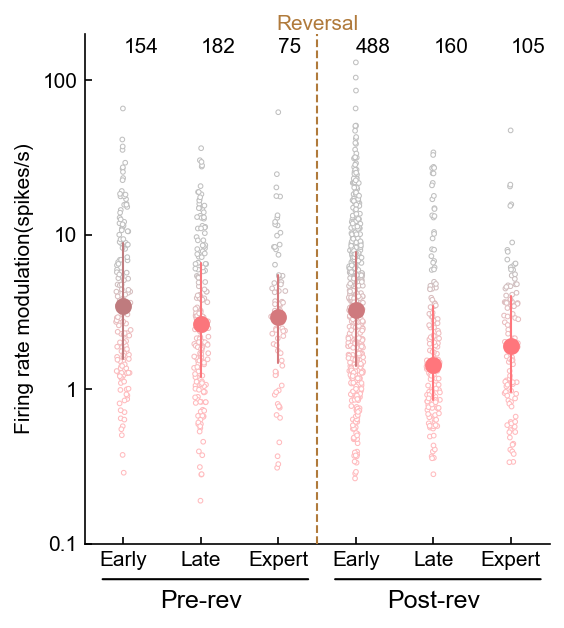

In [123]:
#Firing rate modulation graphs

size=5

FRmod_baseline_median = np.nanmedian(np.abs(FRmod_preearly))
print('baseline = '+str(FRmod_baseline_median))

fig, ax = plt.subplots(figsize=(4,4.5))
data = [FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert]
data = [np.abs(column[np.isfinite(column)]) for column in data]
#num_animal = [preearly_animal_num,prelate_animal_num,preexpert_animal_num,postearly_animal_num,postlate_animal_num,postexpert_animal_num]
labels = ['Early','Late','Expert','Early','Late','Expert']
numCon = len(data)
X = [np.ones(len(l))*idx for idx,l in enumerate(data)]

_,Y = ilep.violin(np.concatenate(X),np.concatenate(data),width=0.25)
X,_ = ilep.violin(np.concatenate(X),np.log10(np.concatenate(data)),width=0.25)
colors = NCR_CR_cmap((Y-1)/5)

ax.scatter(X, Y, s=size, ec=colors, fc='white', lw=0.5,zorder=-10)
ax.set_yscale('log',subs=[])

#Plot summary
for idx,column in enumerate(data):
    percentCR = np.nanmean(np.greater(column,FRmod_baseline_median))*100
    
    eye_color=NCR_CR_cmap((percentCR-40)/20)
    
    r,g,b = mpl.colors.to_rgb(eye_color)
    h,l,s = colorsys.rgb_to_hls(r,g,b)
    #border_color=colorsys.hls_to_rgb(h,l*0.5,s)
    border_color=colorsys.hls_to_rgb(h,l,s)

    summary_size=50
    summary_width=1
    
    Q1, median, Q3 = (np.percentile(column, q) for q in [25, 50, 75])
    
    ax.scatter([idx], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx, idx], [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.set_ylim([0.1,200])
ax.set_yticks([0.1,1,10,100])
ax.set_yticklabels(['0.1','1','10','100'])
ax.set_ylabel('Firing rate modulation(spikes/s)')

ax.set_xlim([-0.5,5.5])
ax.set_xticks(range(numCon))
ax.set_xticklabels(labels)
ax.set_xlim(ax.get_xlim())

# #numbers
#cells
# for idx,column in enumerate(data):
#     ax.text(idx,120,str(len(column)))
# #animals
# for idx,column in enumerate(num_animal):
#     ax.text(idx,95,str(column))
    
ax.fill_between(ax.get_xlim(),[ax.get_ylim()[0]]*2,[ax.get_ylim()[1]]*2,color='white',alpha=0.5,zorder=-5)
#ax.axhline(ramping_baseline_median,color='k',linestyle='--',lw=1,zorder=-4)
ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
#statistics
#ax.text(1,105,str('n.s.'))
#ax.text(2,105,str('n.s.'))
#ax.text(3,105,str('n.s.'))
#ax.text(4,105,str('n.s.'))
#ax.text(5,105,str('n.s.'))

ax.text(0,150,str(len(FRmod_preearly)))
ax.text(1,150,str(len(FRmod_prelate)))
ax.text(2,150,str(len(FRmod_preexpert)))
ax.text(3,150,str(len(FRmod_postearly)))
ax.text(4,150,str(len(FRmod_postlate)))
ax.text(5,150,str(len(FRmod_postexpert)))

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
ax.text(xtick_pos_pre, 0.05, 'Pre-rev', ha='center', va='top', fontsize=12)
ax.text(xtick_pos_post, 0.05, 'Post-rev', ha='center', va='top',  fontsize=12)
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

#plt.tight_layout()
fig.savefig(os.path.join('D:\\\\TempFigures','AC stimulus modulation Non-Excluded all cells over learning.png'),transparent=False,facecolor="white")
#fig.savefig(os.path.join('D:\\\\TempFigures''AC stimulus modulation all cells over learning.pdf'),transparent=False,facecolor="white")

In [125]:
data = SimpleNamespace(prereversal_early=np.abs(FRmod_preearly),
                      prereversal_late=np.abs(FRmod_prelate),
                      prereversal_expert=np.abs(FRmod_preexpert),
                      postreversal_early=np.abs(FRmod_postearly),
                      postreversal_late=np.abs(FRmod_postlate),
                      postreversal_expert=np.abs(FRmod_postexpert)
                     )

In [126]:
phase = len(data.prereversal_early)*["pre-early"] + len(data.prereversal_late)*["pre-late"] + len(data.prereversal_expert)*["pre-expert"] \
        + len(data.postreversal_early)*["post-early"] + len(data.postreversal_late)*["post-late"] + len(data.postreversal_expert)*["post-expert"]
context = len(data.prereversal_early)*["pre"] + len(data.prereversal_late)*["pre"] + len(data.prereversal_expert)*["pre"] \
        + len(data.postreversal_early)*["post"] + len(data.postreversal_late)*["post"] + len(data.postreversal_expert)*["post"]
mod = (np.concatenate([data.prereversal_early, data.prereversal_late, data.prereversal_expert, data.postreversal_early, data.postreversal_late, data.postreversal_expert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})
#df.to_csv('C:\\\\Users\\insan\\Desktop\\DataForStatsTestRamping.csv')

In [127]:
pg.anova(data=df, dv='FR_mod', between=['phase'], detailed=True)

Source             SS    DF          MS         F    p-unc       np2
0   phase    2251.136179     5  450.227236  5.012925  0.00015  0.021186
1  Within  104003.787379  1158   89.813288       NaN      NaN       NaN

In [128]:
context_results = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase'], parametric=True, padjust='fdr_bh')

In [132]:
# Conducting pairwise tests using Benjamini/Hochberg FDR correction to Mann-Whitney U

pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between="phase", padjust="fdr_bh", parametric=False, )

#pairwise_mwu[pairwise_mwu["p-corr"] <= 0.05][["A", "B", "p-corr", "hedges"]]
pairwise_mwu[:][["A", "B","p-unc", "p-corr", "hedges"]]

A            B         p-unc        p-corr    hedges
0    post-early  post-expert  3.747829e-05  1.405436e-04  0.332033
1    post-early    post-late  4.829715e-09  7.244572e-08  0.297690
2    post-early    pre-early  4.785592e-01  5.521837e-01  0.037947
3    post-early   pre-expert  5.216280e-01  5.565809e-01  0.150985
4    post-early     pre-late  8.454319e-02  1.268148e-01  0.190741
5   post-expert    post-late  2.924078e-01  3.953603e-01 -0.072464
6   post-expert    pre-early  3.498246e-05  1.405436e-04 -0.416541
7   post-expert   pre-expert  1.268800e-02  2.718858e-02 -0.282301
8   post-expert     pre-late  1.625350e-02  3.047531e-02 -0.268451
9     post-late    pre-early  3.292971e-08  2.469729e-07 -0.357836
10    post-late   pre-expert  4.469012e-04  1.117253e-03 -0.208828
11    post-late     pre-late  2.311134e-04  6.933402e-04 -0.184638
12    pre-early   pre-expert  3.162882e-01  3.953603e-01  0.149519
13    pre-early     pre-late  4.207221e-02  7.012034e-02  0.210586
14   pre-expert     pre-late  5.565809e-01  5.565809e-01  0.043574

In [ ]:
def find_active_trials(outcomes,window_length = 75, active_thresholds = [0.2,0.8], verification_threshold = 0.8):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    
    gos = np.logical_or(hits,falarms)
    
    participation = np.array([np.mean(gos[i:(i+window_length)]) for i in range(len(gos)-window_length)])
    
    #Calculate where active conditions are fulfilled
    activehighthresh = np.less(participation,active_thresholds[1])
    activelowthresh = np.greater(participation,active_thresholds[0])
    active = np.logical_and(activehighthresh,activelowthresh)
    #Get trial numbers
    activetrials = np.where(active)[0]
    if len(activetrials) >= 2:
        activestart = np.min(activetrials)
        activeend = np.max(activetrials)
    else:
        activestart = np.nan
        activeend = np.nan
    
    ############################################ If there's no active period then skip everything
    if not np.isfinite(activestart) or not np.isfinite(activeend):
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Verify that an appropriate amount of this span is active
    activespan = np.array(range(len(active)))
    tempspan = np.greater_equal(activespan,activestart)
    tempspan2 = np.less_equal(activespan,activeend)
    activespan = np.logical_and(tempspan,tempspan2)
    verification_frac = np.sum(active) / np.sum(activespan)
    #Check against verification_threshold and abort if insufficient
    if np.isfinite(verification_frac) and verification_frac < verification_threshold:
        valid_trials = np.zeros_like(outcomes,dtype='bool')
        return valid_trials
    
    ############################################ Now return a proper valid_trials object
    activeend += window_length
    valid_trials = np.zeros_like(outcomes,dtype='bool')
    valid_trials[activestart:activeend] = True
    return valid_trials

In [142]:
def getOutcomesFromSession(sessionfile):
    outcomes = np.full_like(sessionfile.trials.starts,np.nan)
    hits = np.logical_and(sessionfile.trials.go,sessionfile.trials.target)
    misses = np.logical_and(np.logical_not(sessionfile.trials.go),sessionfile.trials.target)
    falarms = np.logical_and(sessionfile.trials.go,np.logical_not(sessionfile.trials.target))
    crejects = np.logical_and(np.logical_not(sessionfile.trials.go),np.logical_not(sessionfile.trials.target))
    outcomes[hits] = 1*np.ones(np.sum(hits))
    outcomes[misses] = 2*np.ones(np.sum(misses))
    outcomes[falarms] = 3*np.ones(np.sum(falarms))
    outcomes[crejects] = 4*np.ones(np.sum(crejects))
    return outcomes

In [331]:
def trimActiveTrialExpertRestricted(outcomes,max_trim=150,window_length=50,active_threshold=0.8,sated_threshold=0.1):
    hits = np.equal(outcomes,1)
    misses = np.equal(outcomes,2)
    falarms = np.equal(outcomes,3)
    crejects = np.equal(outcomes,4)
    gos = np.logical_or(hits,falarms)
    nogos = np.logical_or(misses,crejects)
    
    #Disable max trim
    #max_trim = len(outcomes)
    max_trim = min(len(outcomes),max_trim)
    
    #Determine lick rate over time
    number_windows = len(outcomes) - window_length + 1
    lick_rates = np.full(number_windows,np.nan)
    for window_idx in range(number_windows):
        
        window_trials = list(range(window_idx,window_idx+window_length))
        window_gos = gos[window_trials]
        
        window_lick_rate = np.mean(window_gos)
        lick_rates[window_idx] = window_lick_rate
        
    #Find where lick rate is acceptable -- overlicking
    lick_rates_below_threshold = np.less_equal(lick_rates,active_threshold)
    first_valid_window = number_windows
    if np.sum(lick_rates_below_threshold) > 0:
        first_valid_window = np.min(np.where(lick_rates_below_threshold)[0])
    first_valid_window = int(  min(max_trim,first_valid_window) + 0.5*window_length  )
    if lick_rates[0] < active_threshold:
        first_valid_window = 0
    
    #Final result from first trim -- trials that are not overlicking
    valid_trials_overlicking = list(range(first_valid_window,len(outcomes)))
    valid_trials_overlicking = np.array(valid_trials_overlicking)
    
    #############################################################################
    
    #Find where lick rate is acceptable -- overlicking
    lick_rates_above_threshold = np.greater_equal(lick_rates,sated_threshold)
    last_valid_window = 0
    if np.sum(lick_rates_above_threshold) > 0:
        last_valid_window = np.max(np.where(lick_rates_above_threshold)[0])
    last_valid_window = int(  max(len(outcomes)-max_trim,last_valid_window) + 0.5*window_length  )
    #if lick_rates[len(lick_rates)-1] > sated_threshold:
    #    last_valid_window = len(lick_rates)-1 + window_length
    
    valid_trials_sated = list(range(0,last_valid_window))
    valid_trials_sated = np.array(valid_trials_sated)
    
    #############################################################################
    
    valid_trials = valid_trials_overlicking[np.isin(valid_trials_overlicking,valid_trials_sated)]
    trimmed_outcomes = outcomes[valid_trials]
        
    return lick_rates,hits,falarms,valid_trials,trimmed_outcomes

In [332]:
def pcdpfromoutcomes(outcomes):
    hit = np.sum(np.equal(outcomes,1))
    miss = np.sum(np.equal(outcomes,2))
    falarm = np.sum(np.equal(outcomes,3))
    creject = np.sum(np.equal(outcomes,4))

    pc = (hit+creject)/(hit+miss+falarm+creject)
    dp = norm.ppf((hit+1)/(hit+miss+2)) - norm.ppf((falarm+1)/(falarm+creject+2))
    
    return pc,dp

912it [00:04, 173.61it/s]<ipython-input-335-1ee27b46e138>:16: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(10,3))
1288it [00:06, 193.80it/s]


0.7637998347991586
1.6741579670482318


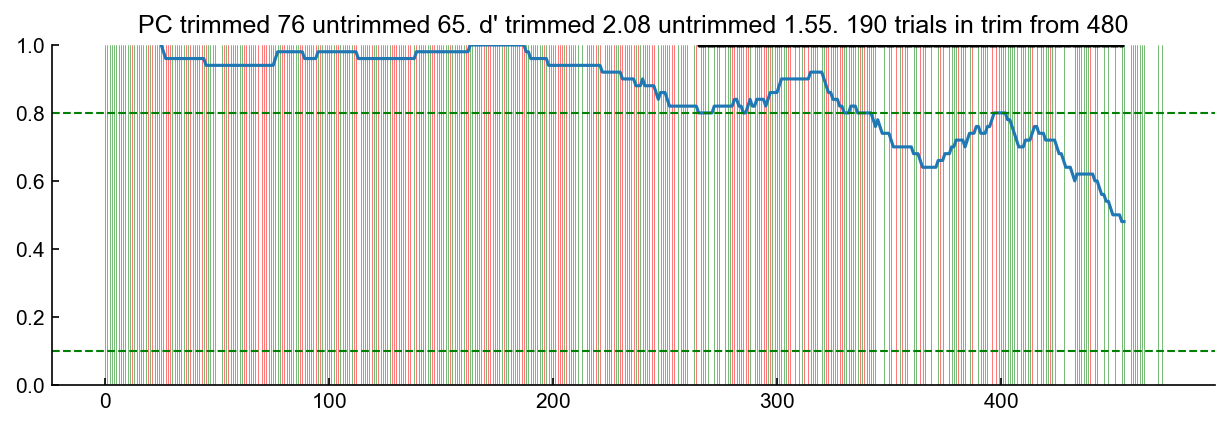

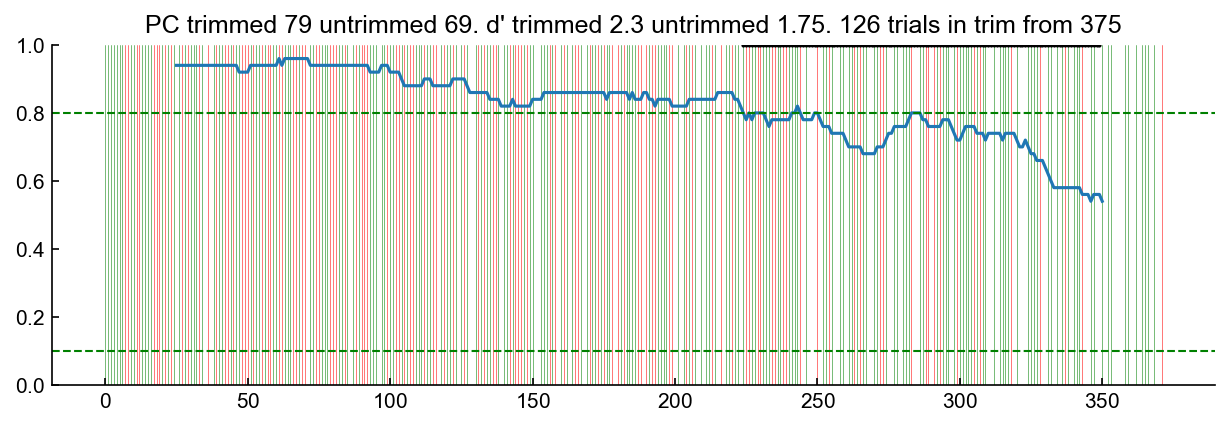

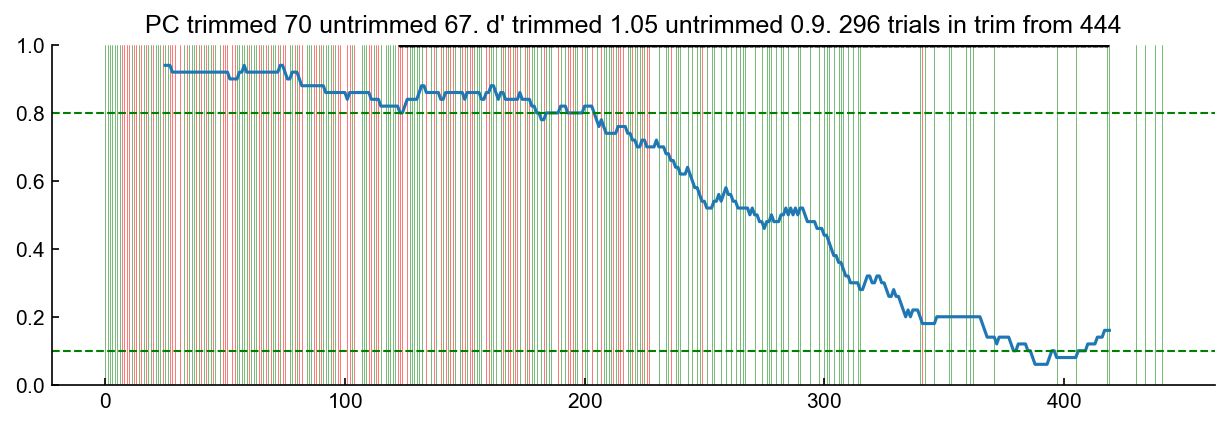

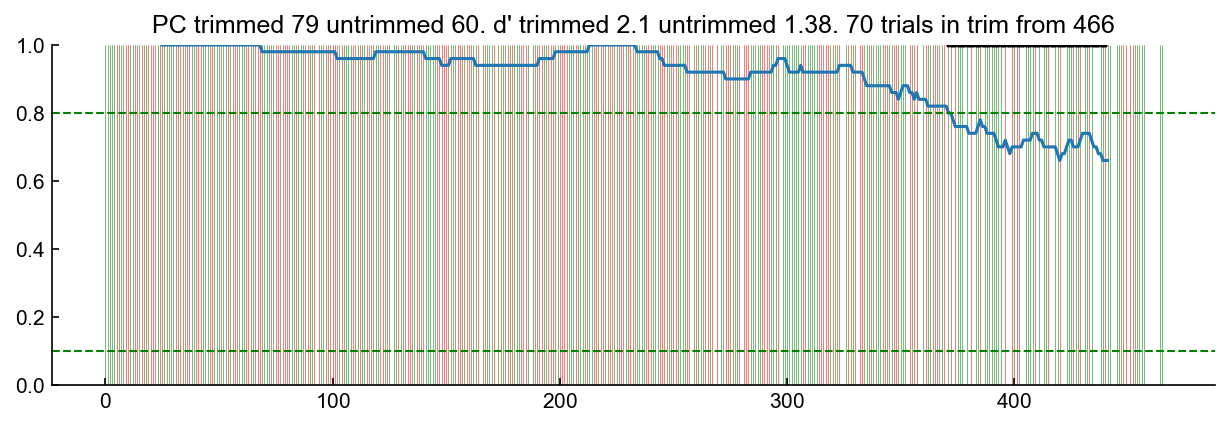

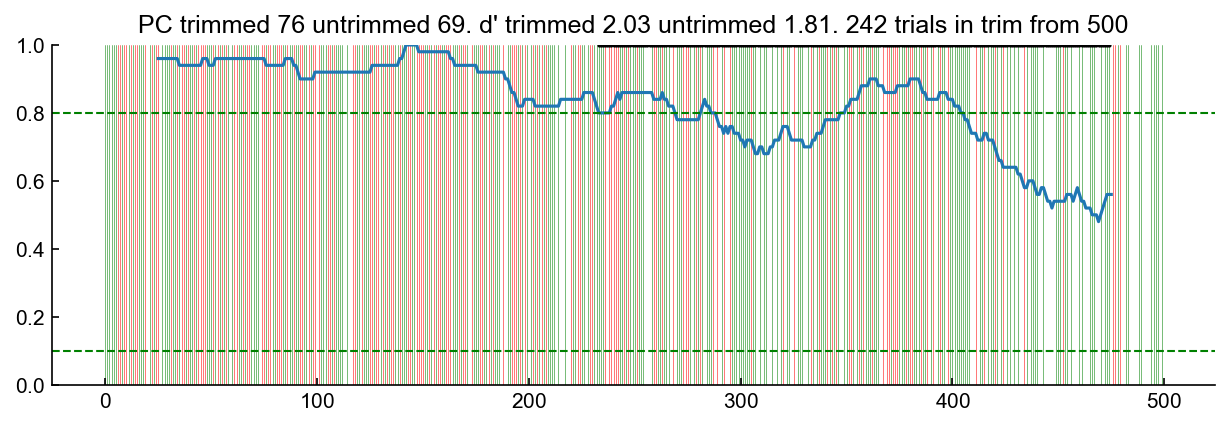

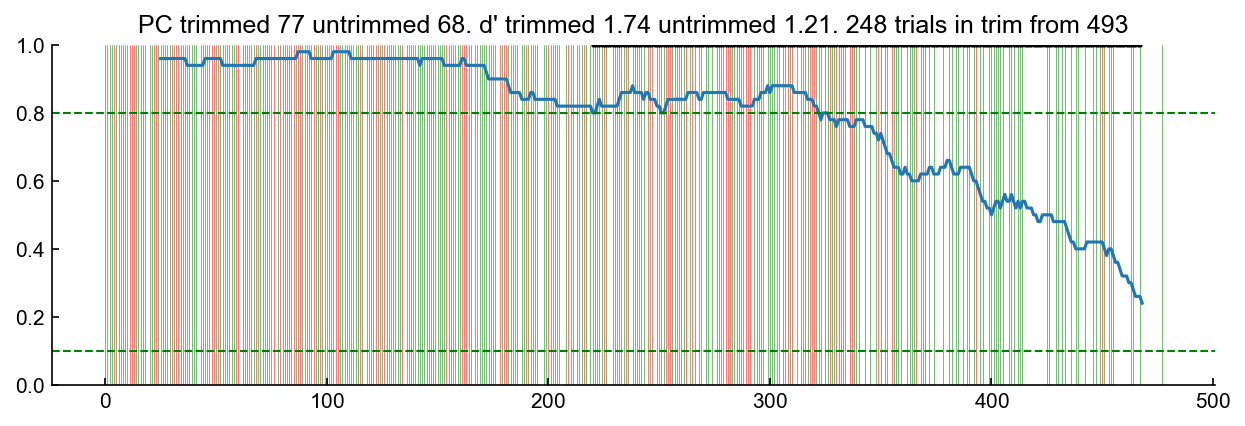

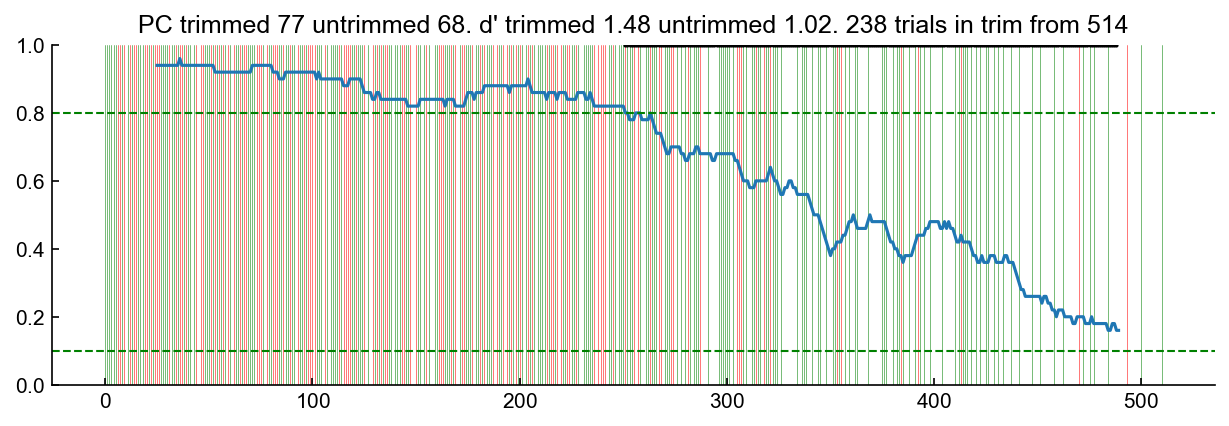

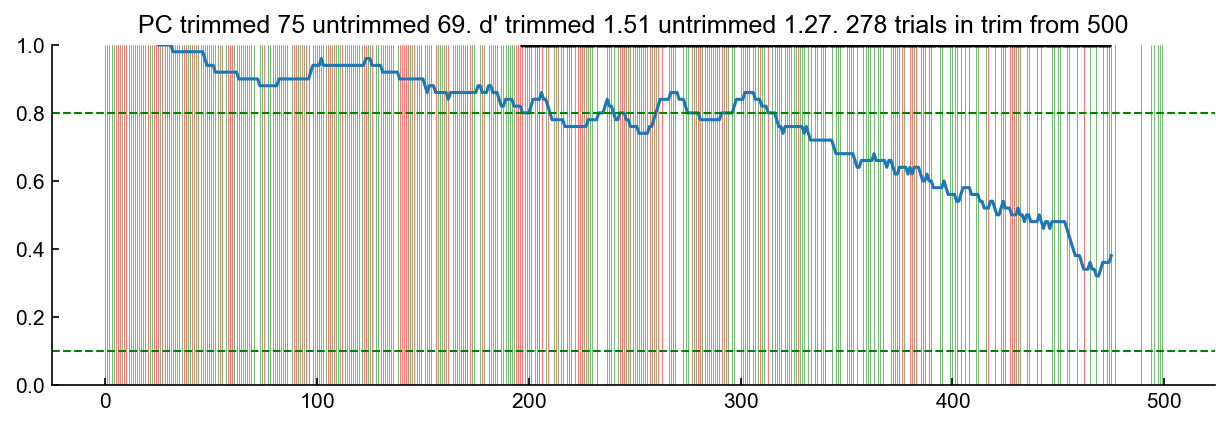

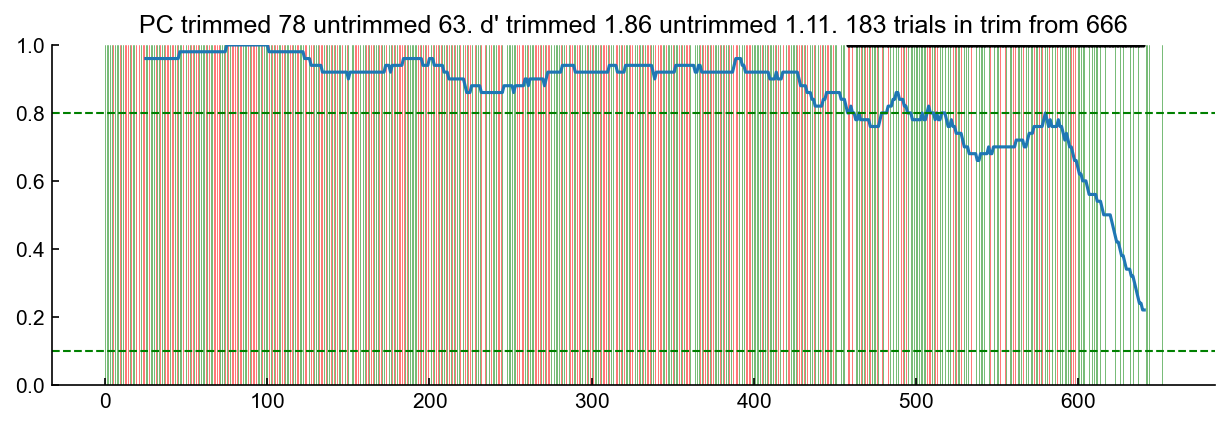

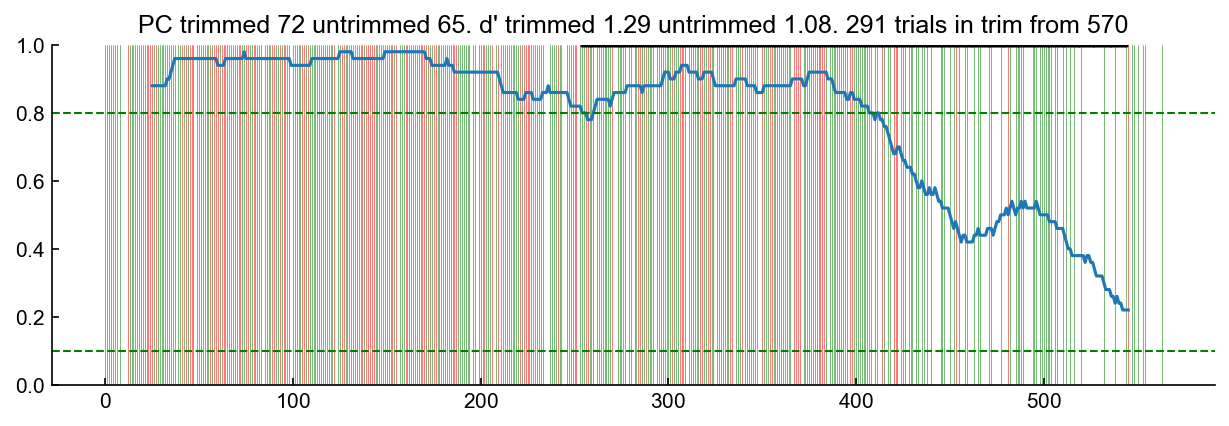

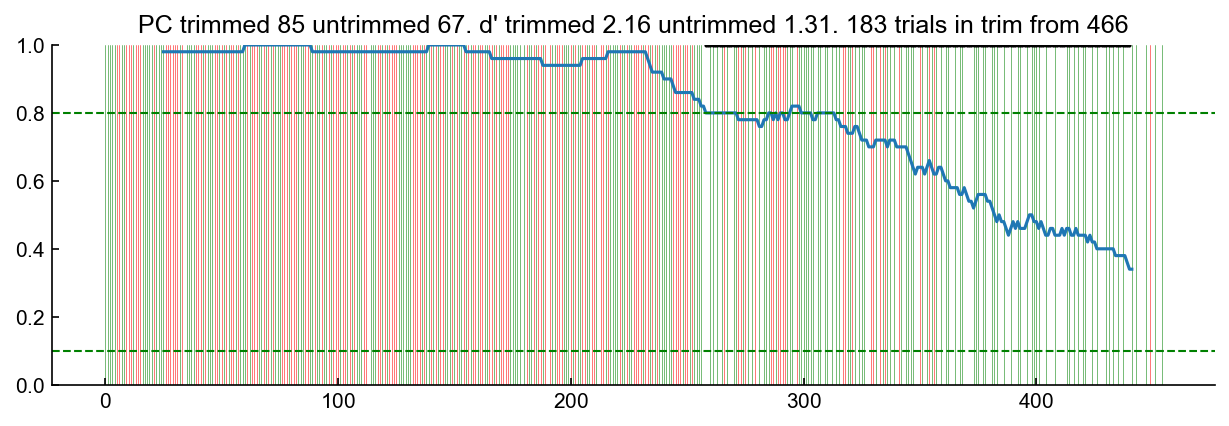

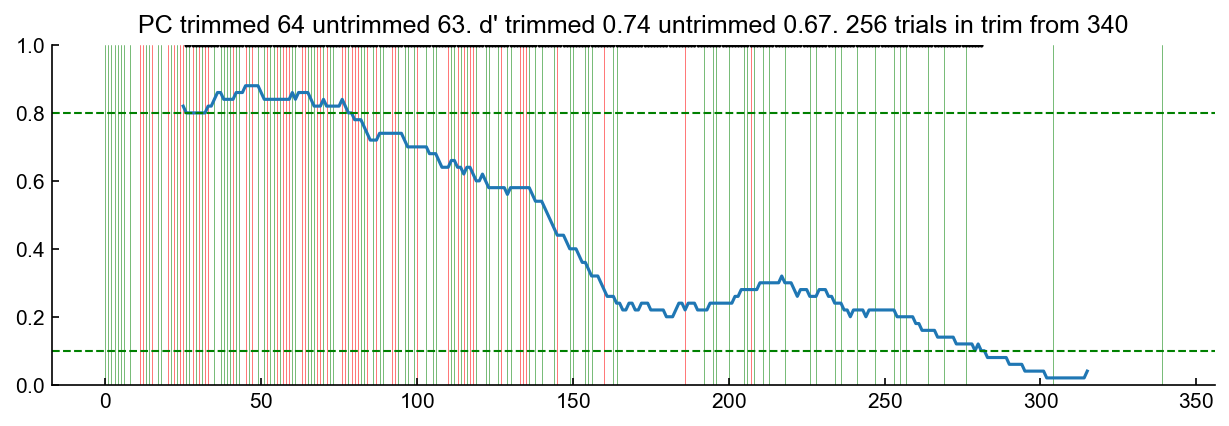

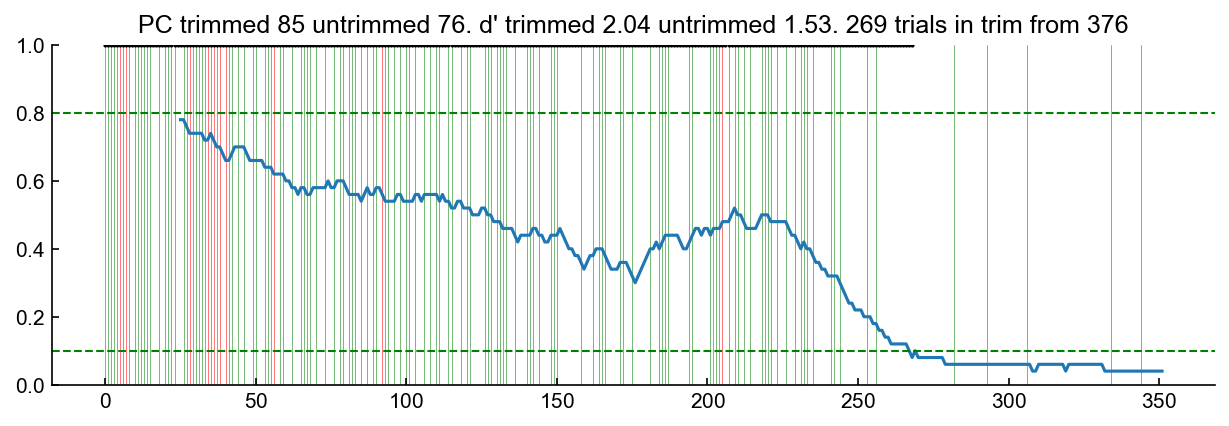

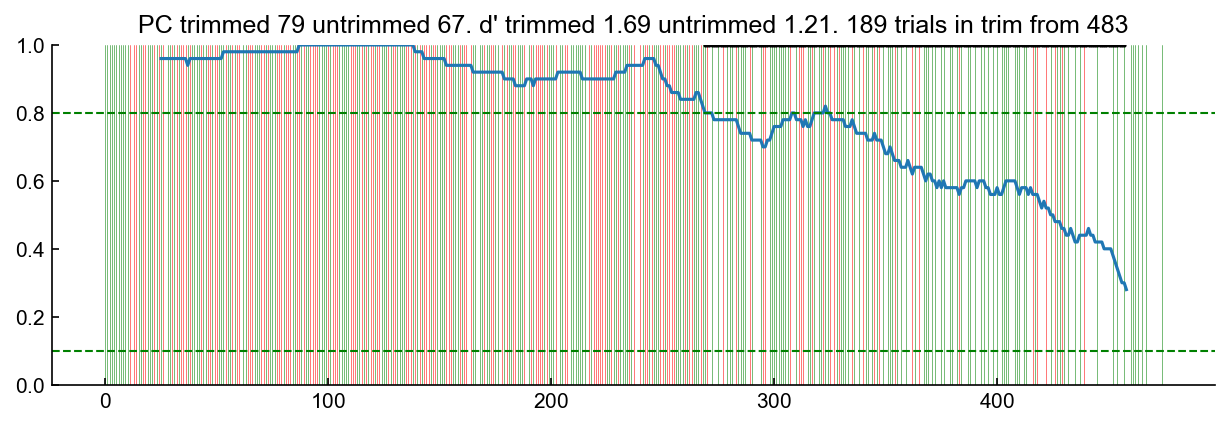

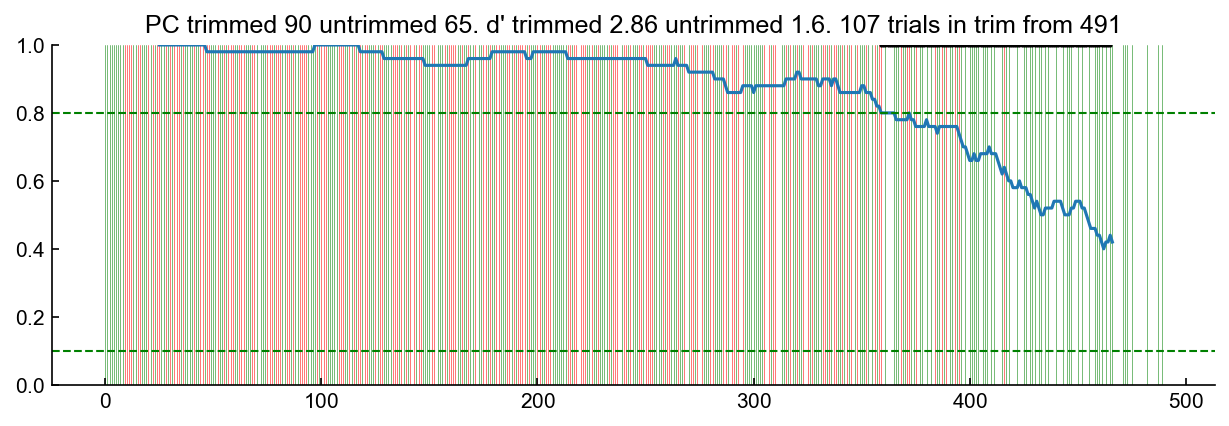

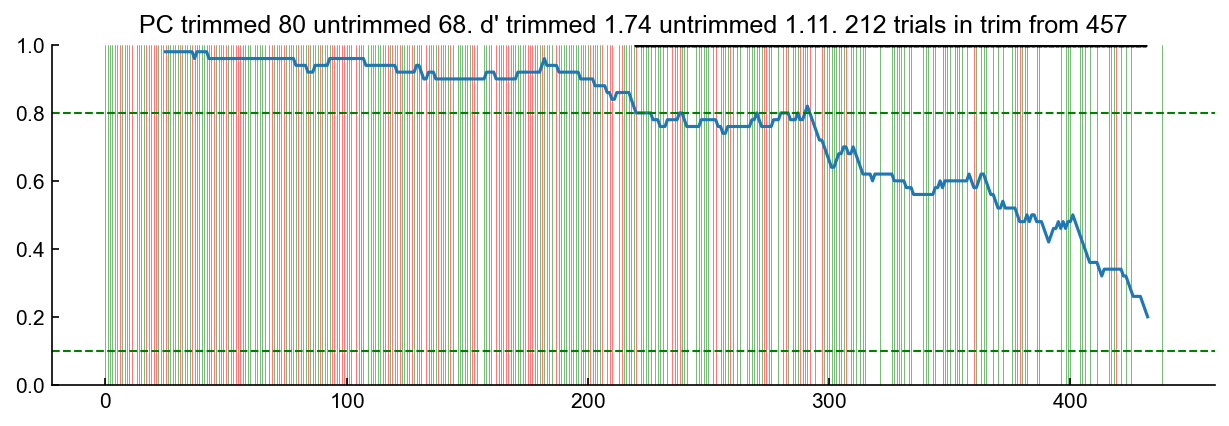

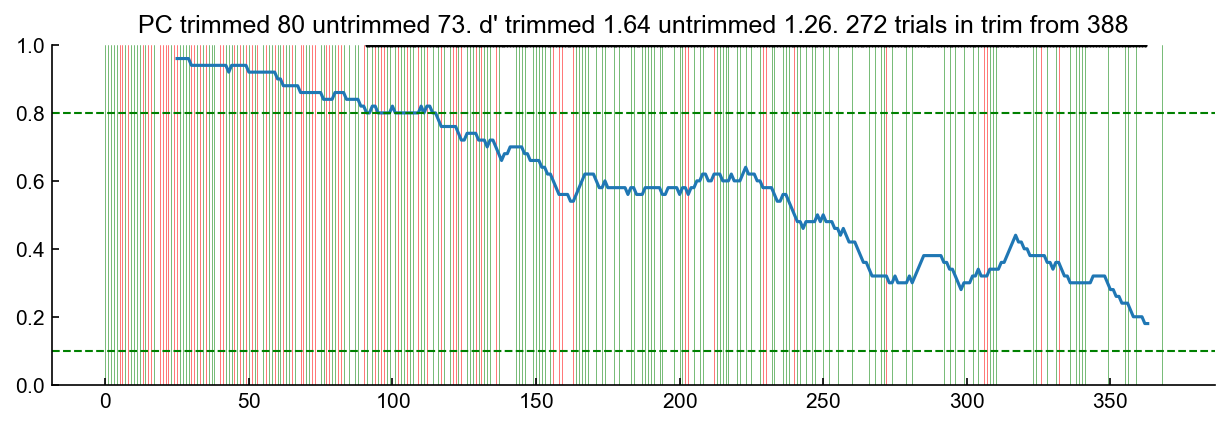

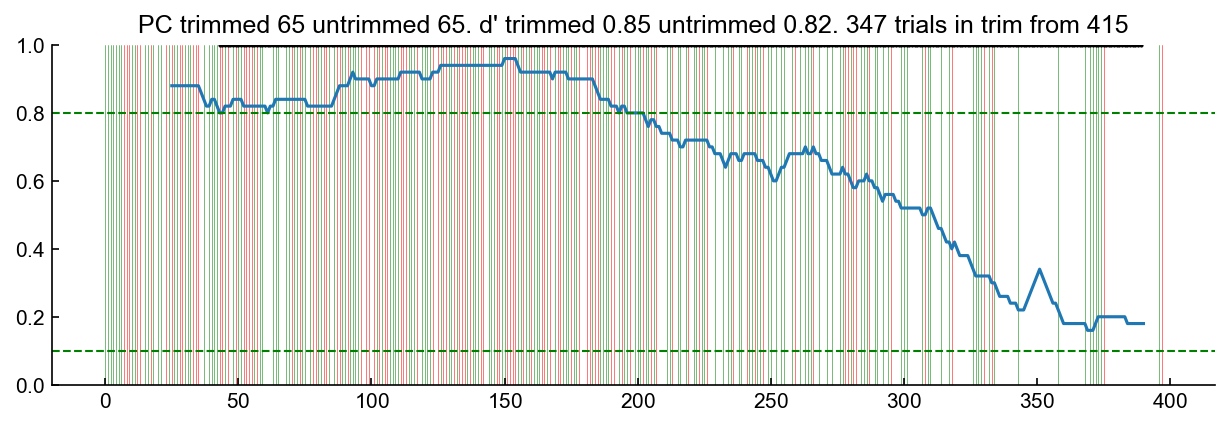

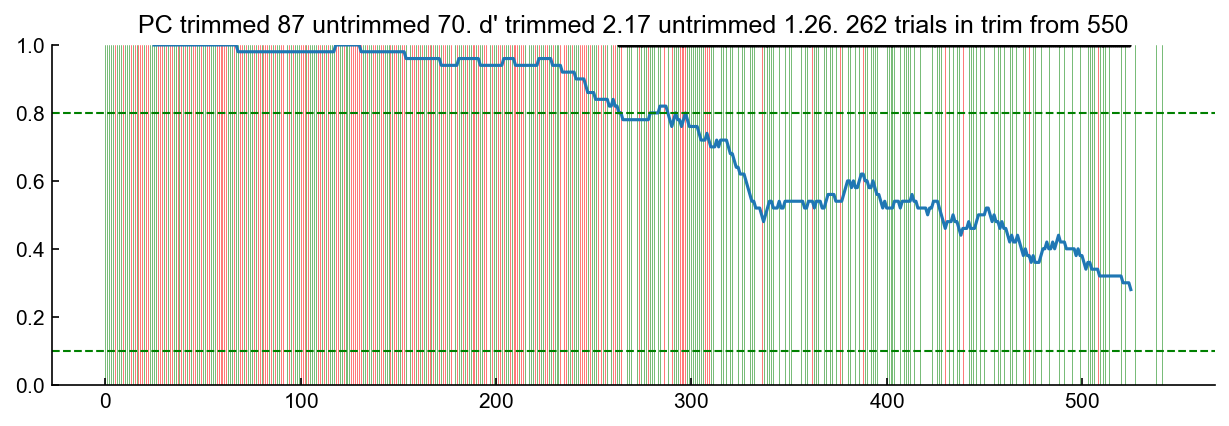

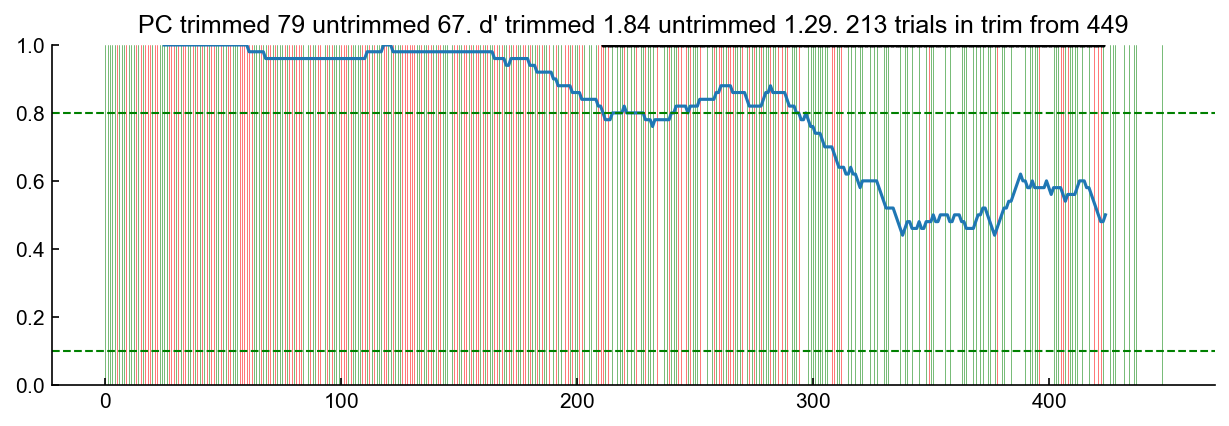

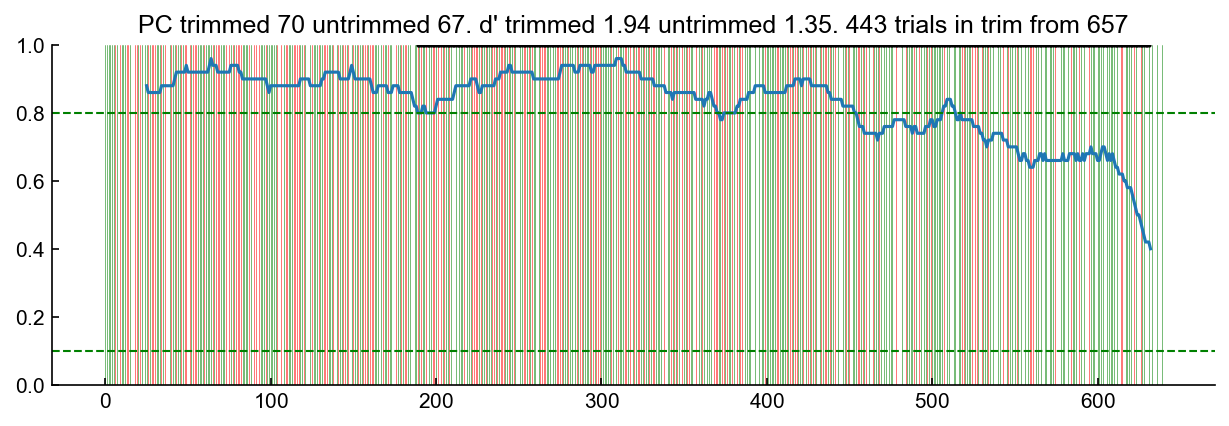

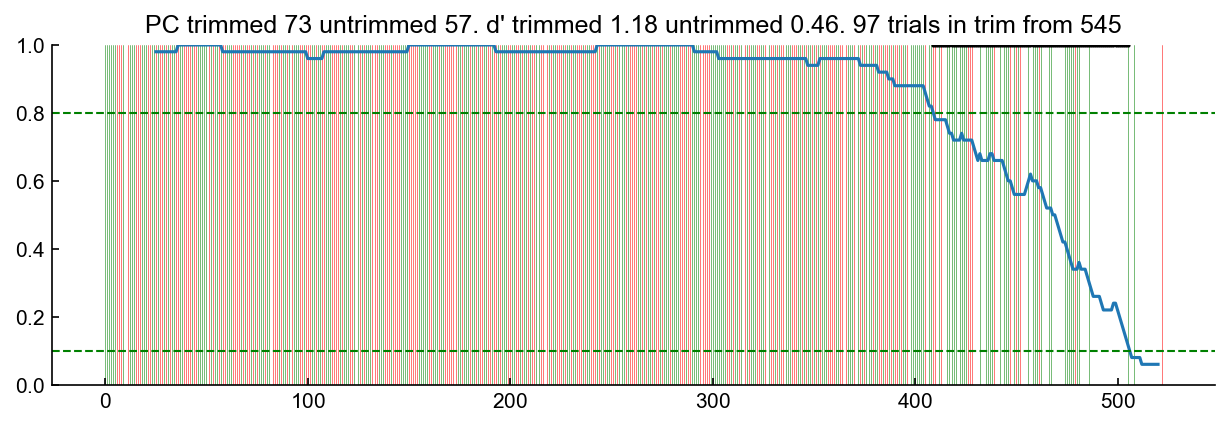

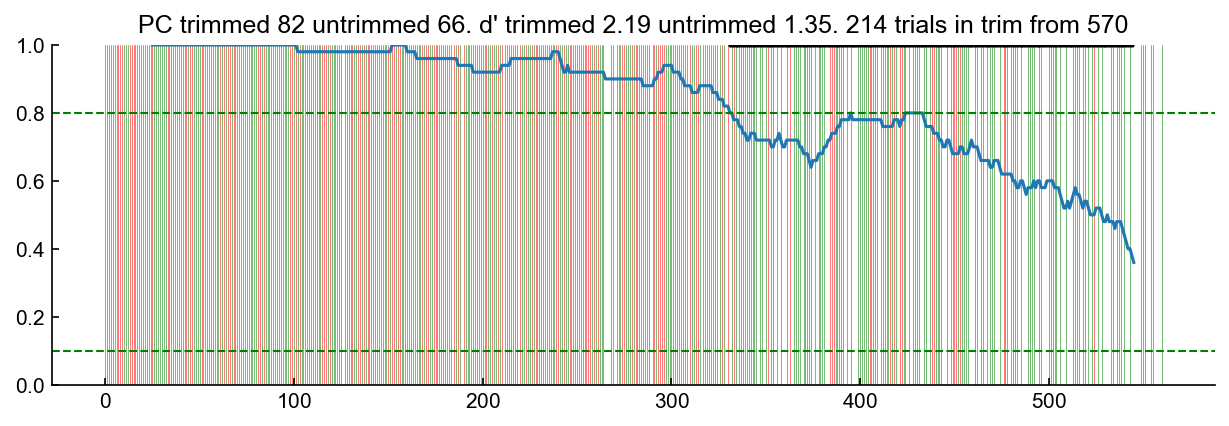

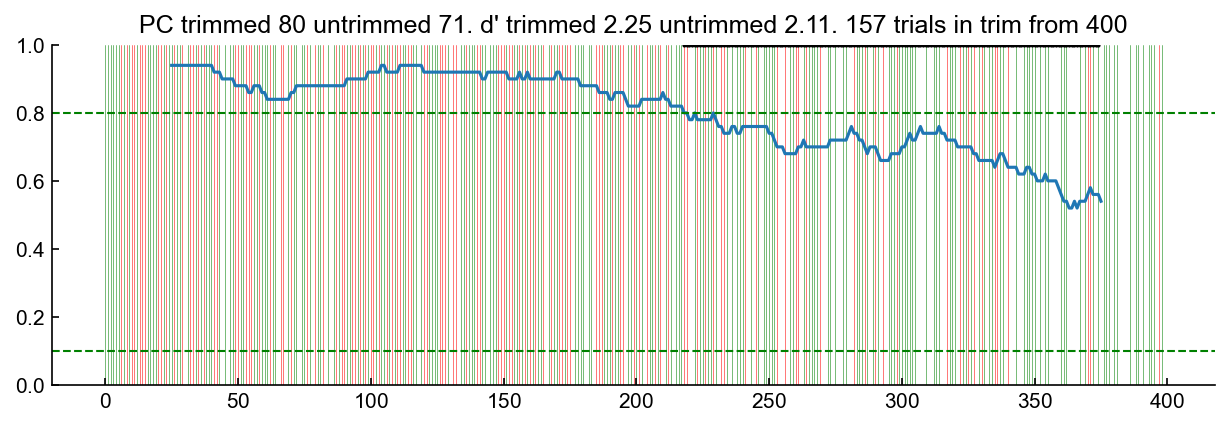

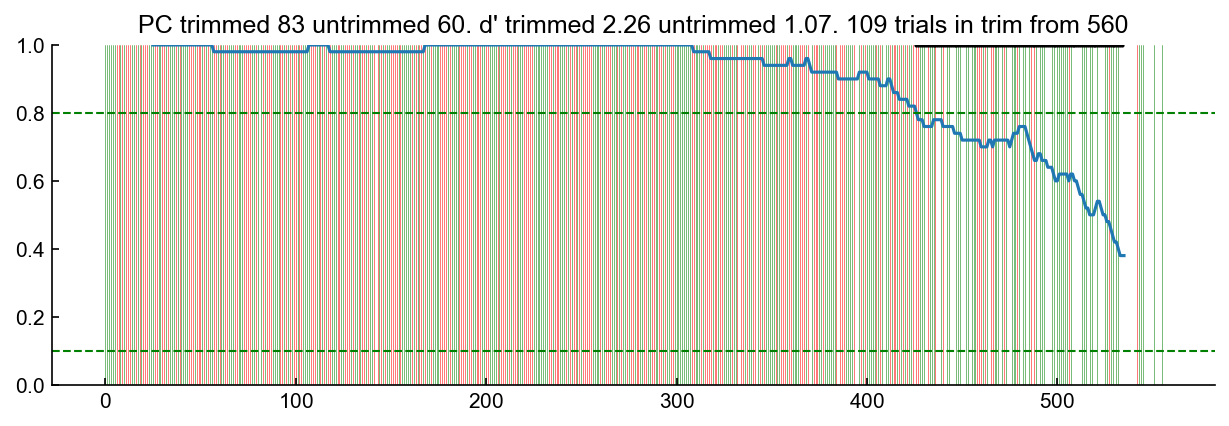

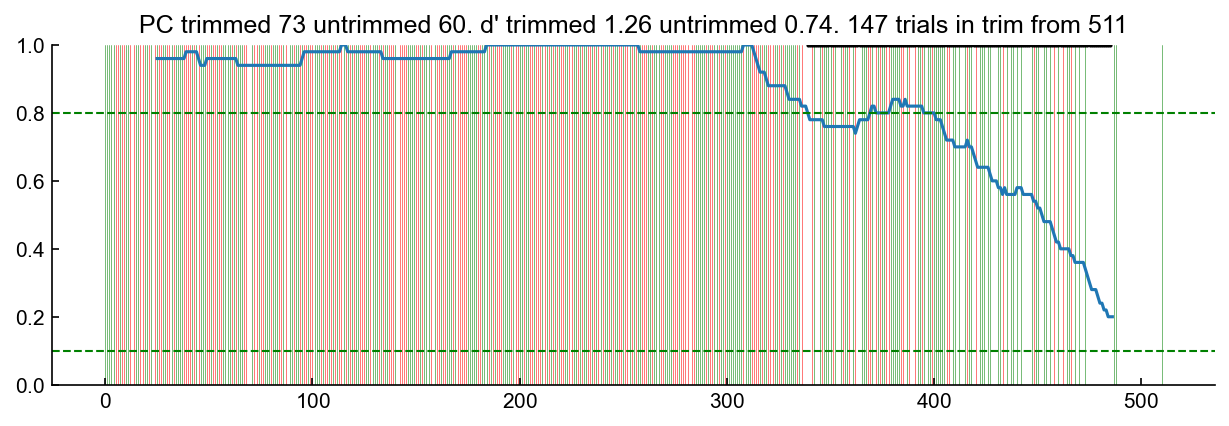

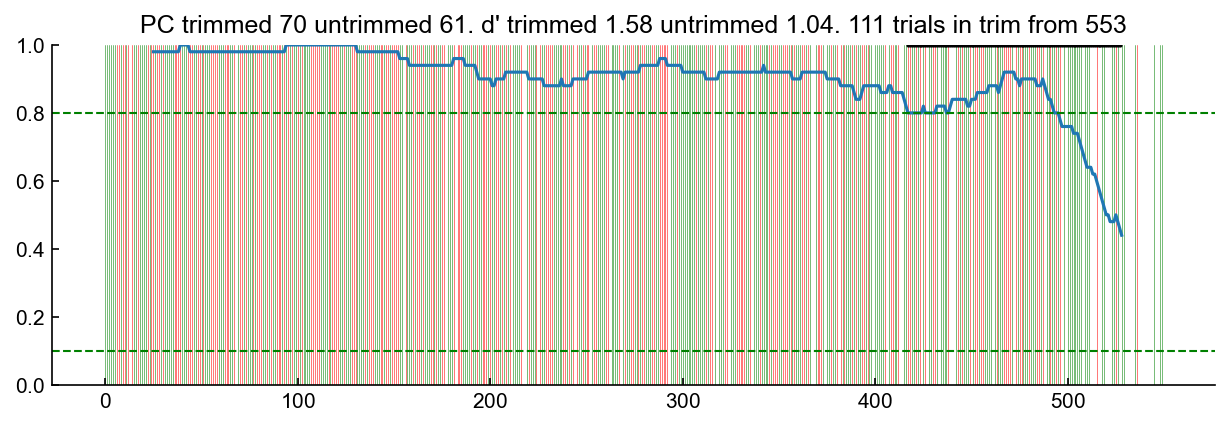

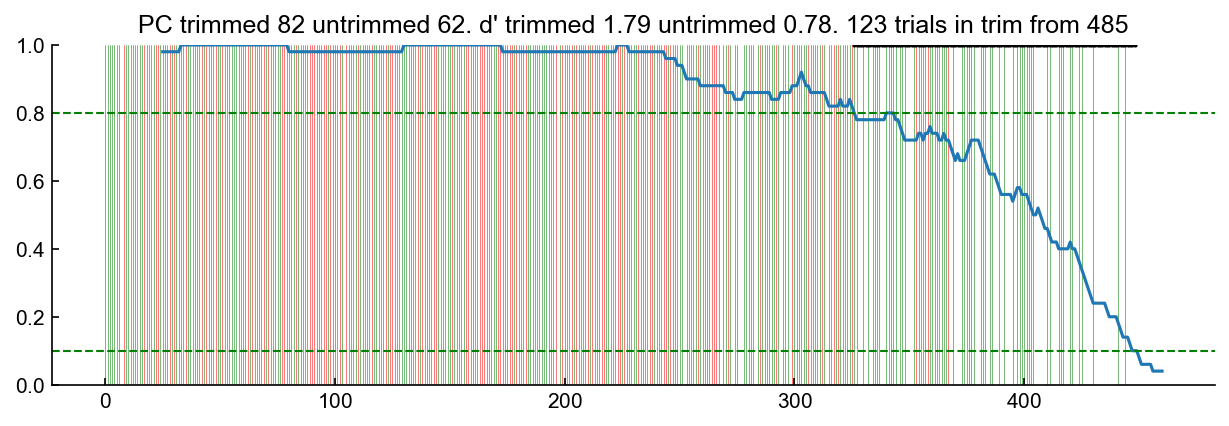

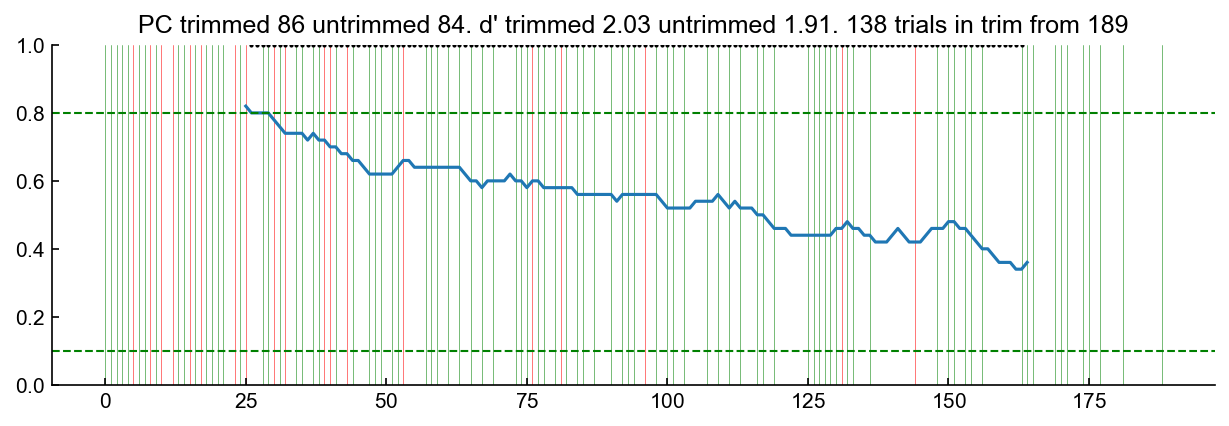

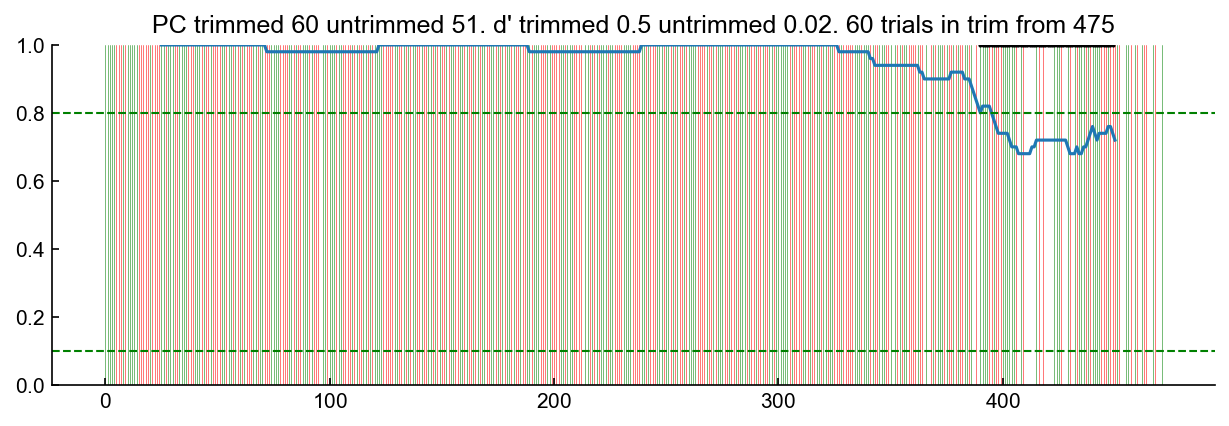

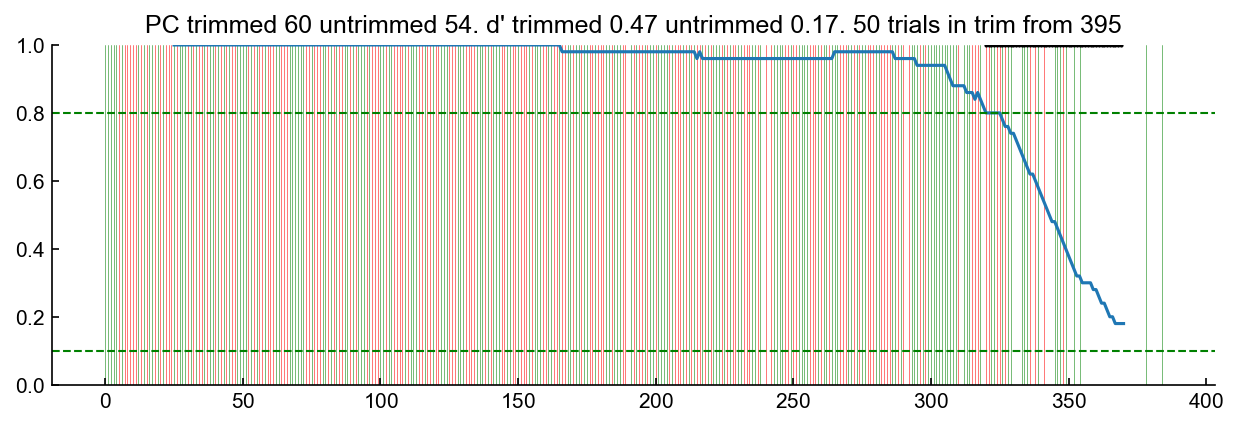

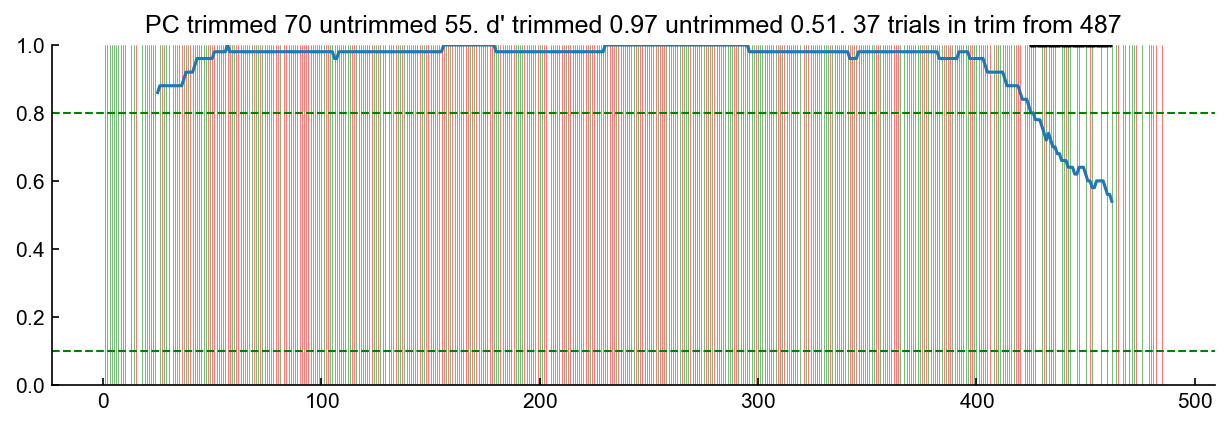

In [335]:
PCts = []
dpts = []

num_sessions = 0
old_session = None
for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    if session == old_session:
        continue
    old_session = session
    sessionfile = ilep.loadSessionCached(act_directory,session)
    if not sessionfile.meta.condition in ['prereversal expert','postreversal expert']:
        continue

    outcomes = getOutcomesFromSession(sessionfile)
    lick_rates,hits,falarms,valid_trials,trimmed_outcomes = trimActiveTrialExpertRestricted(outcomes,max_trim = 1000)
    fig, ax = plt.subplots(figsize=(10,3))
    ax.plot(np.array(range(len(lick_rates)))+50/2,lick_rates)
    [ax.axvline(hit,zorder=-10,lw=0.25,c='green') for hit in np.where(hits)[0]]
    [ax.axvline(falarm,zorder=-10,lw=0.25,c='red') for falarm in np.where(falarms)[0]]
    ax.scatter(valid_trials,np.ones_like(valid_trials),s=1,c='k')
    ax.axhline(0.8,c='g',linestyle='--',lw=1)
    ax.axhline(0.1,c='g',linestyle='--',lw=1)
    ax.set_ylim([0,1])
    
    PCt,dpt = pcdpfromoutcomes(trimmed_outcomes)
    PCu,dpu = pcdpfromoutcomes(outcomes)
    PCts.append(PCt)
    dpts.append(dpt)
    
    #print(session)
    #print(f"PC trimmed {round(100*PCt)} untrimmed {round(100*PCu)}. d' trimmed {round(100*dpt)/100} untrimmed {round(100*dpu)/100}. {len(trimmed_outcomes)} trials in trim from {len(outcomes)}")
    ax.set_title(f"PC trimmed {round(100*PCt)} untrimmed {round(100*PCu)}. d' trimmed {round(100*dpt)/100} untrimmed {round(100*dpu)/100}. {len(trimmed_outcomes)} trials in trim from {len(outcomes)}")
    
    if num_sessions >= 10:
        pass
    #break
    
print(np.mean(PCts))
print(np.mean(dpts))

In [184]:
sessionfile.meta.condition

'postreversal naive'

In [105]:
nEILphases = np.copy(EILphases)

In [108]:
len(EILphases)

1288

In [109]:
len(nEILphases)

1288

In [110]:
np.mean(np.char.equal(EILphases,nEILphases))

0.9045031055900621

Comparison by phase using excluded-data phases

In [111]:
for phase in np.unique(EILphases):
    in_phase_idx = np.char.equal(EILphases,phase)
    val = np.mean(np.char.equal(EILphases[in_phase_idx],nEILphases[in_phase_idx]))
    print(f"{phase} is {100*val}% correct")

post early is 94.48441247002398% correct
post expert is 100.0% correct
post late is 59.307359307359306% correct
pre early is 100.0% correct
pre expert is 100.0% correct
pre late is 96.80851063829788% correct
switch is 100.0% correct


Comparison by phase using all-data phases

In [112]:
for phase in np.unique(nEILphases):
    in_phase_idx = np.char.equal(nEILphases,phase)
    val = np.mean(np.char.equal(EILphases[in_phase_idx],nEILphases[in_phase_idx]))
    print(f"{phase} is {100*val}% correct")

post early is 80.73770491803278% correct
post expert is 100.0% correct
post late is 85.625% correct
pre early is 96.1038961038961% correct
pre expert is 100.0% correct
pre late is 100.0% correct
switch is 100.0% correct


In [17]:
animalBehaviors['DS_19']

namespace(ID='DS_19',
          reversal=nan,
          sessions={1: namespace(animal='DS_19',
                              session=1,
                              files=array(['DS_19_1v1.txt', 'DS_19_1v2.txt', 'DS_19_1v3.txt'], dtype='<U13'),
                              blocknumbers=array([1, 2, 3]),
                              type='prereversal',
                              trials_per_session=array([200., 100., 100.]),
                              outcomes=0     1
                                       1     1
                                       2     1
                                       3     1
                                       4     1
                                            ..
                                       95    1
                                       96    4
                                       97    2
                                       98    4
                                       99    2
                                       Name: outco

In [11]:
animals

{'BS_40': namespace(name='BS_40', reversal=18),
 'BS_41': namespace(name='BS_41', reversal=6),
 'BS_42': namespace(name='BS_42', reversal=7),
 'BS_49': namespace(name='BS_49', reversal=13),
 'BS_50': namespace(name='BS_50', reversal=12),
 'BS_51': namespace(name='BS_51', reversal=8),
 'BS_56': namespace(name='BS_56', reversal=8),
 'BS_59': namespace(name='BS_59', reversal=7),
 'BS_67': namespace(name='BS_67', reversal=7),
 'BS_70': namespace(name='BS_70', reversal=8),
 'BS_72': namespace(name='BS_72', reversal=6),
 'BS_87': namespace(name='BS_87', reversal=6),
 'BS_108': namespace(name='BS_108', reversal=7)}

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: inv

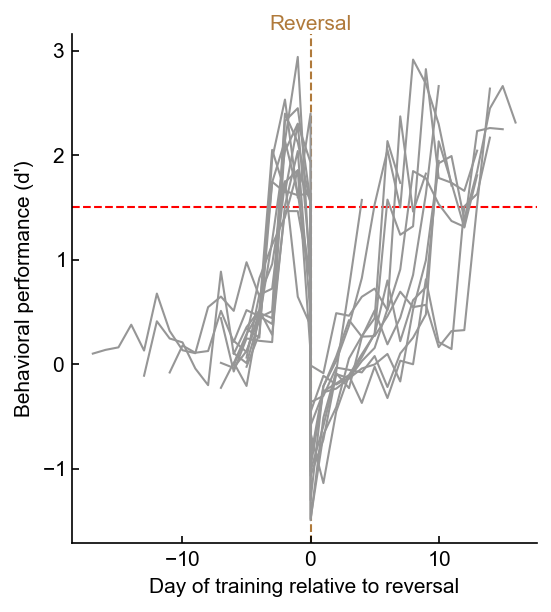

In [19]:
fig, ax = plt.subplots(figsize=(4,4.5))
for animalidx,animal in enumerate(animals):    
    if animal in ['BS_40','BS_49','BS_50']:
        #continue
        pass
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if hasattr(animalBehaviors[animal],'reversal'):
        days.append(reversal)
    days = np.sort(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    ax.plot(days-reversal,dp_list,lw=1,label=animal,color=GOOD_GREY)
    
ax.axhline(1.5,color='red',linestyle='--',zorder=-9,lw=1)

ax.axvline(0,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
ax.text(0,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
    
ax.set_xlabel('Day of training relative to reversal')
ax.set_ylabel('Behavioral performance (d\')')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Summary learning curves.pdf'),transparent=False,facecolor="white")

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)


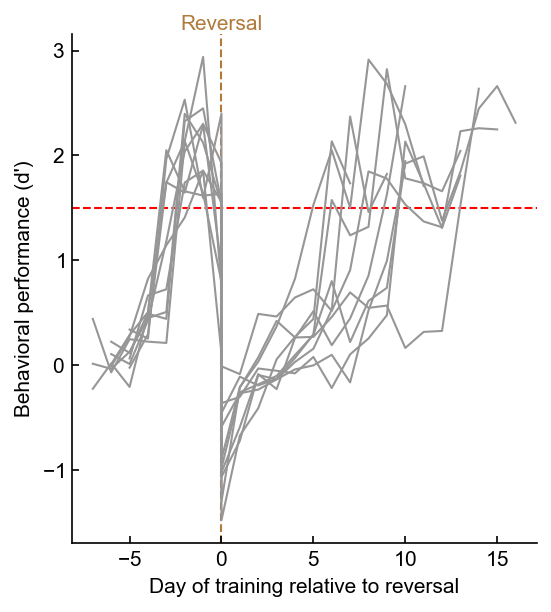

In [20]:
fig, ax = plt.subplots(figsize=(4,4.5))
for animalidx,animal in enumerate(animals):    
    if animal in ['BS_40','BS_49','BS_50']:
        continue
        pass
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if hasattr(animalBehaviors[animal],'reversal'):
        days.append(reversal)
    days = np.sort(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    ax.plot(days-reversal,dp_list,lw=1,label=animal,color=GOOD_GREY)
    
ax.axhline(1.5,color='red',linestyle='--',zorder=-9,lw=1)

ax.axvline(0,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
ax.text(0,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
    
ax.set_xlabel('Day of training relative to reversal')
ax.set_ylabel('Behavioral performance (d\')')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Summary learning curves minus three animals.pdf'),transparent=False,facecolor="white")

C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
C:\Users\insan\Desktop\EphysAnalysis\InsanallyLabEphysTools\behavior.py:93: RuntimeWarning: inv

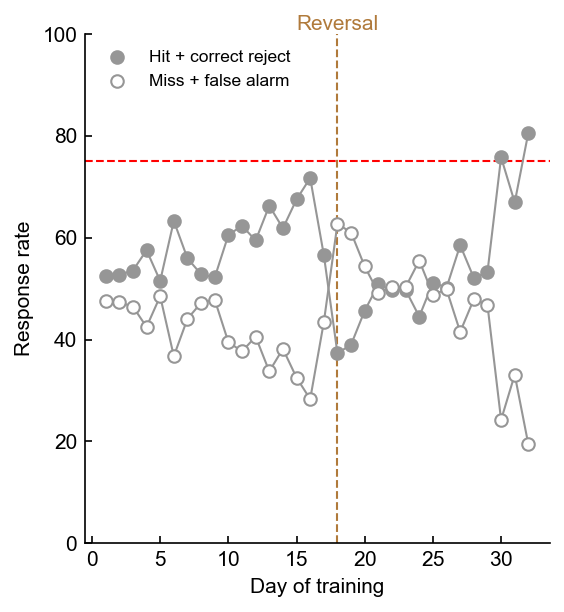

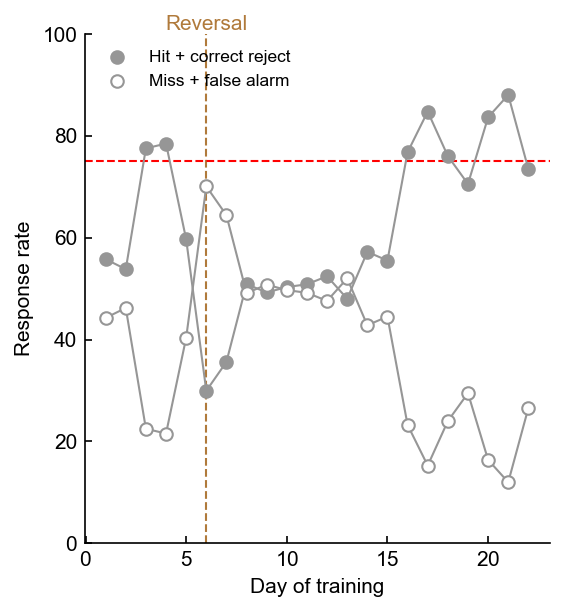

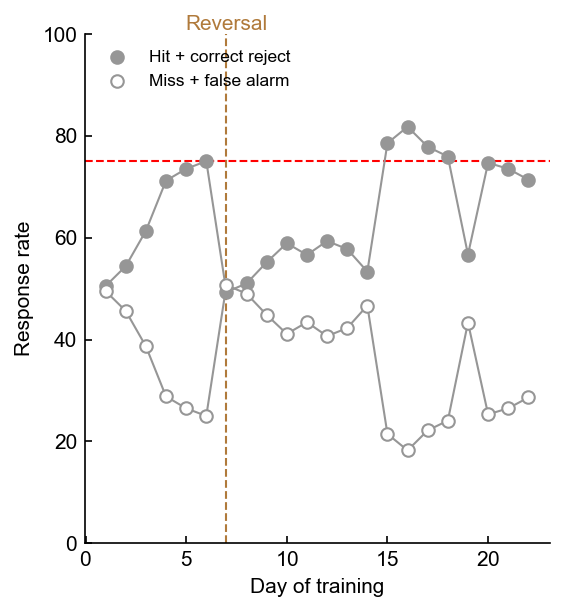

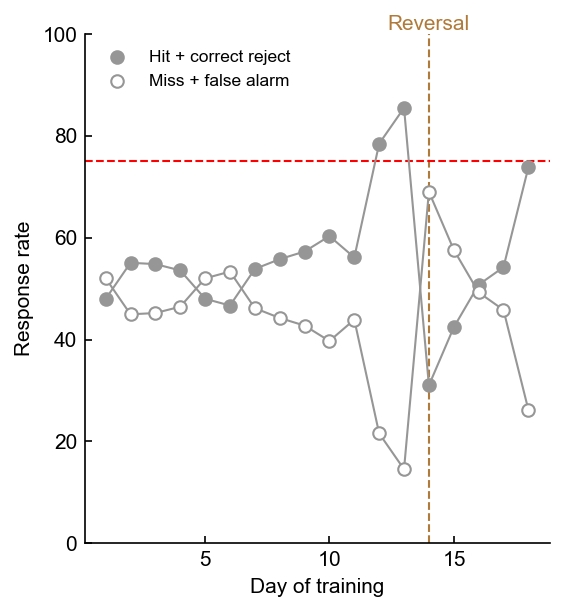

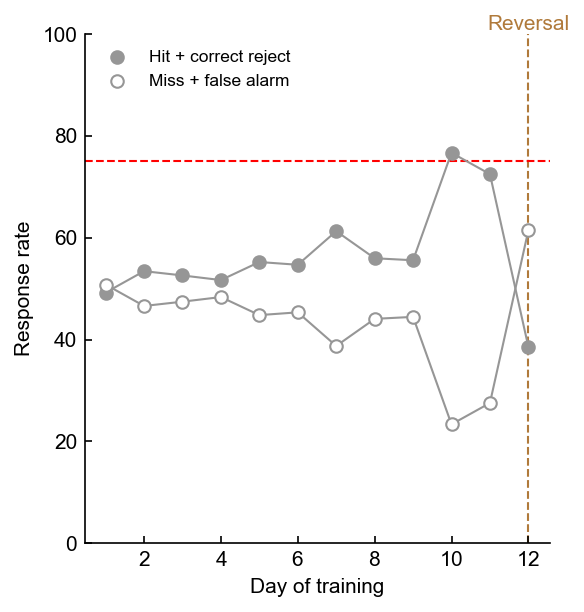

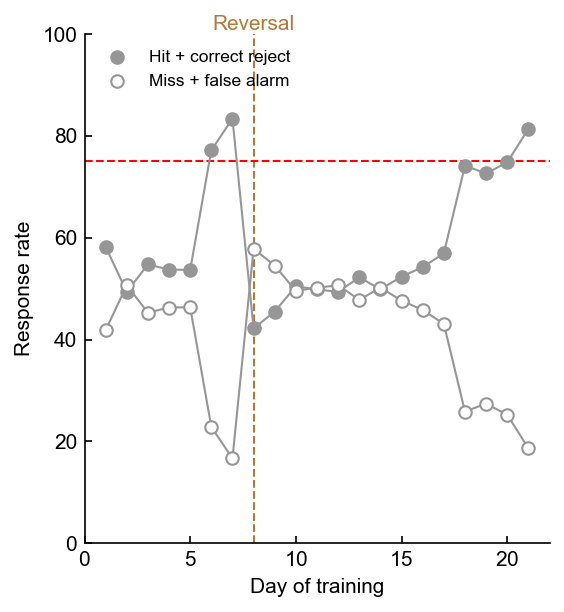

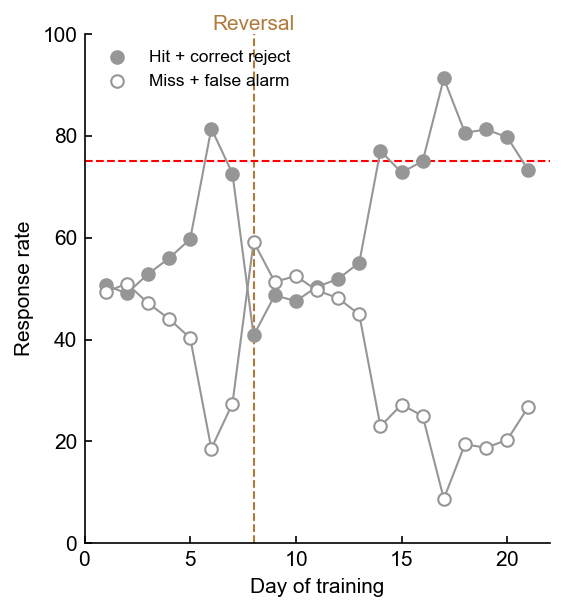

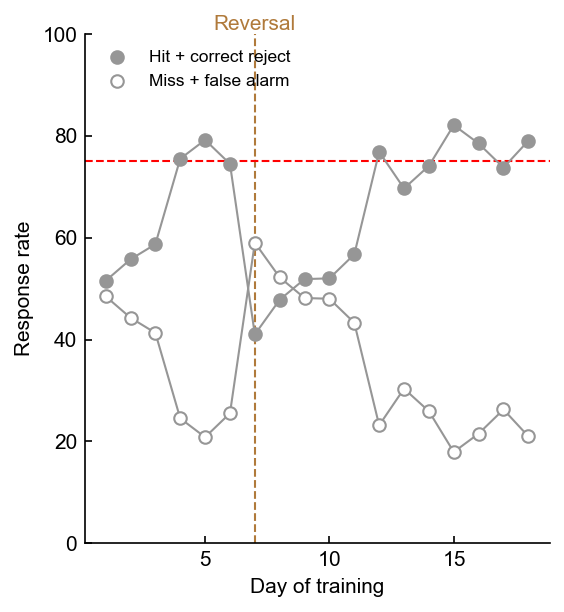

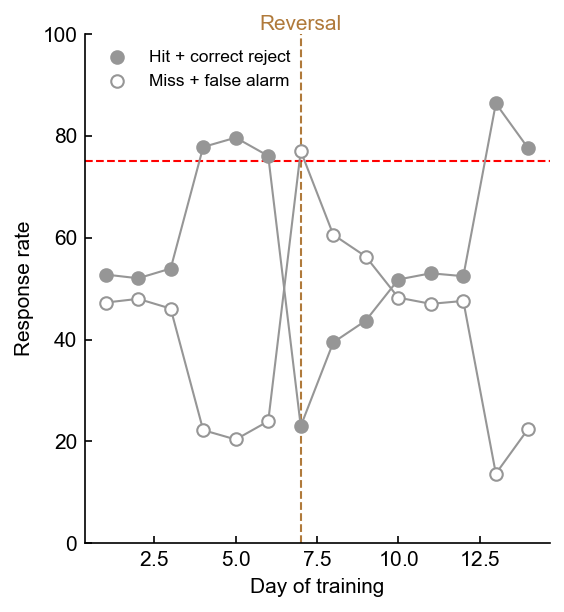

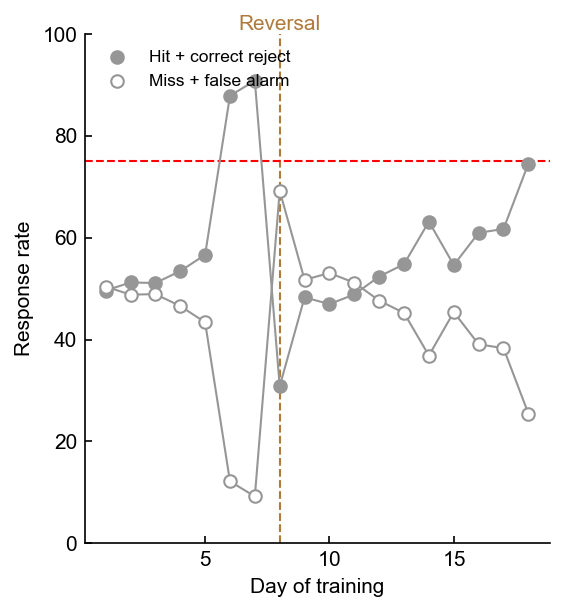

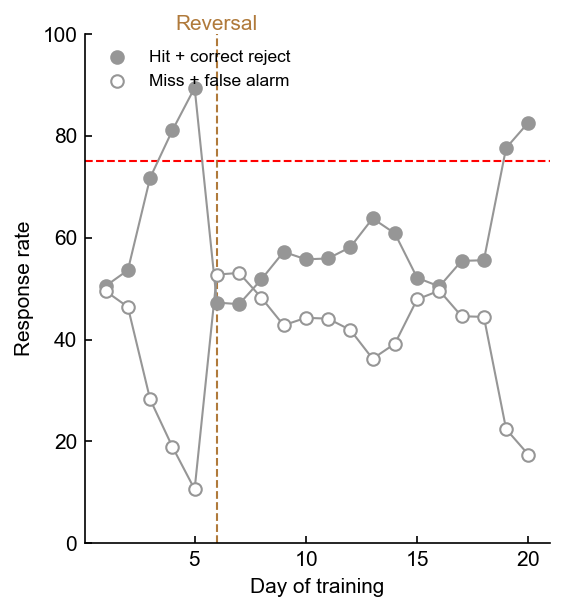

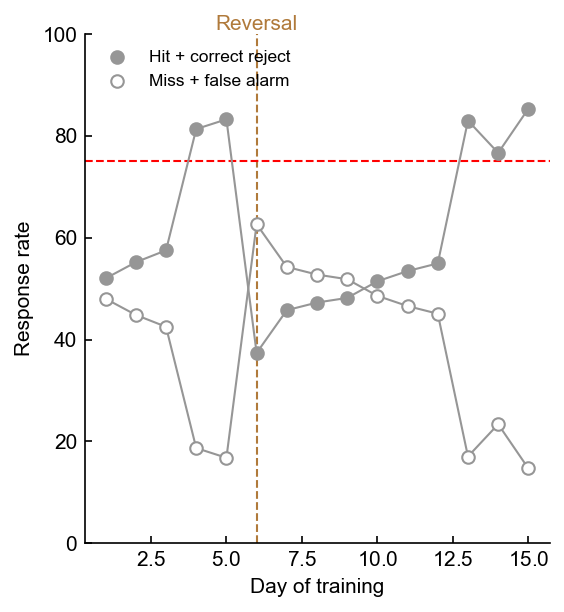

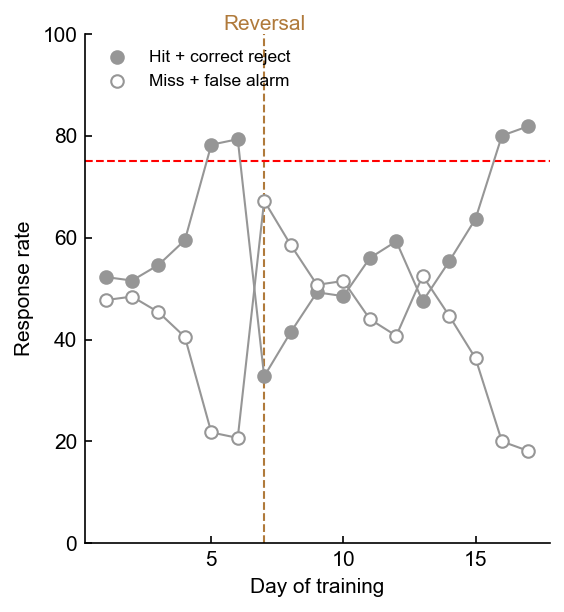

In [41]:
for animalidx,animal in enumerate(animals):    
    fig, ax = plt.subplots(figsize=(4,4.5))
    
    reversal = np.Inf
    if hasattr(animalBehaviors[animal],'reversal'):
        reversal = animalBehaviors[animal].reversal
    
    days = [k for k in animalBehaviors[animal].sessions]
    if hasattr(animalBehaviors[animal],'reversal'):
        days.append(reversal)
    days = np.sort(days)
    
    pre_exp,post_exp = getExpertDays(animalBehaviors,animal)
    expert_days = np.concatenate((pre_exp,post_exp))
    dp_list,pc_list = getPCDPfromBehavior(animalBehaviors,animal,days,expert_days)
    
    #Remove first half of reversal day
    pc_list = list(pc_list)
    days = list(days)
    del pc_list[reversal-1]
    del days[reversal-1]
    pc_list = np.array(pc_list)
    days = np.array(days)
    
    ax.plot(days,pc_list,lw=1,color=GOOD_GREY,zorder=3)
    ax.scatter(days,pc_list,lw=1,color=GOOD_GREY,zorder=4,label='Hit + correct reject')
    
    ax.plot(days,1-pc_list,lw=1,color=GOOD_GREY,zorder=3)
    ax.scatter(days,1-pc_list,lw=1,ec=GOOD_GREY,fc='white',zorder=5,label='Miss + false alarm')
    
    ax.legend(loc='upper left',frameon=False)
    
    ax.axhline(0.75,color='red',linestyle='--',zorder=-9,lw=1)

    ax.axvline(reversal,color=SWITCH_COLOR,linestyle='--',zorder=-10,lw=1)
    #ax.text(reversal,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
    ax.text(reversal,1,'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')

    ax.set_xlabel('Day of training')
    ax.set_ylabel('Response rate')
    ax.set_ylim([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
    ax.set_yticklabels([0,20,40,60,80,100])

    fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','Learning Curve examples for Fig1',animal+' learning curve example.pdf'),transparent=False,facecolor="white")

In [46]:
a = np.array(range(10))
b = np.array(range(10,20))
perm = np.random.permutation(range(len(a)))
#a = a[perm]
#b = b[perm]
print(a)
print(b)

[0 1 2 3 4 5 6 7 8 9]
[10 11 12 13 14 15 16 17 18 19]


In [47]:
print(a[perm])

[5 6 2 4 1 7 0 8 3 9]


In [49]:
a[perm][2:5]

array([2, 4, 1])